<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Cleaning notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
import math
from math import prod
from collections import Counter
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_theme(style="darkgrid")




from sklearn.metrics import mean_squared_error










<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        columns (list): Dataframe keys in list format
        
        *args, **kwargs:
        -----------------
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                   (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            
               
def plot_values_missingno(df, first_col, last_col, *args, **kwargs):
    """
    Plotting missing values with missingno

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        first_col (int): First column to graph.
        last_col (int): Last column to graph.
        numbers_plot (int): Total numbers of graphs.
        plot_number (int): Number of the graph.
        
    Returns:
    -----------------
        None. 
        Plotting the missing values with missingno
    """
    
    # Getting the variables
    numbers_plot = kwargs.get("numbers_plot", None)
    plot_number = kwargs.get("plot_number", None)
    
    
    fig, axs = plt.subplots(2,1)
    msno.matrix(df.iloc[:, first_col:last_col], sparkline=False, fontsize=14, ax=axs[0])
    msno.bar(df.iloc[:, first_col:last_col], ax=axs[1], fontsize=14)            

    for ax in axs:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[:8] + "..." + s[-8:] if len(s) > 16 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)

    fig.set_size_inches(18,14)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False, top=False, bottom=False) for ax in axs.flatten()];

    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    
    if plot_number == None:
        fig.suptitle("Missing data overview", fontweight="bold", fontsize=20)
    else:
        fig.suptitle("Missing data overview\n(part " + str(plot_number) + "/" + str(numbers_plot) + ")", fontweight="bold", fontsize=20)       

    plt.show()
                        
            
def plot_missing_values(df, numbers_col):
    """
    Method used for plotting missing values

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        numbers_col (int): Number of columns to show in each image.
        
    Returns:
    -----------------
        None. 
    """
    
    first_col = 0
    
    if df.shape[1] // numbers_col != 0:
        
        for i in range (1, df.shape[1] // numbers_col + 1):
            
            if i == df.shape[1] // numbers_col:
                last_col = None
            else:
                last_col = i * numbers_col

            plot_values_missingno(df, first_col, last_col, numbers_plot=(df.shape[1] // numbers_col), plot_number=i)

            if i == data.shape[1] // 30:
                # deleting dataframe to free memory
                del [df]
                gc.collect()
                df = pd.DataFrame()

                break            
            else:
                first_col = last_col + 1
    else:
        
        plot_values_missingno(df, first_col, None)
            
        del [df]
        gc.collect()
        df = pd.DataFrame()
        

def encode(df):
    """
    Function to encode non-null data and replace it in the original data.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        df (pandas.DataFrame): DataFrame comparison.
        
    """
    
    # Instante package to use
    encoder = OrdinalEncoder()

    # Retains only non-null values
    no_nulls = np.array(df.dropna())
    
    # Reshapes the df for encoding
    impute_reshape = no_nulls.reshape(-1,1)
    
    # Encode df
    impute_ordinal = encoder.fit_transform(impute_reshape)
    
    # Assign back encoded values to non-null values
    df.loc[df.notnull()] = np.squeeze(impute_ordinal)
    
    return df
        

class GroupImputer(BaseEstimator, TransformerMixin):
    """ 
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters:
    -----------------  
        group_cols (list) : List of columns used for calculating the aggregated value 
        strategy (str) : The strategy to be used for remplacement, can be one of ["mean", "median", "mode"]
        
    Returns:
    -----------------
        X (array-like) : The array with imputed values in the target column
   """    
    
    def __init__(self, group_cols, target, strategy="mean"):
        
        assert strategy in ["mean", "median"], "Unrecognized value for metric, should be mean/median"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        assert type(target) == list, "target should be a string"
        
        self.group_cols = group_cols
        self.target = target
        self.strategy = strategy
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, "There are missing values in group_cols"
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.strategy) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
Reading data in <b>chunks of 1 million rows</b> at a time
</div>

In [3]:
start = time.time()
chunk = pd.read_csv("datasets/en.openfoodfacts.org.products.csv", chunksize=1000000, sep="\t", encoding="UTF-8")
data = pd.concat(chunk)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,29,31,47,52,64,81,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read csv with chunks:  115.9153184890747 sec


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Missing data overview</h3>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    <ul style="list-style-type: square;">
        <li>Almost <b>80%</b> of the data present in data set are <b>missing values</b></li>
        <li>There are <b>5 empty columns</b> that we can delete</li>
        <li>There is a lot of <b>memory usage</b> with this dataset</li>
    </ul>
</div>

In [4]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760097 rows and 186 columns
- Total of NaN values:            260478039
- Percentage of NaN:              79.56 %
- Total of full duplicates rows:  1
- Total of empty rows:            0
- Total of empty columns:         5
  + The empty column are:          ['cities', 'allergens_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


name     type  records    # NaN  \
0                                          code   object  1760097        0   
6                        last_modified_datetime   object  1760097        0   
63                                    states_en   object  1760097        0   
62                                  states_tags   object  1760097        0   
61                                       states   object  1760097        0   
1                                           url   object  1760097        0   
5                               last_modified_t    int64  1760097        0   
4                              created_datetime   object  1760097        0   
3                                     created_t    int64  1760097        0   
2                                       creator   object  1760093        4   
60                                pnns_groups_2   object  1759730      367   
34                                    countries   object  1754604     5493   
36                                 countries_en   object  1754600     5497   
35                               countries_tags   object  1754600     5497   
59                                pnns_groups_1   object  1743530    16567   
7                                  product_name   object  1682674    77423   
77                                  energy_100g  float64  1397732   362365   
128                               proteins_100g  float64  1390642   369455   
79                                     fat_100g  float64  1389669   370428   
115                          carbohydrates_100g  float64  1389200   370897   
116                                 sugars_100g  float64  1372059   388038   
80                           saturated-fat_100g  float64  1346364   413733   
76                             energy-kcal_100g  float64  1343908   416189   
132                                   salt_100g  float64  1341585   418512   
133                                 sodium_100g  float64  1341581   418516   
70                              image_small_url   object  1315404   444693   
69                                    image_url   object  1315404   444693   
14                                       brands   object   918867   841230   
15                                  brands_tags   object   918811   841286   
74                    image_nutrition_small_url   object   858019   902078   
73                          image_nutrition_url   object   858019   902078   
16                                   categories   object   841867   918230   
17                              categories_tags   object   841866   918231   
68                             main_category_en   object   841866   918231   
18                                categories_en   object   841866   918231   
67                                main_category   object   841866   918231   
53      ingredients_that_may_be_from_palm_oil_n  float64   687715  1072382   
46                                  additives_n  float64   687715  1072382   
50                  ingredients_from_palm_oil_n  float64   687715  1072382   
37                             ingredients_text   object   687713  1072384   
72                  image_ingredients_small_url   object   675186  1084911   
71                        image_ingredients_url   object   675186  1084911   
177                     nutrition-score-fr_100g  float64   655006  1105091   
57                             nutriscore_grade   object   655001  1105096   
56                             nutriscore_score  float64   655001  1105096   
58                                   nova_group  float64   601437  1158660   
43                                 serving_size   object   468298  1291799   
125                                  fiber_100g  float64   467580  1292517   
44                             serving_quantity  float64   463383  1296714   
10                                     quantity   object   455823  1304274   
65                            ecoscore_score_fr  float64   421369

<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

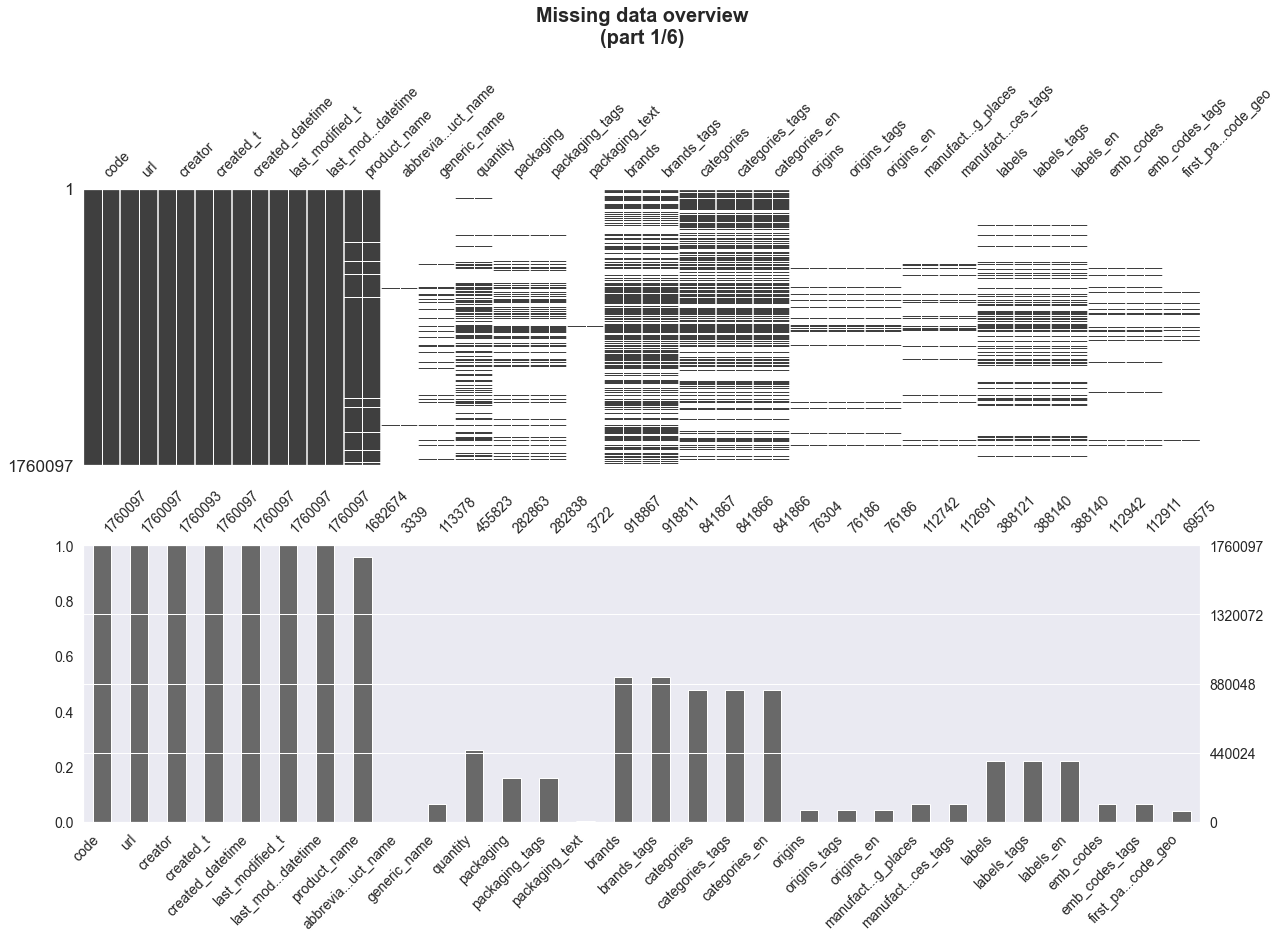

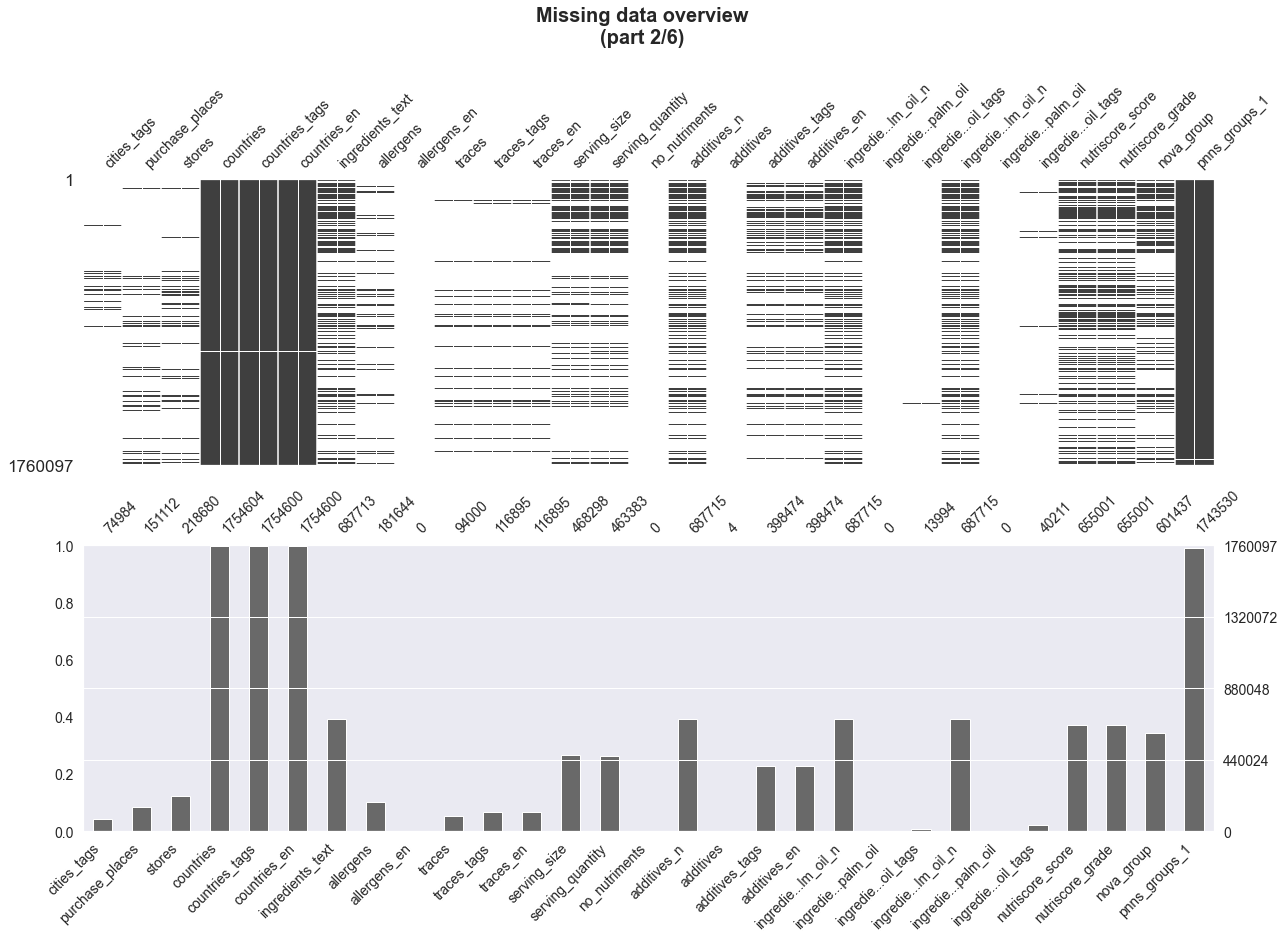

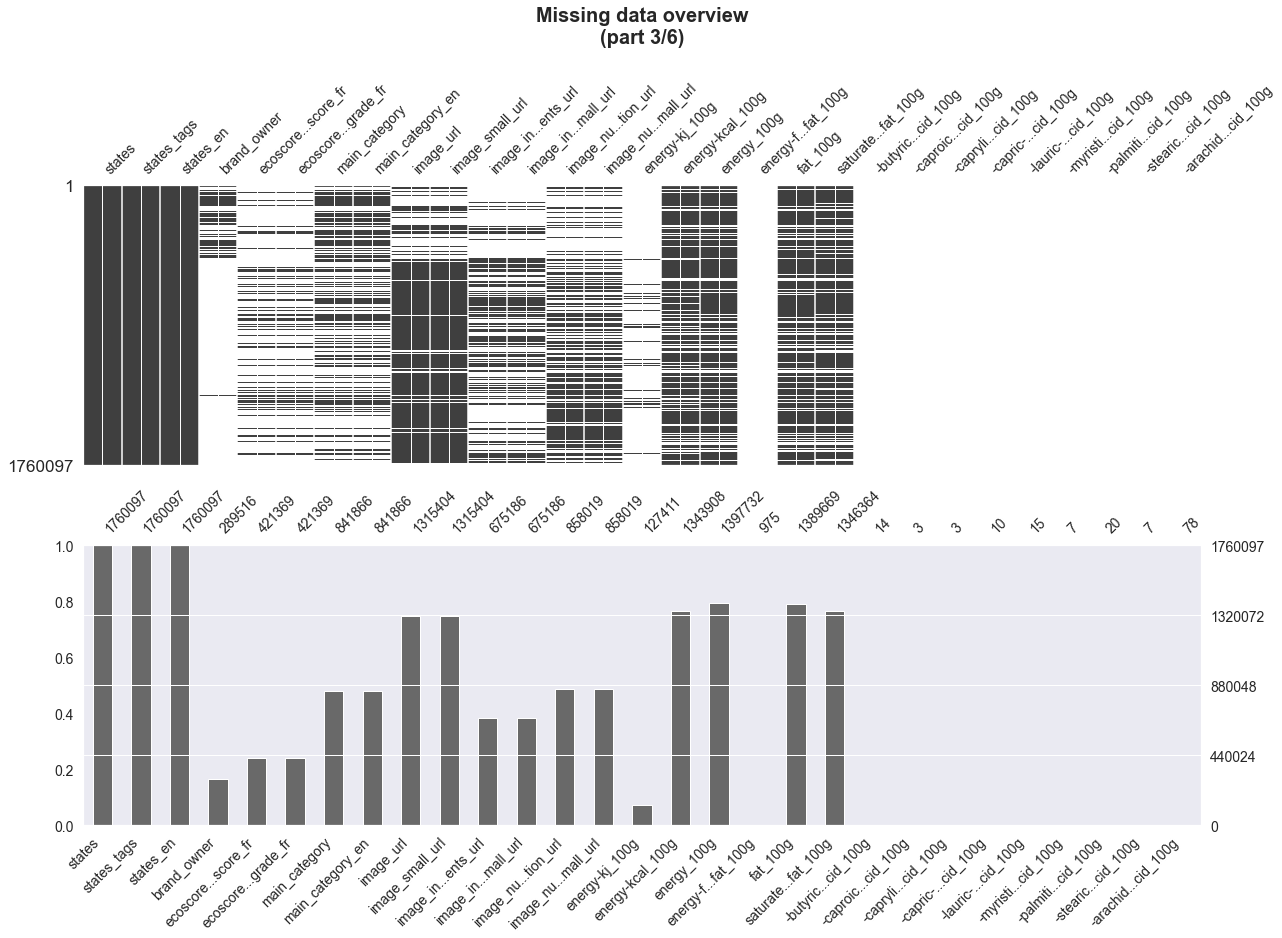

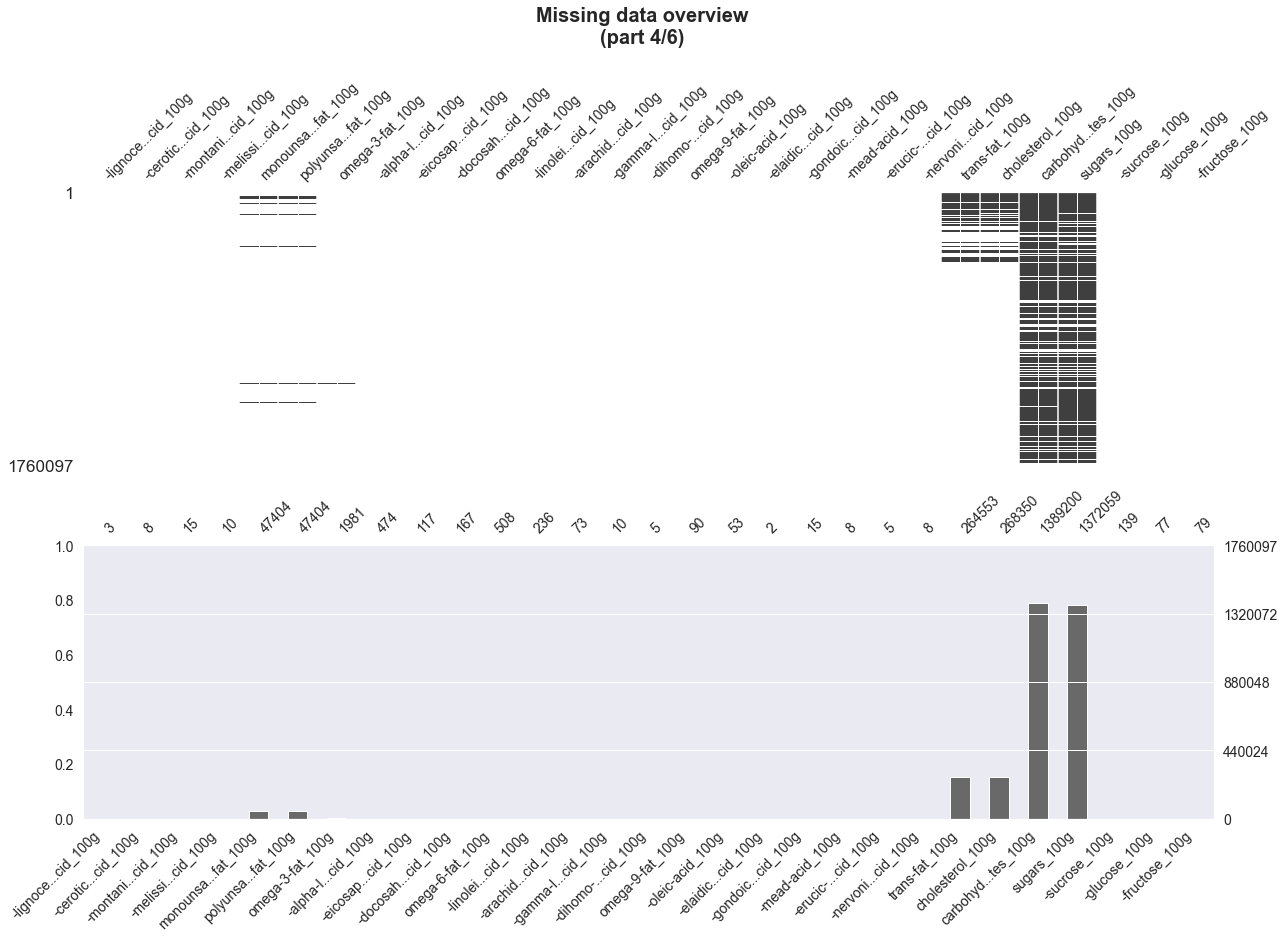

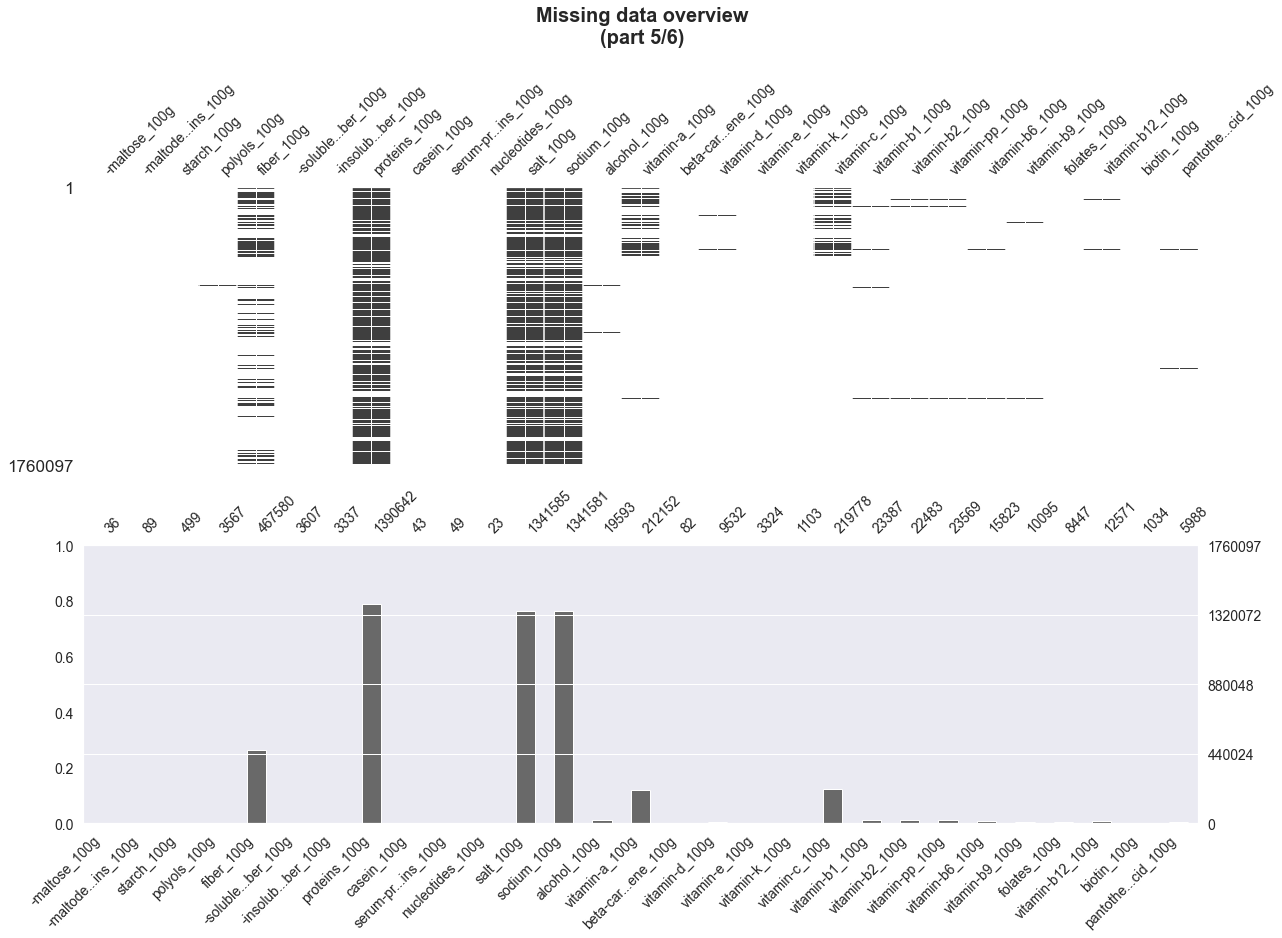

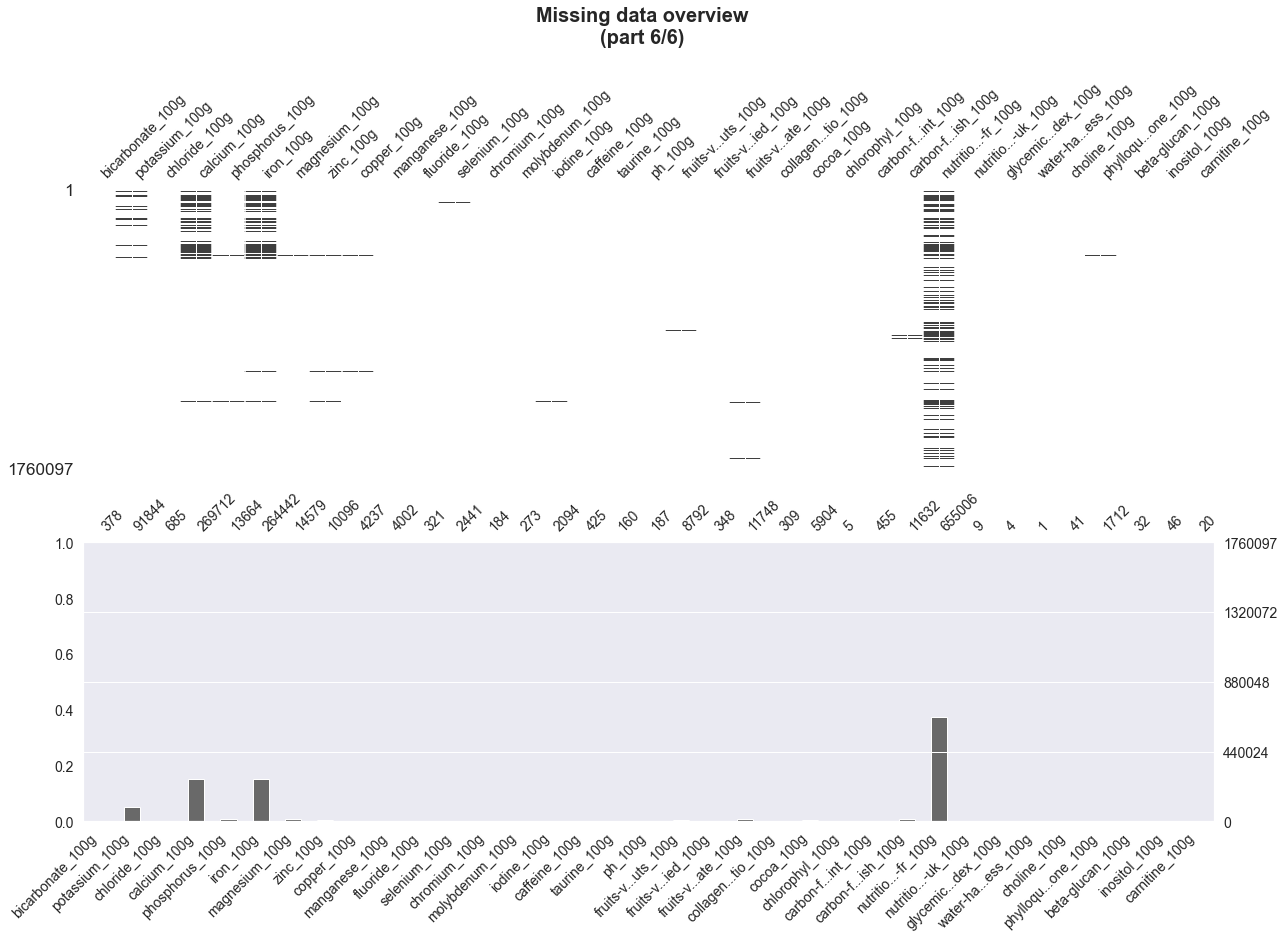

In [5]:
plot_missing_values(data, 30)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Initial cleaning</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Deleting NaN columns and rows, and duplicated rows</h3>
</div>

In [6]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [7]:
data = data.drop_duplicates()

In [8]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 181 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


name     type  records    # NaN  \
0                                          code   object  1760096        0   
58                                    states_en   object  1760096        0   
3                                     created_t    int64  1760096        0   
4                              created_datetime   object  1760096        0   
5                               last_modified_t    int64  1760096        0   
6                        last_modified_datetime   object  1760096        0   
57                                  states_tags   object  1760096        0   
1                                           url   object  1760096        0   
56                                       states   object  1760096        0   
2                                       creator   object  1760092        4   
55                                pnns_groups_2   object  1759729      367   
33                                    countries   object  1754603     5493   
35                                 countries_en   object  1754599     5497   
34                               countries_tags   object  1754599     5497   
54                                pnns_groups_1   object  1743529    16567   
7                                  product_name   object  1682674    77422   
72                                  energy_100g  float64  1397732   362364   
123                               proteins_100g  float64  1390642   369454   
74                                     fat_100g  float64  1389669   370427   
110                          carbohydrates_100g  float64  1389200   370896   
111                                 sugars_100g  float64  1372059   388037   
75                           saturated-fat_100g  float64  1346364   413732   
71                             energy-kcal_100g  float64  1343908   416188   
127                                   salt_100g  float64  1341585   418511   
128                                 sodium_100g  float64  1341581   418515   
65                              image_small_url   object  1315403   444693   
64                                    image_url   object  1315403   444693   
14                                       brands   object   918867   841229   
15                                  brands_tags   object   918811   841285   
69                    image_nutrition_small_url   object   858019   902077   
68                          image_nutrition_url   object   858019   902077   
16                                   categories   object   841867   918229   
18                                categories_en   object   841866   918230   
62                                main_category   object   841866   918230   
17                              categories_tags   object   841866   918230   
63                             main_category_en   object   841866   918230   
49      ingredients_that_may_be_from_palm_oil_n  float64   687715  1072381   
43                                  additives_n  float64   687715  1072381   
47                  ingredients_from_palm_oil_n  float64   687715  1072381   
36                             ingredients_text   object   687713  1072383   
67                  image_ingredients_small_url   object   675186  1084910   
66                        image_ingredients_url   object   675186  1084910   
172                     nutrition-score-fr_100g  float64   655006  1105090   
52                             nutriscore_grade   object   655001  1105095   
51                             nutriscore_score  float64   655001  1105095   
53                                   nova_group  float64   601437  1158659   
41                                 serving_size   object   468298  1291798   
120                                  fiber_100g  float64   467580  1292516   
42                             serving_quantity  float64   463383  1296713   
10                                     quantity   object   455823  1304273   
60                            ecoscore_score_fr  float64   421369

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Fixing the columns types</h3>
</div>

<div class="alert alert-block alert-warning">
There are some columns with column type wrong. We can see this information based on:
<ul style="list-style-type: square;">
    <li>Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b></li>
    <li>At the momento to <b>import the *.csv</b></li>
    <li>As a result of the function <b>df_initial_analysis</b></li>
</ul>

Due to that, we are going to proceed to fix them. 
</div>
<div class="alert alert-block alert-info">
<b>Fixing column types float64</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li>fields that end with <b>_100g</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>100 g</b> or <b>100 ml</b> of product</li>
    <li>fields that end with <b>_serving</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>1</b> serving of the product</li>
</ul>

Finally, we are going to make the <b>downcast</b> from <b>float64</b> to <b>float32</b> 
</div>

In [9]:
for col in data.columns:
    if (col.endswith("_100g") or col.endswith("_serving")) and data[col].dtypes != "float64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("float64")

Column to update the column type: -butyric-acid_100g object
Column to update the column type: -capric-acid_100g object


In [10]:
for col in data.columns:
    if data[col].dtypes == "float64":
        data[col] = data[col].astype("float32")

<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following:
<ul style="list-style-type: square;">
    <li>fields that end with <b>_t</b> are dates in <b>the UNIX timestamp format</b> (number of seconds since Jan 1st 1970)</b></li>
    <li>fields that end with <b>_datetime</b> are dates in <b>the iso8601 format: yyyy-mm-ddThh:mn:ssZ</b></li>
</ul>

In this case, both group of columns have the same amount of data. Due to that, we will only keep the columns ended by <b>_datetime</b>
</div>

In [11]:
for col in data.columns:
    if col.endswith("_datetime") and data[col].dtypes != "datetime64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("datetime64")

Column to update the column type: created_datetime object
Column to update the column type: last_modified_datetime object


In [12]:
for col in data.columns:
    if col.endswith("_t"):
        print("Column to delete:", col, data[col].dtypes)
        data = data.drop(col, axis=1)  

Column to delete: created_t int64
Column to delete: last_modified_t int64


<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [13]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: datetime64[ns](2), float32(118), object(59)
memory usage: 8.1 GB


<div class="alert alert-block alert-info">
If the number of unique values in a specific column is less than the half numbers of rows in the same column,<br>
we are going to change the type from <b>object</b> to <b>category</b> to improve the usage of memory
</div>

In [14]:
for col in data.columns:
    if data[col].dtypes == "object":
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype("category")
        else:
            data[col] = data[col].astype("object")

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [15]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 2.9 GB


In [16]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 179 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.88 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 1.4+ GB )
--------------------------------------------------------------------


name            type  records  \
0                                          code          object  1760096   
54                                       states        category  1760096   
56                                    states_en        category  1760096   
55                                  states_tags        category  1760096   
1                                           url          object  1760096   
4                        last_modified_datetime  datetime64[ns]  1760096   
3                              created_datetime  datetime64[ns]  1760096   
2                                       creator        category  1760092   
53                                pnns_groups_2        category  1759729   
31                                    countries        category  1754603   
33                                 countries_en        category  1754599   
32                               countries_tags        category  1754599   
52                                pnns_groups_1        category  1743529   
5                                  product_name          object  1682674   
70                                  energy_100g         float32  1397732   
121                               proteins_100g         float32  1390642   
72                                     fat_100g         float32  1389669   
108                          carbohydrates_100g         float32  1389200   
109                                 sugars_100g         float32  1372059   
73                           saturated-fat_100g         float32  1346364   
69                             energy-kcal_100g         float32  1343908   
125                                   salt_100g         float32  1341585   
126                                 sodium_100g         float32  1341581   
63                              image_small_url          object  1315403   
62                                    image_url          object  1315403   
12                                       brands        category   918867   
13                                  brands_tags        category   918811   
67                    image_nutrition_small_url        category   858019   
66                          image_nutrition_url        category   858019   
14                                   categories        category   841867   
61                             main_category_en        category   841866   
60                                main_category        category   841866   
16                                categories_en        category   841866   
15                              categories_tags        category   841866   
45                  ingredients_from_palm_oil_n         float32   687715   
47      ingredients_that_may_be_from_palm_oil_n         float32   687715   
41                                  additives_n         float32   687715   
34                             ingredients_text        category   687713   
65                  image_ingredients_small_url        category   675186   
64                        image_ingredients_url        category   675186   
170                     nutrition-score-fr_100g         float32   655006   
50                             nutriscore_grade        category   655001   
49                             nutriscore_score         float32   655001   
51                                   nova_group         float32   601437   
39                                 serving_size        category   468298   
118                                  fiber_100g         float32   467580   
40                             serving_quantity         float32   463383   
8                                      quantity        category   455823   
59                            ecoscore_grade_fr        category   421369   
58                            ecoscore_score_fr         float32   421369   
44                                 additives_en        category   398474   
43                               additives_tags        category   398474   
24             

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Filtering information</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Filtering information by country France</h3>
</div>

<div class="alert alert-block alert-info">
<b>Countries where the product is sold</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> There are three fields about countries where the product is sold</li>
        <ul style="list-style-type: disc;">
            <li>countries</li>
            <li>countries_en</li>
            <li>countries_tags</li>
        </ul>
</ul>

After analyzing the columns, we have decided to used the columns called <b>countries</b>.<br>
We are going to filter considering only France and its overseas department
</div>

In [17]:
FILTERING_BY_FRANCE = [
    "France", "fr", "Francia", "French", "Frankreich", "Nouvelle-Calédonie", "Martinique", "Guadeloupe", "Polynésie Française", "Mayotte"
]

<div class="alert alert-block alert-success">
At this point, we have reduced the amount of data in the dataset filtering by country France
</div>

In [18]:
data = pd.DataFrame(data[data["countries"].str.contains("|".join(FILTERING_BY_FRANCE), case = False, na=False).any(level=0)])

In [19]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798009 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 1.8 GB


In [20]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 179 columns
- Total of NaN values:            114437088
- Percentage of NaN:              80.11 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         4
  + The empty column are:          ['-lignoceric-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-elaidic-acid_100g', 'water-hardness_100g']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 710.3+ MB )
--------------------------------------------------------------------


name            type  records  \
0                                          code          object   798009   
54                                       states        category   798009   
3                              created_datetime  datetime64[ns]   798009   
4                        last_modified_datetime  datetime64[ns]   798009   
55                                  states_tags        category   798009   
56                                    states_en        category   798009   
1                                           url          object   798009   
33                                 countries_en        category   798009   
32                               countries_tags        category   798009   
31                                    countries        category   798009   
2                                       creator        category   798008   
53                                pnns_groups_2        category   797916   
52                                pnns_groups_1        category   786824   
5                                  product_name          object   775020   
62                                    image_url          object   720228   
63                              image_small_url          object   720228   
70                                  energy_100g         float32   623090   
73                           saturated-fat_100g         float32   620073   
109                                 sugars_100g         float32   619338   
121                               proteins_100g         float32   618992   
72                                     fat_100g         float32   617113   
108                          carbohydrates_100g         float32   617058   
125                                   salt_100g         float32   603563   
126                                 sodium_100g         float32   603562   
69                             energy-kcal_100g         float32   595516   
65                  image_ingredients_small_url        category   495539   
64                        image_ingredients_url        category   495539   
12                                       brands        category   423294   
13                                  brands_tags        category   423258   
67                    image_nutrition_small_url        category   393568   
66                          image_nutrition_url        category   393568   
61                             main_category_en        category   359436   
14                                   categories        category   359436   
15                              categories_tags        category   359436   
16                                categories_en        category   359436   
60                                main_category        category   359436   
170                     nutrition-score-fr_100g         float32   278984   
50                             nutriscore_grade        category   278981   
49                             nutriscore_score         float32   278981   
8                                      quantity        category   261144   
59                            ecoscore_grade_fr        category   255512   
58                            ecoscore_score_fr         float32   255512   
23                                  labels_tags        category   247663   
24                                    labels_en        category   247663   
22                                       labels        category   247638   
45                  ingredients_from_palm_oil_n         float32   243846   
47      ingredients_that_may_be_from_palm_oil_n         float32   243846   
41                                  additives_n         float32   243846   
34                             ingredients_text        category   243844   
51                                   nova_group         float32   204621   
9                                     packaging        category   175751   
10                               packaging_tags        category   175742   
118            

In [21]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

<div class="alert alert-block alert-info">
Exectuting the <b>describe()</b> function on the dataframe
</div>

In [22]:
pd.set_option("display.max_columns", None) # show full of showing cols
data.describe()

C:\Users\Samir\anaconda3\lib\site-packages\numpy\lib\function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


serving_quantity    additives_n  ingredients_from_palm_oil_n  \
count      79357.000000  243846.000000                243846.000000   
mean         118.894379       1.615872                     0.048883   
std          778.501587       2.375888                     0.218628   
min            0.000000       0.000000                     0.000000   
25%           29.000000       0.000000                     0.000000   
50%           80.000000       1.000000                     0.000000   
75%          140.000000       2.000000                     0.000000   
max       100660.000000      30.000000                     3.000000   

       ingredients_that_may_be_from_palm_oil_n  nutriscore_score  \
count                            243846.000000     278981.000000   
mean                                  0.114092          9.532871   
std                                   0.400777          8.777076   
min                                   0.000000        -15.000000   
25%                                   0.000000          2.000000   
50%                                   0.000000         10.000000   
75%                                   0.000000         16.000000   
max                                   6.000000         40.000000   

          nova_group  ecoscore_score_fr  energy-kj_100g  energy-kcal_100g  \
count  204621.000000      255512.000000    7.190500e+04      5.955160e+05   
mean        3.411380          48.509956    1.103681e+03      2.832928e+02   
std         0.968259          26.653727    4.161248e+03      3.785576e+03   
min         1.000000         -23.000000    0.000000e+00      0.000000e+00   
25%         3.000000          29.000000    4.350000e+02      1.110000e+02   
50%         4.000000          43.000000    9.770000e+02      2.650000e+02   
75%         4.000000          71.000000    1.610000e+03      4.020000e+02   
max         4.000000         125.000000    1.094259e+06      2.910000e+06   

        energy_100g  energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count  6.230900e+05            131.000000  617113.000000       620073.000000   
mean   1.178383e+03            432.374054      14.309522            5.446947   
std    1.553860e+04            704.321167     117.423164           29.066158   
min    0.000000e+00              0.000000       0.000000            0.000000   
25%    4.640000e+02              6.500000       1.000000            0.200000   
50%    1.100000e+03            209.000000       8.000000            2.000000   
75%    1.674000e+03            533.500000      22.000000            8.000000   
max    1.220000e+07           3740.000000   91200.000000        21900.000000   

       -butyric-acid_100g  -caproic-acid_100g  -caprylic-acid_100g  \
count        3.000000e+00            2.000000                  1.0   
mean         2.582482e+20           24.014999                 97.0   
std                   inf           33.919910                  NaN   
min          6.820000e-03            0.030000                 97.0   
25%          2.934100e-01           12.022500                 97.0   
50%          5.800000e-01           24.014999                 97.0   
75%          3.873723e+20           36.007500                 97.0   
max          7.747446e+20           48.000000                 97.0   

       -capric-acid_100g  -lauric-acid_100g  -myristic-acid_100g  \
count              2.000           7.000000                 1.00   
mean                 inf          27.353390                 0.12   
std                  NaN          25.474590                  NaN   
min                0.006           0.002000                 0.12   
25%                  inf           0.235865                 0.12   
50%                  NaN          45.000000                 0.12   
75%                  NaN          48.500000                 0.12   
max                  inf          49.000000                 0.12   

       -palmitic-acid_100g  -stearic-acid_100g  -arachidic-acid_100g  \
count         4.000000e

In [23]:
pd.reset_option("display.max_columns") # reset max of showing cols

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Application idea fields</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Idenfiying Application idea fields</h3>
</div>

<div class="alert alert-block alert-info">
Based on <b>Santé publique France</b> we can get the fiedls to calculate the <b>Nutri-Score</b><br><br>
You can see the information in details in the link below<br>
<b>https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score</b><br><br>
    
<b>Application fields</b>
<ul style="list-style-type: square;">
    <li>Energetic value</li>
    <li>Fat</li>
    <li>Saturated fat</li>
    <li>Sugar</li>
    <li>Protein</li>
    <li>Salt / Sodium</li>
    <li>Fibers</li>
    <li>Fruits, vegetables, legumes, nuts, rapeseed, walnut and olive oils</li>
</ul>
</div>

In [24]:
pd.set_option("display.max_columns", None)
data.head(5)

code                                                url  \
0         0000000000017  http://world-en.openfoodfacts.org/product/0000...   
1         0000000000031  http://world-en.openfoodfacts.org/product/0000...   
4         0000000000100  http://world-en.openfoodfacts.org/product/0000...   
5  00000000001111111111  http://world-en.openfoodfacts.org/product/0000...   
6         0000000000123  http://world-en.openfoodfacts.org/product/0000...   

                      creator    created_datetime last_modified_datetime  \
0                     kiliweb 2018-06-15 10:38:00    2019-06-25 11:55:18   
1                    isagoofy 2018-10-13 21:06:14    2018-10-13 21:06:57   
4                       del51 2015-10-11 14:09:21    2015-10-12 14:13:32   
5  openfoodfacts-contributors 2019-06-08 18:56:13    2019-06-08 18:56:13   
6                     kiliweb 2018-08-31 17:53:02    2018-08-31 17:53:06   

                   product_name abbreviated_product_name generic_name  \
0              Vitória crackers                      NaN          NaN   
1                         Cacao                      NaN          NaN   
4   moutarde au moût de raisin                       NaN          NaN   
5                       Sfiudwx                      NaN          NaN   
6         Sauce Sweety chili 0%                      NaN          NaN   

  quantity packaging packaging_tags packaging_text         brands  \
0      NaN       NaN            NaN            NaN            NaN   
1    130 g       NaN            NaN            NaN            NaN   
4     100g       NaN            NaN            NaN  courte paille   
5    dgesc       NaN            NaN            NaN           Watt   
6      NaN       NaN            NaN            NaN            NaN   

     brands_tags                               categories  \
0            NaN                                      NaN   
1            NaN                                      NaN   
4  courte-paille  Epicerie, Condiments, Sauces, Moutardes   
5           watt                                      Xsf   
6            NaN                                      NaN   

                                    categories_tags  \
0                                               NaN   
1                                               NaN   
4  en:groceries,en:condiments,en:sauces,en:mustards   
5                                            fr:xsf   
6                                               NaN   

                          categories_en origins origins_tags origins_en  \
0                                   NaN     NaN          NaN        NaN   
1                                   NaN     NaN          NaN        NaN   
4  Groceries,Condiments,Sauces,Mustards     NaN          NaN        NaN   
5                                fr:xsf     NaN          NaN        NaN   
6                                   NaN     NaN          NaN        NaN   

  manufacturing_places manufacturing_places_tags         labels  \
0                  NaN                       NaN            NaN   
1                  NaN                       NaN            NaN   
4                  NaN                       NaN  Delois france   
5                  NaN                       NaN            NaN   
6                  NaN                       NaN            NaN   

        labels_tags         labels_en emb_codes emb_codes_tags  \
0               NaN               NaN       NaN            NaN   
1               NaN               NaN       NaN            NaN   
4  fr:delois-france  fr:delois-france       NaN            NaN   
5               NaN               NaN       NaN            NaN   
6               NaN               NaN       NaN            NaN   

  first_packaging_code_geo cities_tags purchase_places         stores  \
0                      NaN         NaN             NaN            NaN   
1                      NaN         NaN             NaN            NaN   
4                      NaN         NaN             NaN  courte paille  

In [25]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
After analyzing the columns we can identify the following fields for <b>Nutri-Score</b> <b>and App idea</b> 
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
    <tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Brand</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
        <td align="left"></td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Analyzing  the Application idea fields</h3>
</div>

<div class="alert alert-block alert-info">
    Let's create a dataframe with interesting fields of the <b>application idea</b>
</div>

In [26]:
BASIC_FIELDS = [
    "code", "last_modified_datetime", "product_name", "brands", "brands_tags",
    "categories", "main_category", "main_category_en", "categories_tags", 
    "categories_en", "image_url"
]

In [27]:
NUTRI_SCORE_FIELDS = [
    "energy-kj_100g", "energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", 
    "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [28]:
df_app = data[BASIC_FIELDS + NUTRI_SCORE_FIELDS].copy(deep=True)

<div class="alert alert-block alert-info">
Deleting <b>data</b> dataframe to free memory
</div>

In [29]:
del data
gc.collect()
data = pd.DataFrame()

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [30]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 23 columns
- Total of NaN values:            7489628
- Percentage of NaN:              40.81 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  \
0                                   code          object   798009  797949   
1                 last_modified_datetime  datetime64[ns]   798009  696994   
2                           product_name          object   775020  528750   
10                             image_url          object   720228  720158   
13                           energy_100g         float32   623090    4545   
15                    saturated-fat_100g         float32   620073    3684   
16                           sugars_100g         float32   619338    5341   
17                         proteins_100g         float32   618992    4101   
14                              fat_100g         float32   617113    4941   
18                             salt_100g         float32   603563    6284   
19                           sodium_100g         float32   603562    6681   
12                      energy-kcal_100g         float32   595516    5536   
3                                 brands        category   423294   76614   
4                            brands_tags        category   423258   56664   
5                             categories        category   359436   52613   
6                          main_category        category   359436   17453   
7                       main_category_en        category   359436   17453   
8                        categories_tags        category   359436   42232   
9                          categories_en        category   359436   42232   
20                            fiber_100g         float32   139641    1381   
11                        energy-kj_100g         float32    71905    3608   
22  fruits-vegetables-nuts-estimate_100g         float32    10488     824   
21           fruits-vegetables-nuts_100g         float32     6300    1086   

     # NaN  % NaN         mean  min      25%          50%          75%  \
0        0   0.00          NaN  NaN      NaN          NaN          NaN   
1        0   0.00          NaN  NaN      NaN          NaN          NaN   
2    22989   2.88          NaN  NaN      NaN          NaN          NaN   
10   77781   9.75          NaN  NaN      NaN          NaN          NaN   
13  174919  21.92  1178.382935  0.0  464.000  1100.000000  1674.000000   
15  177936  22.30     5.446947  0.0    0.200     2.000000     8.000000   
16  178671  22.39    13.761168 -1.0    0.600     3.500000    19.985256   
17  179017  22.43     9.138214  0.0    1.500     6.200000    12.900000   
14  180896  22.67    14.309522  0.0    1.000     8.000000    22.000000   
18  194446  24.37     1.310894  0.0    0.060     0.510000     1.300000   
19  194447  24.37     0.524460  0.0    0.024     0.204000     0.520000   
12  202493  25.37   283.292847  0.0  111.000   265.000000   402.000000   
3   374715  46.96          NaN  NaN      NaN          NaN          NaN   
4   374751  46.96          NaN  NaN      NaN          NaN          NaN   
5   438573  54.96          NaN  NaN      NaN          NaN          NaN   
6   438573  54.96          NaN  NaN      NaN          NaN          NaN   
7   438573  54.96          NaN  NaN      NaN          NaN          NaN   
8   438573  54.96          NaN  NaN      NaN          NaN          NaN   
9   438573  54.96          NaN  NaN      NaN          NaN          NaN   
20  658368  82.50     3.022539  0.0    0.100     1.700000     3.670000   
11  726104  90.99  1103.681396  0.0  435.000   977.000000  1610.000000   
22  787521  98.69    46.186378  0.0   17.000    50.000000    64.000000   
21  791709  99.21    39.357758  0.0    4.090    30.630001    65.000000   

           max           std  
0          NaN           NaN  
1          NaN           NaN  
2          NaN           NaN  
10         NaN           NaN  
13  12200000.0  15538.601562  
15     21900.0     29.066158  
16      6880.0     21.925907  
17    173000.0    220.102295  
14     91200.0    117.423164  
18     25000.0     32.950630  
19     10000.0     13.180311  
12   2910000.0   3785.575684  
3      

<div class="alert alert-block alert-info">
    Processing the duplicates
</div>

In [31]:
df_app.drop_duplicates(inplace=True)

In [32]:
df_app.shape

(798009, 23)

<div class="alert alert-block alert-success">
    At this point, we have the <b>Application idea</b> dataframe.<br>
    In the next section, we are going to analyze in details, the dataframe's fields. 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Cleaning Nutri-Score and App idea dataframe</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing products without a barcode</h3>
</div>

<div class="alert alert-block alert-info">
<b>Analyzing products without a barcode</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> <b>code :</b> barcode of the product (can be EAN-13 or internal codes for some food stores),<br> for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix</li>
</ul>
</div>

In [33]:
df_temp = pd.DataFrame(df_app.loc[df_app["code"].str.startswith("200", na=False)])

In [34]:
df_analysis(df_temp, "temp", "code", flag="complete")


Analysis of temp dataset
--------------------------------------------------------------------
- Dataset shape:                  5961 rows and 23 columns
- Total of NaN values:            59174
- Percentage of NaN:              43.16 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 21.1+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  \
0                                   code          object     5961    5961   
1                 last_modified_datetime  datetime64[ns]     5961    5831   
2                           product_name          object     5795    5371   
10                             image_url          object     5404    5404   
13                           energy_100g         float32     4108    1090   
14                              fat_100g         float32     4083     511   
17                         proteins_100g         float32     4070     376   
15                    saturated-fat_100g         float32     4041     424   
16                           sugars_100g         float32     4035     614   
18                             salt_100g         float32     4006     453   
19                           sodium_100g         float32     4006     490   
12                      energy-kcal_100g         float32     3750     697   
5                             categories        category     3015    2001   
6                          main_category        category     3015    1439   
7                       main_category_en        category     3015    1439   
8                        categories_tags        category     3015    1835   
9                          categories_en        category     3015    1835   
4                            brands_tags        category     3011    1158   
3                                 brands        category     3011    1328   
20                            fiber_100g         float32      870     155   
11                        energy-kj_100g         float32      643     528   
22  fruits-vegetables-nuts-estimate_100g         float32       73      39   
21           fruits-vegetables-nuts_100g         float32       26      14   

    # NaN  % NaN         mean  min     25%       50%          75%  \
0       0   0.00          NaN  NaN     NaN       NaN          NaN   
1       0   0.00          NaN  NaN     NaN       NaN          NaN   
2     166   2.78          NaN  NaN     NaN       NaN          NaN   
10    557   9.34          NaN  NaN     NaN       NaN          NaN   
13   1853  31.09  1151.472778  0.0  510.00  1070.000  1640.000000   
14   1878  31.50    13.668987  0.0    1.70     8.900    21.000000   
17   1891  31.72     8.128023  0.0    2.80     6.300    11.000000   
15   1920  32.21     5.574977  0.0    0.40     2.500     8.800000   
16   1926  32.31    13.764969  0.0    1.10     4.800    19.799999   
18   1955  32.80     1.283938  0.0    0.10     0.680     1.230000   
19   1955  32.80     0.513575  0.0    0.04     0.272     0.492000   
12   2211  37.09   279.237976  0.0  124.00   259.000   396.000000   
5    2946  49.42          NaN  NaN     NaN       NaN          NaN   
6    2946  49.42          NaN  NaN     NaN       NaN          NaN   
7    2946  49.42          NaN  NaN     NaN       NaN          NaN   
8    2946  49.42          NaN  NaN     NaN       NaN          NaN   
9    2946  49.42          NaN  NaN     NaN       NaN          NaN   
4    2950  49.49          NaN  NaN     NaN       NaN          NaN   
3    2950  49.49          NaN  NaN     NaN       NaN          NaN   
20   5091  85.41     2.673990  0.0    0.00     1.445     3.300000   
11   5318  89.21  1097.135742  0.0  468.00  1022.000  1596.000000   
22   5888  98.78    55.071232  0.2   22.00    55.000    90.000000   
21   5935  99.56    44.888462  0.0   13.50    40.000    62.775002   

            max         std  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
10          NaN         NaN  
13  6276.000000  785.627747  
14   100.000000   15.770761  
17    85.650002    8.048944  
15   100.000000    7.425464  
16   100.000000   18.451021  
18   140.000000    5.077451  
19    56.000000    2.030981  
12  1500.000000  190.695023  
5           NaN         NaN  
6           NaN         NaN  
7           NaN         NaN  
8           NaN         NaN  
9           NaN     

<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

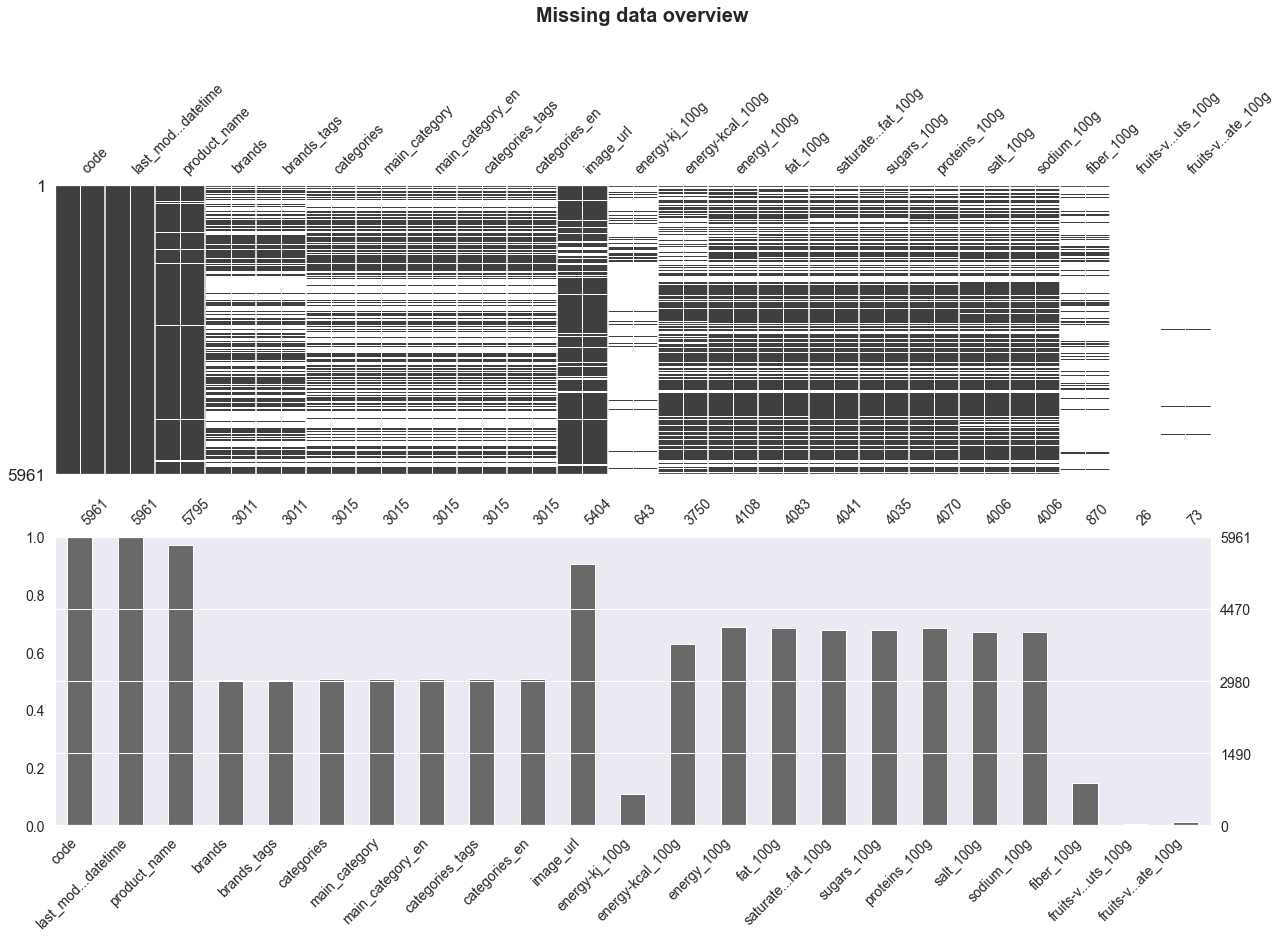

In [35]:
plot_missing_values(df_temp, 30)

<div class="alert alert-block alert-success">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>keep them</b>,<br>because these records <b>can be found</b> through the name at the time of a <b>search</b> for a product by a user.    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Processing the non-uniques codes</h3>
</div>

In [36]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 23 columns
- Total of NaN values:            7489628
- Percentage of NaN:              40.81 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  \
0                                   code          object   798009  797949   
1                 last_modified_datetime  datetime64[ns]   798009  696994   
2                           product_name          object   775020  528750   
10                             image_url          object   720228  720158   
13                           energy_100g         float32   623090    4545   
15                    saturated-fat_100g         float32   620073    3684   
16                           sugars_100g         float32   619338    5341   
17                         proteins_100g         float32   618992    4101   
14                              fat_100g         float32   617113    4941   
18                             salt_100g         float32   603563    6284   
19                           sodium_100g         float32   603562    6681   
12                      energy-kcal_100g         float32   595516    5536   
3                                 brands        category   423294   76614   
4                            brands_tags        category   423258   56664   
5                             categories        category   359436   52613   
6                          main_category        category   359436   17453   
7                       main_category_en        category   359436   17453   
8                        categories_tags        category   359436   42232   
9                          categories_en        category   359436   42232   
20                            fiber_100g         float32   139641    1381   
11                        energy-kj_100g         float32    71905    3608   
22  fruits-vegetables-nuts-estimate_100g         float32    10488     824   
21           fruits-vegetables-nuts_100g         float32     6300    1086   

     # NaN  % NaN         mean  min      25%          50%          75%  \
0        0   0.00          NaN  NaN      NaN          NaN          NaN   
1        0   0.00          NaN  NaN      NaN          NaN          NaN   
2    22989   2.88          NaN  NaN      NaN          NaN          NaN   
10   77781   9.75          NaN  NaN      NaN          NaN          NaN   
13  174919  21.92  1178.382935  0.0  464.000  1100.000000  1674.000000   
15  177936  22.30     5.446947  0.0    0.200     2.000000     8.000000   
16  178671  22.39    13.761168 -1.0    0.600     3.500000    19.985256   
17  179017  22.43     9.138214  0.0    1.500     6.200000    12.900000   
14  180896  22.67    14.309522  0.0    1.000     8.000000    22.000000   
18  194446  24.37     1.310894  0.0    0.060     0.510000     1.300000   
19  194447  24.37     0.524460  0.0    0.024     0.204000     0.520000   
12  202493  25.37   283.292847  0.0  111.000   265.000000   402.000000   
3   374715  46.96          NaN  NaN      NaN          NaN          NaN   
4   374751  46.96          NaN  NaN      NaN          NaN          NaN   
5   438573  54.96          NaN  NaN      NaN          NaN          NaN   
6   438573  54.96          NaN  NaN      NaN          NaN          NaN   
7   438573  54.96          NaN  NaN      NaN          NaN          NaN   
8   438573  54.96          NaN  NaN      NaN          NaN          NaN   
9   438573  54.96          NaN  NaN      NaN          NaN          NaN   
20  658368  82.50     3.022539  0.0    0.100     1.700000     3.670000   
11  726104  90.99  1103.681396  0.0  435.000   977.000000  1610.000000   
22  787521  98.69    46.186378  0.0   17.000    50.000000    64.000000   
21  791709  99.21    39.357758  0.0    4.090    30.630001    65.000000   

           max           std  
0          NaN           NaN  
1          NaN           NaN  
2          NaN           NaN  
10         NaN           NaN  
13  12200000.0  15538.601562  
15     21900.0     29.066158  
16      6880.0     21.925907  
17    173000.0    220.102295  
14     91200.0    117.423164  
18     25000.0     32.950630  
19     10000.0     13.180311  
12   2910000.0   3785.575684  
3      

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> result, we can see that there are some codes which are not unique so, it is necessary to work on them</br></br>
    
<b>The message</b><br>
<i>- The key(s): code is present multiple times in the dataframe.<br>
&nbsp;&nbsp;&nbsp;It CANNOT be used as a primary key."</i></br>
   
</br>To do this, we are going to make the following steps:
<ul style="list-style-type: square;">
    <li>Filter the dataset by non-unique <b>code</b></li>
    <li>Select most recent value based on year for each code considering the multiples columns</li>
    <li>Merge the dataset with the filtered information</li>
</ul>
</div>

In [37]:
df_temp = df_app[df_app.duplicated(subset=["code"], keep=False)].copy()
df_temp = df_temp.sort_values(["code", "last_modified_datetime"], ascending=True)

In [38]:
df_temp.head(5)

code last_modified_datetime                         product_name  \
577581  246804    2019-06-01 09:59:11           Salade Chou, Pomme, céleri   
48759   246804    2020-12-10 19:57:25             Salade chou,pomme,céleri   
662890  315739    2019-07-23 18:22:59  Sandwich Jambon Fromage Sans Gluten   
63896   315739    2019-12-02 14:52:43                                  NaN   
780012  331470    2019-07-23 10:57:35    4 Gluten Free zesty lemon muffins   

                   brands        brands_tags  \
577581                NaN                NaN   
48759                 M&S                m-s   
662890                NaN                NaN   
63896   Marks And Spencer  marks-and-spencer   
780012                NaN                NaN   

                                               categories  \
577581                                                NaN   
48759   Plats préparés, Salades, Salades composées, Sa...   
662890                                                NaN   
63896   Sandwichs, Sandwichs garnis de charcuteries, S...   
780012                                                NaN   

                       main_category           main_category_en  \
577581                           NaN                        NaN   
48759            en:vegetable-salads           Vegetable salads   
662890                           NaN                        NaN   
63896   en:ham-and-cheese-sandwiches  Ham and cheese sandwiches   
780012                           NaN                        NaN   

                                          categories_tags  \
577581                                                NaN   
48759   en:meals,en:salads,en:prepared-salads,en:veget...   
662890                                                NaN   
63896   en:sandwiches,en:sandwiches-filled-with-cold-c...   
780012                                                NaN   

                                            categories_en  ... energy_100g  \
577581                                                NaN  ...       611.0   
48759       Meals,Salads,Prepared salads,Vegetable salads  ...       611.0   
662890                                                NaN  ...      1063.0   
63896   Sandwiches,Sandwiches filled with cold cuts,Ch...  ...      1060.0   
780012                                                NaN  ...      1703.0   

         fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
577581  10.400000                 1.2    10.400000            1.5       0.30   
48759   10.400000                 1.2    10.400000            1.5       0.25   
662890  12.700000                 5.5     2.500000           10.7       1.20   
63896   12.700000                 5.5     2.500000           10.7       1.30   
780012  17.799999                 2.7    33.599998            4.0       0.33   

        sodium_100g  fiber_100g  fruits-vegetables-nuts_100g  \
577581        0.120         NaN                          NaN   
48759         0.100         2.3                          NaN   
662890        0.480         NaN                          NaN   
63896         0.520         3.8                          NaN   
780012        0.132         NaN                          NaN   

        fruits-vegetables-nuts-estimate_100g  
577581                                   NaN  
48759                                    NaN  
662890                                   NaN  
63896                                    NaN  
780012                                   NaN  

[5 rows x 23 columns]

In [39]:
df_temp = pd.DataFrame(df_temp).reset_index()

In [40]:
del df_temp["index"]
df_temp.head(5)

code last_modified_datetime                         product_name  \
0  246804    2019-06-01 09:59:11           Salade Chou, Pomme, céleri   
1  246804    2020-12-10 19:57:25             Salade chou,pomme,céleri   
2  315739    2019-07-23 18:22:59  Sandwich Jambon Fromage Sans Gluten   
3  315739    2019-12-02 14:52:43                                  NaN   
4  331470    2019-07-23 10:57:35    4 Gluten Free zesty lemon muffins   

              brands        brands_tags  \
0                NaN                NaN   
1                M&S                m-s   
2                NaN                NaN   
3  Marks And Spencer  marks-and-spencer   
4                NaN                NaN   

                                          categories  \
0                                                NaN   
1  Plats préparés, Salades, Salades composées, Sa...   
2                                                NaN   
3  Sandwichs, Sandwichs garnis de charcuteries, S...   
4                                                NaN   

                  main_category           main_category_en  \
0                           NaN                        NaN   
1           en:vegetable-salads           Vegetable salads   
2                           NaN                        NaN   
3  en:ham-and-cheese-sandwiches  Ham and cheese sandwiches   
4                           NaN                        NaN   

                                     categories_tags  \
0                                                NaN   
1  en:meals,en:salads,en:prepared-salads,en:veget...   
2                                                NaN   
3  en:sandwiches,en:sandwiches-filled-with-cold-c...   
4                                                NaN   

                                       categories_en  ... energy_100g  \
0                                                NaN  ...       611.0   
1      Meals,Salads,Prepared salads,Vegetable salads  ...       611.0   
2                                                NaN  ...      1063.0   
3  Sandwiches,Sandwiches filled with cold cuts,Ch...  ...      1060.0   
4                                                NaN  ...      1703.0   

    fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
0  10.400000                 1.2    10.400000            1.5       0.30   
1  10.400000                 1.2    10.400000            1.5       0.25   
2  12.700000                 5.5     2.500000           10.7       1.20   
3  12.700000                 5.5     2.500000           10.7       1.30   
4  17.799999                 2.7    33.599998            4.0       0.33   

   sodium_100g  fiber_100g  fruits-vegetables-nuts_100g  \
0        0.120         NaN                          NaN   
1        0.100         2.3                          NaN   
2        0.480         NaN                          NaN   
3        0.520         3.8                          NaN   
4        0.132         NaN                          NaN   

   fruits-vegetables-nuts-estimate_100g  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN  

[5 rows x 23 columns]

In [41]:
df_temp = df_temp.rename_axis(None, axis=1)

In [42]:
df_temp.head(5)

code last_modified_datetime                         product_name  \
0  246804    2019-06-01 09:59:11           Salade Chou, Pomme, céleri   
1  246804    2020-12-10 19:57:25             Salade chou,pomme,céleri   
2  315739    2019-07-23 18:22:59  Sandwich Jambon Fromage Sans Gluten   
3  315739    2019-12-02 14:52:43                                  NaN   
4  331470    2019-07-23 10:57:35    4 Gluten Free zesty lemon muffins   

              brands        brands_tags  \
0                NaN                NaN   
1                M&S                m-s   
2                NaN                NaN   
3  Marks And Spencer  marks-and-spencer   
4                NaN                NaN   

                                          categories  \
0                                                NaN   
1  Plats préparés, Salades, Salades composées, Sa...   
2                                                NaN   
3  Sandwichs, Sandwichs garnis de charcuteries, S...   
4                                                NaN   

                  main_category           main_category_en  \
0                           NaN                        NaN   
1           en:vegetable-salads           Vegetable salads   
2                           NaN                        NaN   
3  en:ham-and-cheese-sandwiches  Ham and cheese sandwiches   
4                           NaN                        NaN   

                                     categories_tags  \
0                                                NaN   
1  en:meals,en:salads,en:prepared-salads,en:veget...   
2                                                NaN   
3  en:sandwiches,en:sandwiches-filled-with-cold-c...   
4                                                NaN   

                                       categories_en  ... energy_100g  \
0                                                NaN  ...       611.0   
1      Meals,Salads,Prepared salads,Vegetable salads  ...       611.0   
2                                                NaN  ...      1063.0   
3  Sandwiches,Sandwiches filled with cold cuts,Ch...  ...      1060.0   
4                                                NaN  ...      1703.0   

    fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
0  10.400000                 1.2    10.400000            1.5       0.30   
1  10.400000                 1.2    10.400000            1.5       0.25   
2  12.700000                 5.5     2.500000           10.7       1.20   
3  12.700000                 5.5     2.500000           10.7       1.30   
4  17.799999                 2.7    33.599998            4.0       0.33   

   sodium_100g  fiber_100g  fruits-vegetables-nuts_100g  \
0        0.120         NaN                          NaN   
1        0.100         2.3                          NaN   
2        0.480         NaN                          NaN   
3        0.520         3.8                          NaN   
4        0.132         NaN                          NaN   

   fruits-vegetables-nuts-estimate_100g  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN  

[5 rows x 23 columns]

<div class="alert alert-block alert-info">
    Select most recent value based on year for each code considering the multiples columns
</div>

In [43]:
df_temp = df_temp.groupby("code", as_index=False).last()

In [44]:
df_temp.head(6)

code last_modified_datetime  \
0  246804    2020-12-10 19:57:25   
1  315739    2019-12-02 14:52:43   
2  331470    2021-04-01 13:41:55   
3  333214    2019-07-31 12:37:28   
4  352536    2019-09-15 14:15:32   
5  360616    2020-01-13 16:40:52   

                                   product_name             brands  \
0                      Salade chou,pomme,céleri                M&S   
1           Sandwich Jambon Fromage Sans Gluten  Marks And Spencer   
2                             Muffins au citron    Marks & Spencer   
3  Belgium milk chocolate coated toffee popcorn             Casino   
4                                  Fab Flamingo                NaN   
5                Green Thai curry & jasmin rice  Marks And Spencer   

         brands_tags                                         categories  \
0                m-s  Plats préparés, Salades, Salades composées, Sa...   
1  marks-and-spencer  Sandwichs, Sandwichs garnis de charcuteries, S...   
2      marks-spencer  Biscuits et gâteaux, Gâteaux, Muffins, Muffins...   
3             casino  Produits de la mer, Produits à tartiner, Produ...   
4                NaN                                                NaN   
5  marks-and-spencer                                                NaN   

                  main_category           main_category_en  \
0           en:vegetable-salads           Vegetable salads   
1  en:ham-and-cheese-sandwiches  Ham and cheese sandwiches   
2          fr:muffins-au-citron       fr:muffins-au-citron   
3               en:taramasalata               Taramasalata   
4                           NaN                        NaN   
5                           NaN                        NaN   

                                     categories_tags  \
0  en:meals,en:salads,en:prepared-salads,en:veget...   
1  en:sandwiches,en:sandwiches-filled-with-cold-c...   
2  en:biscuits-and-cakes,en:cakes,en:muffins,en:f...   
3  en:seafood,en:spreads,en:salted-spreads,en:tar...   
4                                                NaN   
5                                                NaN   

                                       categories_en  ... energy_100g  \
0      Meals,Salads,Prepared salads,Vegetable salads  ...       611.0   
1  Sandwiches,Sandwiches filled with cold cuts,Ch...  ...      1060.0   
2  Biscuits and cakes,Cakes,Muffins,Fruit Muffins...  ...      1703.0   
3        Seafood,Spreads,Salted spreads,Taramasalata  ...      2197.0   
4                                                NaN  ...      1477.0   
5                                                NaN  ...       623.0   

    fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
0  10.400000            1.200000    10.400000            1.5       0.25   
1  12.700000            5.500000     2.500000           10.7       1.30   
2  17.799999            2.700000    33.599998            4.0       0.33   
3  28.200001           16.700001    48.299999            6.1       1.05   
4   1.300000            0.900000    54.299999            0.3       0.55   
5   6.200000            2.800000     2.600000            3.6       0.40   

   sodium_100g  fiber_100g  fruits-vegetables-nuts_100g  \
0        0.100         2.3                          NaN   
1        0.520         3.8                          NaN   
2        0.132         NaN                          NaN   
3        0.420         0.0                          NaN   
4        0.220         NaN                          NaN   
5        0.160         NaN                          NaN   

   fruits-vegetables-nuts-estimate_100g  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN  
5                                   NaN  

[6 rows x 23 columns]

<div class="alert alert-block alert-info">
    Deleting the non-unique values from <b>Nutri-Score</b> dataset
</div>

In [45]:
df_temp.shape

(60, 23)

In [46]:
df_app.shape

(798009, 23)

In [47]:
df_app = df_app[~df_app["code"].isin(df_temp["code"])]

In [48]:
df_app.shape

(797889, 23)

<div class="alert alert-block alert-info">
    Concatenating the datasets to have <b>only unique</b> values by <b>code</b>
</div>

In [49]:
df_app = pd.concat([df_app, df_temp])

In [50]:
df_app.shape

(797949, 23)

In [51]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 23 columns
- Total of NaN values:            7488827
- Percentage of NaN:              40.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 105.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  \
0                                   code          object   797949  797949   
1                 last_modified_datetime  datetime64[ns]   797949  696938   
2                           product_name          object   774969  528723   
10                             image_url          object   720220  720152   
13                           energy_100g         float32   623047    4545   
15                    saturated-fat_100g         float32   620031    3684   
16                           sugars_100g         float32   619296    5341   
17                         proteins_100g         float32   618950    4101   
14                              fat_100g         float32   617071    4941   
18                             salt_100g         float32   603523    6284   
19                           sodium_100g         float32   603522    6681   
12                      energy-kcal_100g         float32   595481    5536   
3                                 brands        category   423277   76611   
4                            brands_tags        category   423241   56662   
5                             categories        category   359430   52610   
6                          main_category        category   359430   17452   
7                       main_category_en        category   359430   17452   
8                        categories_tags        category   359430   42231   
9                          categories_en        category   359430   42231   
20                            fiber_100g         float32   139636    1381   
11                        energy-kj_100g         float32    71900    3608   
22  fruits-vegetables-nuts-estimate_100g         float32    10488     824   
21           fruits-vegetables-nuts_100g         float32     6300    1086   

     # NaN  % NaN         mean  min      25%          50%          75%  \
0        0   0.00          NaN  NaN      NaN          NaN          NaN   
1        0   0.00          NaN  NaN      NaN          NaN          NaN   
2    22980   2.88          NaN  NaN      NaN          NaN          NaN   
10   77729   9.74          NaN  NaN      NaN          NaN          NaN   
13  174902  21.92  1178.401978  0.0  464.000  1100.000000  1674.000000   
15  177918  22.30     5.447080  0.0    0.200     2.000000     8.000000   
16  178653  22.39    13.760906 -1.0    0.600     3.500000    19.950001   
17  178999  22.43     9.138597  0.0    1.500     6.200000    12.900000   
14  180878  22.67    14.309892  0.0    1.000     8.000000    22.000000   
18  194426  24.37     1.310912  0.0    0.060     0.510000     1.300000   
19  194427  24.37     0.524468  0.0    0.024     0.204000     0.520000   
12  202468  25.37   283.296692  0.0  111.000   265.000000   402.000000   
3   374672  46.95          NaN  NaN      NaN          NaN          NaN   
4   374708  46.96          NaN  NaN      NaN          NaN          NaN   
5   438519  54.96          NaN  NaN      NaN          NaN          NaN   
6   438519  54.96          NaN  NaN      NaN          NaN          NaN   
7   438519  54.96          NaN  NaN      NaN          NaN          NaN   
8   438519  54.96          NaN  NaN      NaN          NaN          NaN   
9   438519  54.96          NaN  NaN      NaN          NaN          NaN   
20  658313  82.50     3.022574  0.0    0.100     1.700000     3.680000   
11  726049  90.99  1103.704102  0.0  435.000   977.000000  1610.000000   
22  787461  98.69    46.186382  0.0   17.000    50.000000    64.000000   
21  791649  99.21    39.357761  0.0    4.090    30.630001    65.000000   

           max           std  
0          NaN           NaN  
1          NaN           NaN  
2          NaN           NaN  
10         NaN           NaN  
13  12200000.0  15539.136719  
15     21900.0     29.067114  
16      6880.0     21.926207  
17    173000.0    220.109772  
14     91200.0    117.427109  
18     25000.0     32.951717  
19     10000.0     13.180746  
12   2910000.0   3785.686768  
3      

<div class="alert alert-block alert-success">
    At this point, we have combined the product non-uniques with <b>the plus recent data</b> deleting 60 records
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Analyzing the missing values in Energy field</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
</table>

In [52]:
df_analysis(df_app[["code", "energy_100g", "energy-kcal_100g", "energy-kj_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 4 columns
- Total of NaN values:            1103419
- Percentage of NaN:              34.57 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 37.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name     type  records  unique   # NaN  % NaN         mean  \
0              code   object   797949  797949       0   0.00          NaN   
1       energy_100g  float32   623047    4545  174902  21.92  1178.401978   
2  energy-kcal_100g  float32   595481    5536  202468  25.37   283.296692   
3    energy-kj_100g  float32    71900    3608  726049  90.99  1103.704102   

   min    25%     50%     75%         max           std  
0  NaN    NaN     NaN     NaN         NaN           NaN  
1  0.0  464.0  1100.0  1674.0  12200000.0  15539.136719  
2  0.0  111.0   265.0   402.0   2910000.0   3785.686768  
3  0.0  435.0   977.0  1610.0   1094259.0   4161.389160

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [53]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [54]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)
df_app[df_app["code"].isin(VALUES_TEMP)]

code last_modified_datetime           product_name  \
629040  3017620422003    2021-04-24 16:51:44                Nutella   
637275  3033710065967    2021-03-02 09:38:08                Nesquik   
688799  3229820100234    2021-03-27 15:25:14  Fourrés Chocolat noir   

                 brands      brands_tags  \
629040  Ferrero,Nutella  ferrero,nutella   
637275           Nestlé           nestle   
688799            bjorg            bjorg   

                                                                                                                                                                                                                                                 categories  \
629040  Produits à tartiner,Petit-déjeuners,Aides culinaires,Produits à tartiner sucrés,Aides à la pâtisserie,Pâtes à tartiner,Pâtes à tartiner aux noisettes,Pâtes à tartiner au chocolat,Pâtes à tartiner aux noisettes et au cacao,Aide culinaire sucrée   
637275                                                                                                                                                 Boissons, Petit-déjeuners, Cacaos et chocolats en poudre, Boissons instantanées, Chocolats en poudre   
688799                                                                                                                                                Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits, Biscuits au chocolat, Biscuits-fourres-chocolat   

                       main_category              main_category_en  \
629040     en:sugary-cooking-helpers        Sugary cooking helpers   
637275          en:chocolate-powders             Chocolate powders   
688799  fr:biscuits-fourres-chocolat  fr:biscuits-fourres-chocolat   

                                                                                                                                                                                             categories_tags  \
629040  en:spreads,en:breakfasts,en:cooking-helpers,en:sweet-spreads,en:pastry-helpers,fr:pates-a-tartiner,en:hazelnut-spreads,en:chocolate-spreads,en:cocoa-and-hazelnuts-spreads,en:sugary-cooking-helpers   
637275                                                                         en:beverages,en:breakfasts,en:cocoa-and-its-products,en:cocoa-and-chocolate-powders,en:instant-beverages,en:chocolate-powders   
688799                                                                                        en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-fourres-chocolat   

                                                                                                                                                                    categories_en  \
629040  Spreads,Breakfasts,Cooking helpers,Sweet spreads,Pastry helpers,fr:Pâtes à tartiner,Hazelnut spreads,Chocolate spreads,Cocoa and hazelnuts spreads,Sugary cooking helpers   
637275                                                                Beverages,Breakfasts,Cocoa and its products,Cocoa and chocolate powders,Instant beverages,Chocolate powders   
688799                                                                            Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Chocolate biscuits,fr:biscuits-fourres-chocolat   

                                                                                     image_url  \
629040  https://static.openfoodfacts.org/images/products/301/762/042/2003/front_fr.260.400.jpg   
637275  https://static.openfoodfacts.org/images/products/303/371/006/5967/front_fr.266.400.jpg   
688799  https://static.openfoodfacts.org/images/products/322/982/010/0234/front_fr.115.400.jpg   

        energy-kj_100g  energy-kcal_100g  energy_100g  fat_100g  \
629040          2252.0             539.0       2252.0      30.9   
637275          1591.0             376.0       1591.0       3.0   
688799          2004.0             478.0       2004.0      20.0   

        saturated-fat_100g  sugar

In [55]:
pd.reset_option("max_colwidth")
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
The <b>energy_100g</b> and <b>energy-kj_100g</b> fields are the same but it is necessary to compare in details these columns</br>
Let's compare the fields considering the <b>energy-kj_100g</b> as main field because it has <b>fewer data</b> than The <b>energy_100g</b> field
<ul style="list-style-type: square;">
    <li><b>energy_100g</b> has 623047 values</li>
    <li><b>energy-kj_100g</b> has 71900 values</li>
</ul>
</div>

In [56]:
df_temp = df_app[df_app["energy-kj_100g"].notnull()]

In [57]:
df_temp = pd.DataFrame(df_temp[["code", "energy_100g", "energy-kj_100g"]])

<div class="alert alert-block alert-info">
Now, let's compare <b>energy_100g</b> with <b>energy-kcal_100g</b> 
</div>

In [58]:
df_temp["comparison_column"] = np.where(df_temp["energy_100g"] == df_temp["energy-kj_100g"], True, False)

In [59]:
print("Amount of rows with differentes data between \"energy_100g\" and \"energy-kj_100g\" is:",
        df_temp[df_temp["comparison_column"] == False].shape[0]
)

Amount of rows with differentes data between "energy_100g" and "energy-kj_100g" is: 4


<div class="alert alert-block alert-success">
At this point, we got that there are only 4 rows with different data between <b>energy_100g</b> and <b>energy-kj_100g</b> fields so,</br> we can proceed to delete the <b>energy-kj_100g</b> field because the error could be minimum
</div>

In [60]:
del df_app["energy-kj_100g"]

In [61]:
df_analysis(df_app[["code", "energy_100g", "energy-kcal_100g"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            377370
- Percentage of NaN:              15.76 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name     type  records  unique   # NaN  % NaN         mean  \
0              code   object   797949  797949       0   0.00          NaN   
1       energy_100g  float32   623047    4545  174902  21.92  1178.401978   
2  energy-kcal_100g  float32   595481    5536  202468  25.37   283.296692   

   min    25%     50%     75%         max           std  
0  NaN    NaN     NaN     NaN         NaN           NaN  
1  0.0  464.0  1100.0  1674.0  12200000.0  15539.136719  
2  0.0  111.0   265.0   402.0   2910000.0   3785.686768

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [62]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [63]:
pd.set_option("display.max_columns", None)
df_app[df_app["code"].isin(VALUES_TEMP)]

code last_modified_datetime           product_name  \
629040  3017620422003    2021-04-24 16:51:44                Nutella   
637275  3033710065967    2021-03-02 09:38:08                Nesquik   
688799  3229820100234    2021-03-27 15:25:14  Fourrés Chocolat noir   

                 brands      brands_tags  \
629040  Ferrero,Nutella  ferrero,nutella   
637275           Nestlé           nestle   
688799            bjorg            bjorg   

                                               categories  \
629040  Produits à tartiner,Petit-déjeuners,Aides culi...   
637275  Boissons, Petit-déjeuners, Cacaos et chocolats...   
688799  Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...   

                       main_category              main_category_en  \
629040     en:sugary-cooking-helpers        Sugary cooking helpers   
637275          en:chocolate-powders             Chocolate powders   
688799  fr:biscuits-fourres-chocolat  fr:biscuits-fourres-chocolat   

                                          categories_tags  \
629040  en:spreads,en:breakfasts,en:cooking-helpers,en...   
637275  en:beverages,en:breakfasts,en:cocoa-and-its-pr...   
688799  en:snacks,en:sweet-snacks,en:biscuits-and-cake...   

                                            categories_en  \
629040  Spreads,Breakfasts,Cooking helpers,Sweet sprea...   
637275  Beverages,Breakfasts,Cocoa and its products,Co...   
688799  Snacks,Sweet snacks,Biscuits and cakes,Biscuit...   

                                                image_url  energy-kcal_100g  \
629040  https://static.openfoodfacts.org/images/produc...             539.0   
637275  https://static.openfoodfacts.org/images/produc...             376.0   
688799  https://static.openfoodfacts.org/images/produc...             478.0   

        energy_100g  fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
629040       2252.0      30.9                10.6    56.299999            6.3   
637275       1591.0       3.0                 1.5    75.000000            5.0   
688799       2004.0      20.0                 7.0    27.000000            7.1   

        salt_100g  sodium_100g  fiber_100g  fruits-vegetables-nuts_100g  \
629040      0.107       0.0428         NaN                          NaN   
637275      0.400       0.1600         6.5                          NaN   
688799      0.500       0.2000         4.8                          NaN   

        fruits-vegetables-nuts-estimate_100g  
629040                                   NaN  
637275                                   NaN  
688799                                   NaN

In [64]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
As you know, at this point we have deleted <b>energy-kj_100g</b> field beacuse it is the same as <b>energy_100g</b><br><br>

On the other hand, we know the following:
<ul style="list-style-type: square;">
    <li>1 kcal = 4,1868 kJ</li>
    <li>1 kJ = 0,2388 kcal</li>
</ul>

So, we can try to complete the <b>energy_100g</b> field with values of <b>energy-kcal_100g</b> field after the respective unit of measure conversion
    
First of all, let's check whether there is some <b>energy_100g</b> values that we can complete with <b>energy-kj_100g</b> values
</div>

In [65]:
print("Amount of \"energy_100g\" to complete with \"energy-kcal_100g\" is:",
        df_app[(df_app["energy_100g"].isna()) & (df_app["energy-kcal_100g"].notnull())].shape[0]
)

Amount of "energy_100g" to complete with "energy-kcal_100g" is: 0


<div class="alert alert-block alert-success">
    There is not some <b>energy_100g</b> values that we can complete with <b>energy-kcal_100g</b> values so,</br> we can proceed to delete the <b>energy-kcal_100g</b> field
</div>

In [66]:
del df_app["energy_100g"]

In [67]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 21 columns
- Total of NaN values:            6587876
- Percentage of NaN:              39.31 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 115.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  \
0                                   code          object   797949  797949   
1                 last_modified_datetime  datetime64[ns]   797949  696938   
2                           product_name          object   774969  528723   
10                             image_url          object   720220  720152   
13                    saturated-fat_100g         float32   620031    3684   
14                           sugars_100g         float32   619296    5341   
15                         proteins_100g         float32   618950    4101   
12                              fat_100g         float32   617071    4941   
16                             salt_100g         float32   603523    6284   
17                           sodium_100g         float32   603522    6681   
11                      energy-kcal_100g         float32   595481    5536   
3                                 brands        category   423277   76611   
4                            brands_tags        category   423241   56662   
5                             categories        category   359430   52610   
9                          categories_en        category   359430   42231   
8                        categories_tags        category   359430   42231   
7                       main_category_en        category   359430   17452   
6                          main_category        category   359430   17452   
18                            fiber_100g         float32   139636    1381   
20  fruits-vegetables-nuts-estimate_100g         float32    10488     824   
19           fruits-vegetables-nuts_100g         float32     6300    1086   

     # NaN  % NaN        mean  min      25%         50%         75%  \
0        0   0.00         NaN  NaN      NaN         NaN         NaN   
1        0   0.00         NaN  NaN      NaN         NaN         NaN   
2    22980   2.88         NaN  NaN      NaN         NaN         NaN   
10   77729   9.74         NaN  NaN      NaN         NaN         NaN   
13  177918  22.30    5.447080  0.0    0.200    2.000000    8.000000   
14  178653  22.39   13.760906 -1.0    0.600    3.500000   19.950001   
15  178999  22.43    9.138597  0.0    1.500    6.200000   12.900000   
12  180878  22.67   14.309892  0.0    1.000    8.000000   22.000000   
16  194426  24.37    1.310912  0.0    0.060    0.510000    1.300000   
17  194427  24.37    0.524468  0.0    0.024    0.204000    0.520000   
11  202468  25.37  283.296692  0.0  111.000  265.000000  402.000000   
3   374672  46.95         NaN  NaN      NaN         NaN         NaN   
4   374708  46.96         NaN  NaN      NaN         NaN         NaN   
5   438519  54.96         NaN  NaN      NaN         NaN         NaN   
9   438519  54.96         NaN  NaN      NaN         NaN         NaN   
8   438519  54.96         NaN  NaN      NaN         NaN         NaN   
7   438519  54.96         NaN  NaN      NaN         NaN         NaN   
6   438519  54.96         NaN  NaN      NaN         NaN         NaN   
18  658313  82.50    3.022574  0.0    0.100    1.700000    3.680000   
20  787461  98.69   46.186382  0.0   17.000   50.000000   64.000000   
19  791649  99.21   39.357761  0.0    4.090   30.630001   65.000000   

          max          std  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
10        NaN          NaN  
13    21900.0    29.067114  
14     6880.0    21.926207  
15   173000.0   220.109772  
12    91200.0   117.427109  
16    25000.0    32.951717  
17    10000.0    13.180746  
11  2910000.0  3785.686768  
3         NaN          NaN  
4         NaN          NaN  
5         NaN          NaN  
9         NaN          NaN  
8         NaN          NaN  
7         NaN          NaN  
6         NaN          NaN  
18     1010.0     5.748162  
20      100.0    28.991516  
19      100.0    36.253693

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Analyzing the missing values in Salt / Sodium</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
</table>

In [68]:
df_analysis(df_app[["code", "salt_100g", "sodium_100g"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            388853
- Percentage of NaN:              16.24 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name     type  records  unique   # NaN  % NaN      mean  min    25%  \
0         code   object   797949  797949       0   0.00       NaN  NaN    NaN   
1    salt_100g  float32   603523    6284  194426  24.37  1.310912  0.0  0.060   
2  sodium_100g  float32   603522    6681  194427  24.37  0.524468  0.0  0.024   

     50%   75%      max        std  
0    NaN   NaN      NaN        NaN  
1  0.510  1.30  25000.0  32.951717  
2  0.204  0.52  10000.0  13.180746

In [69]:
print("Amount of \"salt_100g\" to complete with \"energy-sodium_100g\" is:",
        df_app[(df_app["salt_100g"].isna()) & (df_app["sodium_100g"].notnull())].shape[0]
)

Amount of "salt_100g" to complete with "energy-sodium_100g" is: 0


<div class="alert alert-block alert-success">
    Based on <b>df_analysis</b>, we can see that <b>salt_100g</b> and <b>sodium_100g</b> have the same amount of data so,<br>
    we can proceed to delete one of them. In this case, we are going to delete <b>sodium_100g</b>
</div>

In [70]:
del df_app["sodium_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.5. Analyzing the missing values in Fruits, vegetables, legumes,nuts, rapeseed, walnut and olive oils</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [71]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [72]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1579110
- Percentage of NaN:              65.97 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name     type  records  unique   # NaN  \
0                                  code   object   797949  797949       0   
2  fruits-vegetables-nuts-estimate_100g  float32    10488     824  787461   
1           fruits-vegetables-nuts_100g  float32     6300    1086  791649   

   % NaN       mean  min    25%        50%   75%    max        std  
0   0.00        NaN  NaN    NaN        NaN   NaN    NaN        NaN  
2  98.69  46.186382  0.0  17.00  50.000000  64.0  100.0  28.991516  
1  99.21  39.357761  0.0   4.09  30.630001  65.0  100.0  36.253693

In [73]:
df_temp = df_app[["code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"]]

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [74]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [75]:
df_app[df_app["code"].isin(VALUES_TEMP)]

code last_modified_datetime  \
1508404  8076809513388    2021-04-24 19:37:58   
1508415  8076809513722    2021-04-03 06:43:34   
1508755  8076809545396    2021-04-22 04:30:14   

                             product_name   brands brands_tags  \
1508404  Barilla sauce tomates arrabbiata  Barilla     barilla   
1508415     Barilla sauce tomates basilic  Barilla     barilla   
1508755       Pesti con Basilico e Rucola  Barilla     barilla   

                                                categories  \
1508404  Epicerie, Sauces, Sauces pour pâtes, Sauces to...   
1508415  Epicerie, Sauces, Sauces tomate, Sauces tomate...   
1508755  Lebensmittel, Saucen, Nudelsoßen, Pestos, Pest...   

                     main_category        main_category_en  \
1508404  en:pimented-tomato-sauces  Pimented tomato sauces   
1508415                    en:food                    Food   
1508755            en:green-pestos            Green pestos   

                                           categories_tags  \
1508404  en:groceries,en:sauces,en:pasta-sauces,en:toma...   
1508415  en:groceries,en:sauces,en:tomato-sauces,en:tom...   
1508755  en:groceries,en:sauces,en:pasta-sauces,en:pest...   

                                             categories_en  \
1508404  Groceries,Sauces,Pasta sauces,Tomato sauces,Ar...   
1508415  Groceries,Sauces,Tomato sauces,Tomato sauces w...   
1508755  Groceries,Sauces,Pasta sauces,Pestos,Green pestos   

                                                 image_url  energy-kcal_100g  \
1508404  https://static.openfoodfacts.org/images/produc...              60.0   
1508415  https://static.openfoodfacts.org/images/produc...              64.0   
1508755  https://static.openfoodfacts.org/images/produc...             437.0   

         fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
1508404       3.1                 0.3          5.0            1.4       1.00   
1508415       2.6                 0.3          5.9            1.6       0.90   
1508755      42.5                 5.0          5.0            3.9       1.24   

         fiber_100g  fruits-vegetables-nuts_100g  \
1508404         2.2                    90.000000   
1508415         1.9                    88.000000   
1508755         2.0                    35.400002   

         fruits-vegetables-nuts-estimate_100g  
1508404                             89.000000  
1508415                             86.800003  
1508755                                   NaN

<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we can see that there are almost 100% of missing-values for the three columns.<br><br>
    At the same time and based on <b>https://fr.openfoodfacts.org/</b> who says that the field <b>fruits-vegetables-nuts-estimate_100g</b> is a manual estimation<br> with the list of ingredients so, we can say that the most important field is <b>fruits-vegetables-nuts_100g</b>.<br><br>
    Due to that, we can try to complete the field <b>fruits-vegetables-nuts_100g</b> with values of <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [76]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_app[(df_app["fruits-vegetables-nuts_100g"].isna()) & (df_app["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 10280


<div class="alert alert-block alert-info">
    The column <b>fruits-vegetables-nuts-estimate_100g</b> has 10280 records  that can use to complete the information in the column <b>fruits-vegetables-nuts_100g</b>.<br>
    So, let's try to use them. 
</div>

In [77]:
df_app["fruits-vegetables-nuts_100g"].fillna(df_app["fruits-vegetables-nuts-estimate_100g"], inplace=True)

In [78]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_app[(df_app["fruits-vegetables-nuts_100g"].isna()) & (df_app["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 0


In [79]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [80]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1568830
- Percentage of NaN:              65.54 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name     type  records  unique   # NaN  \
0                                  code   object   797949  797949       0   
1           fruits-vegetables-nuts_100g  float32    16580    1465  781369   
2  fruits-vegetables-nuts-estimate_100g  float32    10488     824  787461   

   % NaN       mean  min   25%        50%        75%    max        std  
0   0.00        NaN  NaN   NaN        NaN        NaN    NaN        NaN  
1  97.92  43.616482  0.0  12.0  48.614998  64.099998  100.0  32.062748  
2  98.69  46.186382  0.0  17.0  50.000000  64.000000  100.0  28.991516

<div class="alert alert-block alert-success">
    At this point, we have completed the information with the data contains in both column.<br>
    We can proceed to delete the column <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [81]:
del df_app["fruits-vegetables-nuts-estimate_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.6. Analyzing the categories fields</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Category</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [82]:
VALUES_TEMP = [
    "code", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"
]

In [83]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 6 columns
- Total of NaN values:            2192595
- Percentage of NaN:              45.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 50.6+ MB )
--------------------------------------------------------------------


name      type  records   # NaN  % NaN
0              code    object   797949       0   0.00
1        categories  category   359430  438519  54.96
2     main_category  category   359430  438519  54.96
3  main_category_en  category   359430  438519  54.96
4   categories_tags  category   359430  438519  54.96
5     categories_en  category   359430  438519  54.96

In [84]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388", "8801055707713", 613008730734
]

In [85]:
df_temp = pd.DataFrame(df_app[["code", "product_name", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"]])

In [86]:
pd.set_option("max_colwidth", None)
df_temp[df_temp["code"].isin(VALUES_TEMP)]

code                      product_name  \
1508404  8076809513388  Barilla sauce tomates arrabbiata   
1508415  8076809513722     Barilla sauce tomates basilic   
1508755  8076809545396       Pesti con Basilico e Rucola   
1717671  8801055707713                   Nescafé Caramel   
50        613008730734     Original Green Tea with Honey   

                                                                                                                     categories  \
1508404                          Epicerie, Sauces, Sauces pour pâtes, Sauces tomate, Sauces Arrabiata, Sauces tomates pimentées   
1508415                                                     Epicerie, Sauces, Sauces tomate, Sauces tomates au basilic, en:food   
1508755                                                           Lebensmittel, Saucen, Nudelsoßen, Pestos, Pesto alla Genovese   
1717671                                                                       Beverages, Instant beverages, Sweetened beverages   
50       Plant-based foods and beverages, Beverages, Plant-based beverages, Tea-based beverages, Iced teas, Sweetened beverages   

                     main_category        main_category_en  \
1508404  en:pimented-tomato-sauces  Pimented tomato sauces   
1508415                    en:food                    Food   
1508755            en:green-pestos            Green pestos   
1717671     en:sweetened-beverages     Sweetened beverages   
50          en:sweetened-beverages     Sweetened beverages   

                                                                                                                             categories_tags  \
1508404                               en:groceries,en:sauces,en:pasta-sauces,en:tomato-sauces,en:arrabbiata-sauces,en:pimented-tomato-sauces   
1508415                                                          en:groceries,en:sauces,en:tomato-sauces,en:tomato-sauces-with-basil,en:food   
1508755                                                                     en:groceries,en:sauces,en:pasta-sauces,en:pestos,en:green-pestos   
1717671                                                                             en:beverages,en:instant-beverages,en:sweetened-beverages   
50       en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages,en:tea-based-beverages,en:iced-teas,en:sweetened-beverages   

                                                                                                             categories_en  
1508404                               Groceries,Sauces,Pasta sauces,Tomato sauces,Arrabbiata sauces,Pimented tomato sauces  
1508415                                                       Groceries,Sauces,Tomato sauces,Tomato sauces with basil,Food  
1508755                                                                  Groceries,Sauces,Pasta sauces,Pestos,Green pestos  
1717671                                                                    Beverages,Instant beverages,Sweetened beverages  
50       Plant-based foods and beverages,Beverages,Plant-based beverages,Tea-based beverages,Iced teas,Sweetened beverages

In [87]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-info">
    Comparing <b>main_category</b> against <b>main_category_en</b>
</div>

In [88]:
print("Amount of \"main_category\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["main_category"].isna()) & (df_app["main_category_en"].notnull())].shape[0]
)

Amount of "main_category" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories_en</b> against <b>categories_tags</b>
</div>

In [89]:
print("Amount of \"categories_en\" to complete with \"categories_tags\" is:",
        df_temp[(df_temp["categories_en"].isna()) & (df_app["categories_tags"].notnull())].shape[0]
)

Amount of "categories_en" to complete with "categories_tags" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>main_category_en</b>
</div>

In [90]:
print("Amount of \"c\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_app["main_category_en"].notnull())].shape[0]
)

Amount of "c" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>categories_en</b>
</div>

In [91]:
print("Amount of \"categories\" to complete with \"categories_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_app["categories_en"].notnull())].shape[0]
)

Amount of "categories" to complete with "categories_en" is: 0


<div class="alert alert-block alert-success">
    Based on <b>comparisons</b>, we can see that all of them has the same amount of data.<br><br>
    On the other hands, we can see that most of them are lists so, it will be more difficult to work with them.<br><br>
    Despite that, working only with one featured, could do harder to work with the product at the moment to treat outliers. Due to that, we can proceed to keep only the following features
    <ul style="list-style-type: square;">
        <li>main_category</li>
        <li>categories</li>
    </ul>
</div>

In [92]:
df_app.drop(["categories_en", "categories_tags", "main_category_en"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.6.1 Parsing treating missing values with groupby category</h4>
</div>

<div class="alert alert-block alert-info">
    Parsing treating missing values with <b>groupby category</b>
</div>

In [93]:
df_subset = df_app[df_app["main_category"].notnull()]

In [94]:
df_analysis(df_subset, "df_subset", "code", flag="complete")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  359430 rows and 16 columns
- Total of NaN values:            1156170
- Percentage of NaN:              20.1 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 43.7+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique   # NaN  \
0                          code          object   359430  359430       0   
1        last_modified_datetime  datetime64[ns]   359430  303270       0   
5                    categories        category   359430   52610       0   
6                 main_category        category   359430   17452       0   
2                  product_name          object   357404  237068    2026   
7                     image_url          object   338584  338558   20846   
12                proteins_100g         float32   301503    2702   57927   
9                      fat_100g         float32   300905    3275   58525   
11                  sugars_100g         float32   300791    3507   58639   
10           saturated-fat_100g         float32   300503    2598   58927   
13                    salt_100g         float32   297567    4509   61863   
3                        brands        category   278098   59143   81332   
4                   brands_tags        category   278081   44477   81349   
8              energy-kcal_100g         float32   277846    3054   81584   
14                   fiber_100g         float32   109699    1154  249731   
15  fruits-vegetables-nuts_100g         float32    16009    1358  343421   

    % NaN        mean  min     25%     50%    75%        max          std  
0    0.00         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
1    0.00         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
5    0.00         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
6    0.00         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
2    0.56         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
7    5.80         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
12  16.12    9.177840  0.0    1.40    6.10   12.7   173000.0   315.179016  
9   16.28   15.206133  0.0    1.00    8.00   23.0    91200.0   167.303528  
11  16.31   13.073586 -1.0    0.60    3.20   17.0     6880.0    23.196825  
10  16.39    5.736265  0.0    0.20    2.00    8.3    21900.0    40.849060  
13  17.21    1.263509  0.0    0.05    0.53    1.3    25000.0    46.237095  
3   22.63         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
4   22.63         NaN  NaN     NaN     NaN    NaN        NaN          NaN  
8   22.70  288.736938  0.0  110.00  256.00  400.0  2910000.0  5538.037109  
14  69.48    2.880048  0.0    0.10    1.60    3.6      100.0     4.605808  
15  95.55   44.250294  0.0   12.40   50.00   65.0      100.0    31.793537

<div class="alert alert-block alert-success">
    After analyzing a <b>subset</b> where there are <b>not missing values</b> in the column <b>main_category_en</b>, based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>Only <b>two columns</b> are above <b>25% of missing values</b></li>
        <ul style="list-style-type: circle;">
            <li>The column <b>fiber_100g</b> has almost 70% of missing values</li>
            <li>As with the full dataset, the column <b>fruits-vegetables-nuts_100g</b> is above 95.55% of missing values</li>
        </ul>
    </ul>
    
    As a conclustion, we can use the groupby <b>main_category_en</b> and <b>categories</b> to treat missing values
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.7. Analyzing the brands fields</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Brand</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Analyzing whether there are rows where we can use the brand instead of category
</div>

In [95]:
df_app[(df_app["product_name"].notnull()) & (df_app["brands"].notnull()) & (df_app["main_category"].isna())].head(5)

code last_modified_datetime            product_name  \
21   000000000114    2021-01-06 15:00:29           Chocolate n 3   
23  0000000001199    2018-10-27 21:08:31  Solène céréales poulet   
31  0000000001663    2017-10-31 19:27:33  Crème dessert chocolat   
39  0000000002264    2019-02-14 21:41:57       Baguette Poitevin   
44  0000000003087    2016-09-17 09:18:13      Farine de blé noir   

                     brands              brands_tags categories main_category  \
21           Jeff de Bruges           jeff-de-bruges        NaN           NaN   
23                    CROUS                    crous        NaN           NaN   
31  Ferme De La Frémondière  ferme-de-la-fremondiere        NaN           NaN   
39              Crous resto              crous-resto        NaN           NaN   
44          Ferme t'y R'nao          ferme-t-y-r-nao        NaN           NaN   

                                            image_url  energy-kcal_100g  \
21  https://static.openfoodfacts.org/images/produc...            2439.0   
23  https://static.openfoodfacts.org/images/produc...             219.0   
31  https://static.openfoodfacts.org/images/produc...               0.0   
39  https://static.openfoodfacts.org/images/produc...             207.0   
44  https://static.openfoodfacts.org/images/produc...               NaN   

    fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
21      44.0                28.0         27.0            2.1      0.025   
23       5.9                 0.5          1.7            9.7      0.464   
31       0.0                 0.0          0.0            0.0      0.000   
39       6.7                 3.8          0.6            8.9      0.400   
44       NaN                 NaN          NaN            NaN        NaN   

    fiber_100g  fruits-vegetables-nuts_100g  
21         NaN                          NaN  
23         2.8                          NaN  
31         NaN                          NaN  
39         1.7                          NaN  
44         NaN                          NaN

In [96]:
print("Amount of \"brands\" to complete with \"energy-brands_tags\" is:",
        df_app[(df_app["brands"].isna()) & (df_app["brands_tags"].notnull())].shape[0]
)

Amount of "brands" to complete with "energy-brands_tags" is: 10


<div class="alert alert-block alert-success">
    At this point, we got that there are only 4 rows with different data between <b>brands_tags</b> and <b>brands</b> fields so,</br> we can proceed to delete the <b>brands</b> and <b>brands_tags</b> fields because the error could be minimum
</div>

In [97]:
df_app.drop(["brands", "brands_tags"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.8. Selecting the categories of products to work</h3>
</div>

<div class="alert alert-block alert-info">
    At this point, we have the dataset below to analyze. <br>
    But, based on our application idea and the amount of data, we must reduce the data to analyze in details the <b>outliers</b>.<br><br>
    Due to that, we are going to do the following:
    
     <ul style="list-style-type: square;">
        <li>Work only with records who have categories because it will be more difficult to identify the outliers without this featured</li>
        <li>Work only with known categories that have more data and their products aren't widely different</li>
    </ul>   
    
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy-kcal_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
    <tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
    <tr>
		<td align="left">Fiber</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
 	</tr>
    <tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fruits-vegetables-nuts_100g</td>
 	</tr>
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">main_category_en<br>categories</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Copying the records with categories. Remenber that records who have <b>categories</b>, at the same time have <b>main_category</b>
</div>

In [98]:
df_with_categories = pd.DataFrame(df_app[df_app["main_category"].notnull()]).copy()

<div class="alert alert-block alert-info">
    Analyzing the dataset, we can see that all records have <b>main_category</b> and <b>categories</b>
</div>

In [99]:
df_analysis(df_with_categories, "df_with_categories", "code")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  359430 rows and 14 columns
- Total of NaN values:            993489
- Percentage of NaN:              19.74 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 30.7+ MB )
--------------------------------------------------------------------


name            type  records   # NaN  % NaN
0                          code          object   359430       0   0.00
1        last_modified_datetime  datetime64[ns]   359430       0   0.00
3                    categories        category   359430       0   0.00
4                 main_category        category   359430       0   0.00
2                  product_name          object   357404    2026   0.56
5                     image_url          object   338584   20846   5.80
10                proteins_100g         float32   301503   57927  16.12
7                      fat_100g         float32   300905   58525  16.28
9                   sugars_100g         float32   300791   58639  16.31
8            saturated-fat_100g         float32   300503   58927  16.39
11                    salt_100g         float32   297567   61863  17.21
6              energy-kcal_100g         float32   277846   81584  22.70
12                   fiber_100g         float32   109699  249731  69.48
13  fruits-vegetables-nuts_100g         float32    16009  343421  95.55

<div class="alert alert-block alert-info">
    Identifying the <b>categories</b> more interesting based on records and type, to work on them
</div>

In [100]:
df_with_categories["flag_category"] = pd.DataFrame(df_with_categories["main_category"].astype("object") + " / " + df_with_categories["categories"].astype("object"))

In [101]:
df_with_categories.head(3)

code last_modified_datetime                  product_name  \
4          0000000000100    2015-10-12 14:13:32   moutarde au moût de raisin    
5   00000000001111111111    2019-06-08 18:56:13                       Sfiudwx   
14          000000000088    2019-12-26 11:06:50                 Pate d'amende   

                                 categories     main_category  \
4   Epicerie, Condiments, Sauces, Moutardes       en:mustards   
5                                       Xsf            fr:xsf   
14                            Pâte d'amende  fr:pate-d-amende   

                                            image_url  energy-kcal_100g  \
4   https://static.openfoodfacts.org/images/produc...               NaN   
5                                                 NaN               NaN   
14  https://static.openfoodfacts.org/images/produc...               NaN   

    fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
4        8.2                 2.2         22.0            5.1        4.6   
5        NaN                 NaN          NaN            NaN        NaN   
14       NaN                 NaN          NaN            NaN        0.0   

    fiber_100g  fruits-vegetables-nuts_100g  \
4          0.0                          NaN   
5          NaN                          NaN   
14         NaN                          NaN   

                                        flag_category  
4   en:mustards / Epicerie, Condiments, Sauces, Mo...  
5                                        fr:xsf / Xsf  
14                   fr:pate-d-amende / Pâte d'amende

In [102]:
pd.set_option("display.max_colwidth", None)
(pd.DataFrame(df_with_categories.groupby("flag_category")["code"].count().sort_values(ascending=False)).reset_index()).head(40)

flag_category  \
0                                                                                                                                                                                                                                                                                                                                                 en:beverages / Boissons   
1                                                                                                                                                                                                                                                                                                      en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet   
2                                                                                                                                            en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra   
3                                                                                                                                                                                                                                                                                                      en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits   
4                                                                                                                                                                                                                                                                                                          en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs   
5                                                                                                                                                                                                                                                                                                                en:candies / Snacks, Snacks sucrés, Confiseries, Bonbons   
6                                                                                                                                                                                                                                                                                                  en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs   
7                                                                                                                                                                         en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses   
8                                                                                                                                                                                                                                                                                                      en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde   
9                                                                                                                                                                                                                                                                                                      en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet   
10                                                                                                                                                                                                                                                                                                          en:sweetened-beverages / Boissons

In [103]:
pd.reset_option("display.max_colwidth")

<div class="alert alert-block alert-info">
    <b>Categories</b> to work on them
</div>

In [104]:
CATEGORIES_TO_WORK = [
    "en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet", 
    "en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet",
    "en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde",
    "en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra", 
    "en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits", 
    "en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs", 
    "en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses",
    "en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages",
    "en:wines / Boissons, Boissons alcoolisées, Vins", 
    "en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs"
                     ]

In [105]:
df_with_categories = df_with_categories[df_with_categories["flag_category"].isin(CATEGORIES_TO_WORK)].reset_index(drop=True)

In [106]:
df_with_categories.head()

code last_modified_datetime  \
0  0000000005166    2019-02-12 18:38:12   
1   000000000861    2020-12-12 17:49:34   
2  0000069163036    2019-02-12 18:38:13   
3  0000080508816    2018-12-20 12:59:09   
4  0000130008136    2019-01-04 20:45:08   

                            product_name  \
0  cuisse de poulet direct au four curry   
1             Le rogallais chèvre brebis   
2                      Cuisses de poulet   
3             Huile d'olive vierge extra   
4                      Escalope de dinde   

                                          categories  \
0     Viandes, Volailles, Poulets, Cuisses de poulet   
1  Produits laitiers, Produits fermentés, Produit...   
2     Viandes, Volailles, Poulets, Cuisses de poulet   
3  Aliments et boissons à base de végétaux, Alime...   
4     Viandes, Volailles, Dindes, Escalopes de dinde   

                main_category  \
0           en:chicken-thighs   
1                  en:cheeses   
2           en:chicken-thighs   
3  en:extra-virgin-olive-oils   
4           en:turkey-cutlets   

                                           image_url  energy-kcal_100g  \
0  https://static.openfoodfacts.org/images/produc...             197.0   
1  https://static.openfoodfacts.org/images/produc...               NaN   
2  https://static.openfoodfacts.org/images/produc...             206.0   
3  https://static.openfoodfacts.org/images/produc...             828.0   
4                                                NaN               NaN   

   fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
0      13.0                 4.0          0.9           17.0        1.1   
1       NaN                 NaN          NaN            NaN        NaN   
2      15.0                 4.2          1.7           16.0        1.1   
3      92.0                14.0          0.0            0.0        0.0   
4       NaN                 NaN          NaN            NaN        NaN   

   fiber_100g  fruits-vegetables-nuts_100g  \
0         NaN                          NaN   
1         NaN                          NaN   
2         NaN                          NaN   
3         NaN                          NaN   
4         NaN                          NaN   

                                       flag_category  
0  en:chicken-thighs / Viandes, Volailles, Poulet...  
1  en:cheeses / Produits laitiers, Produits ferme...  
2  en:chicken-thighs / Viandes, Volailles, Poulet...  
3  en:extra-virgin-olive-oils / Aliments et boiss...  
4  en:turkey-cutlets / Viandes, Volailles, Dindes...

In [107]:
df_with_categories.shape

(17328, 15)

In [108]:
pd.set_option("display.max_colwidth", None)
(pd.DataFrame(df_with_categories.groupby("flag_category")["code"].count().sort_values(ascending=False)).reset_index())

flag_category  \
0                                                                                                                                                            en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet   
1  en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra   
2                                                                                                                                                            en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits   
3                                                                                                                                                                en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs   
4                                                                                                                                                        en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs   
5                               en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses   
6                                                                                                                                                            en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde   
7                                                                                                                                                            en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet   
8                                                                                                                                     en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages   
9                                                                                                                                                                               en:wines / Boissons, Boissons alcoolisées, Vins   

   code  
0  3397  
1  2125  
2  1936  
3  1934  
4  1811  
5  1486  
6  1445  
7  1299  
8   983  
9   912

In [109]:
pd.reset_option("display.max_colwidth")

<div class="alert alert-block alert-info">
    Renaming <b>Categories</b> to work on them
</div>

In [110]:
RENAMED_CATEGORIES = [
    "Meats", "Meats", "Meats", "Foods of plant origin", "Snacks", "Cold cuts", "Dairy products", "Dairy products", "Wines", "Chocolates"
]

In [111]:
df_category_rename = pd.DataFrame({
    "flag_category" : CATEGORIES_TO_WORK,
    "renamed_category" : RENAMED_CATEGORIES
})

In [112]:
pd.set_option("display.max_colwidth", None)
df_category_rename

flag_category  \
0                                                                                                                                                            en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet   
1                                                                                                                                                            en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet   
2                                                                                                                                                            en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde   
3  en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra   
4                                                                                                                                                            en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits   
5                                                                                                                                                                en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs   
6                               en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses   
7                                                                                                                                     en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages   
8                                                                                                                                                                               en:wines / Boissons, Boissons alcoolisées, Vins   
9                                                                                                                                                        en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs   

        renamed_category  
0                  Meats  
1                  Meats  
2                  Meats  
3  Foods of plant origin  
4                 Snacks  
5              Cold cuts  
6         Dairy products  
7         Dairy products  
8                  Wines  
9             Chocolates

In [113]:
pd.reset_option("display.max_colwidth")

In [114]:
df_with_categories = df_with_categories.merge(right=df_category_rename[["flag_category", "renamed_category"]], on="flag_category", how="left")

In [115]:
del df_with_categories["flag_category"]

In [116]:
df_with_categories = df_with_categories[["code", "last_modified_datetime", "product_name", "categories", "main_category", "renamed_category", "image_url", "energy-kcal_100g", "fat_100g",
                                        "saturated-fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "fiber_100g", "fruits-vegetables-nuts_100g"]]

In [117]:
df_with_categories.head(3)

code last_modified_datetime  \
0  0000000005166    2019-02-12 18:38:12   
1   000000000861    2020-12-12 17:49:34   
2  0000069163036    2019-02-12 18:38:13   

                            product_name  \
0  cuisse de poulet direct au four curry   
1             Le rogallais chèvre brebis   
2                      Cuisses de poulet   

                                          categories      main_category  \
0     Viandes, Volailles, Poulets, Cuisses de poulet  en:chicken-thighs   
1  Produits laitiers, Produits fermentés, Produit...         en:cheeses   
2     Viandes, Volailles, Poulets, Cuisses de poulet  en:chicken-thighs   

  renamed_category                                          image_url  \
0            Meats  https://static.openfoodfacts.org/images/produc...   
1   Dairy products  https://static.openfoodfacts.org/images/produc...   
2            Meats  https://static.openfoodfacts.org/images/produc...   

   energy-kcal_100g  fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
0             197.0      13.0                 4.0          0.9           17.0   
1               NaN       NaN                 NaN          NaN            NaN   
2             206.0      15.0                 4.2          1.7           16.0   

   salt_100g  fiber_100g  fruits-vegetables-nuts_100g  
0        1.1         NaN                          NaN  
1        NaN         NaN                          NaN  
2        1.1         NaN                          NaN

<div class="alert alert-block alert-info">
    Analyzing the dataset
</div>

In [118]:
df_analysis(df_with_categories, "df_with_categories", "code")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  17328 rows and 15 columns
- Total of NaN values:            58722
- Percentage of NaN:              22.59 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.4+ MB )
--------------------------------------------------------------------


name            type  records  # NaN  % NaN
0                          code          object    17328      0   0.00
1        last_modified_datetime  datetime64[ns]    17328      0   0.00
3                    categories        category    17328      0   0.00
4                 main_category        category    17328      0   0.00
5              renamed_category          object    17328      0   0.00
2                  product_name          object    17282     46   0.27
6                     image_url          object    16549    779   4.50
11                proteins_100g         float32    13139   4189  24.17
9            saturated-fat_100g         float32    13134   4194  24.20
8                      fat_100g         float32    13117   4211  24.30
10                  sugars_100g         float32    13097   4231  24.42
12                    salt_100g         float32    13074   4254  24.55
7              energy-kcal_100g         float32    12563   4765  27.50
13                   fiber_100g         float32     2549  14779  85.29
14  fruits-vegetables-nuts_100g         float32       54  17274  99.69

<div class="alert alert-block alert-info">
    As we can see, despite the filters, the columns <b>fiber_100g</b> and <b>fruits-vegetables-nuts_100g</b> still have a high percentage of missing values.<br>
    Due to that, we are going to analyze them more in details for each category. 
</div>

In [119]:
for category in df_with_categories["renamed_category"].unique():
    df_temp = df_with_categories[df_with_categories["renamed_category"] == category]
    fiber_nan_by_category = round((df_temp["fiber_100g"].isna().sum() / df_temp.shape[0])* 100, 2)
    fruits_nan_by_category = round((df_temp["fruits-vegetables-nuts_100g"].isna().sum() / df_temp.shape[0])* 100, 2)
    print("For category:", category)
    print("Fiber has                      ", fiber_nan_by_category, "% of NaN")
    print("Fruits/Vegetables has          ", fruits_nan_by_category, "% of NaN")
    print("---------------")

For category: Meats
Fiber has                       94.59 % of NaN
Fruits/Vegetables has           99.93 % of NaN
---------------
For category: Dairy products
Fiber has                       91.01 % of NaN
Fruits/Vegetables has           99.96 % of NaN
---------------
For category: Foods of plant origin
Fiber has                       88.33 % of NaN
Fruits/Vegetables has           99.25 % of NaN
---------------
For category: Snacks
Fiber has                       58.06 % of NaN
Fruits/Vegetables has           98.86 % of NaN
---------------
For category: Cold cuts
Fiber has                       84.28 % of NaN
Fruits/Vegetables has           99.79 % of NaN
---------------
For category: Wines
Fiber has                       99.23 % of NaN
Fruits/Vegetables has           100.0 % of NaN
---------------
For category: Chocolates
Fiber has                       65.54 % of NaN
Fruits/Vegetables has           99.61 % of NaN
---------------


<div class="alert alert-block alert-info">
    Most of the categories have <b>above 80%</b> of missing-values
</div>
<div class="alert alert-block alert-info">
    <b>Deleting</b> the columns over <b>80%</b> of <b>missing-values</b>
      
    <ul style="list-style-type: square;">
        <li><b>fiber_100g</b> 83.29%</li>
        <li><b>fruits-vegetables-nuts_100g</b> 99.63%</li>
    </ul>
</div>

In [120]:
df_with_categories = df_with_categories.loc[:, df_with_categories.isnull().mean() < .8]

<div class="alert alert-block alert-info">
    Analyzing the dataset
</div>

In [121]:
df_analysis(df_with_categories, "df_with_categories", "code")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  17328 rows and 13 columns
- Total of NaN values:            26669
- Percentage of NaN:              11.84 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.7+ MB )
--------------------------------------------------------------------


name            type  records  # NaN  % NaN
0                     code          object    17328      0   0.00
1   last_modified_datetime  datetime64[ns]    17328      0   0.00
3               categories        category    17328      0   0.00
4            main_category        category    17328      0   0.00
5         renamed_category          object    17328      0   0.00
2             product_name          object    17282     46   0.27
6                image_url          object    16549    779   4.50
11           proteins_100g         float32    13139   4189  24.17
9       saturated-fat_100g         float32    13134   4194  24.20
8                 fat_100g         float32    13117   4211  24.30
10             sugars_100g         float32    13097   4231  24.42
12               salt_100g         float32    13074   4254  24.55
7         energy-kcal_100g         float32    12563   4765  27.50

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Treating Outliers</h2>
</div>

<div class="alert alert-block alert-info">
    Getting the columns by type
</div>

In [122]:
NUMERIC_COLS_APP = []
OTHER_COLS_APP = []

for col in df_with_categories.columns:
    if df_with_categories[col].dtype == "float32":
        NUMERIC_COLS_APP.append(col)
    else:
        OTHER_COLS_APP.append(col)

<div class="alert alert-block alert-info">
    <b>Plotting</b> the variables distribution for each category
</div>

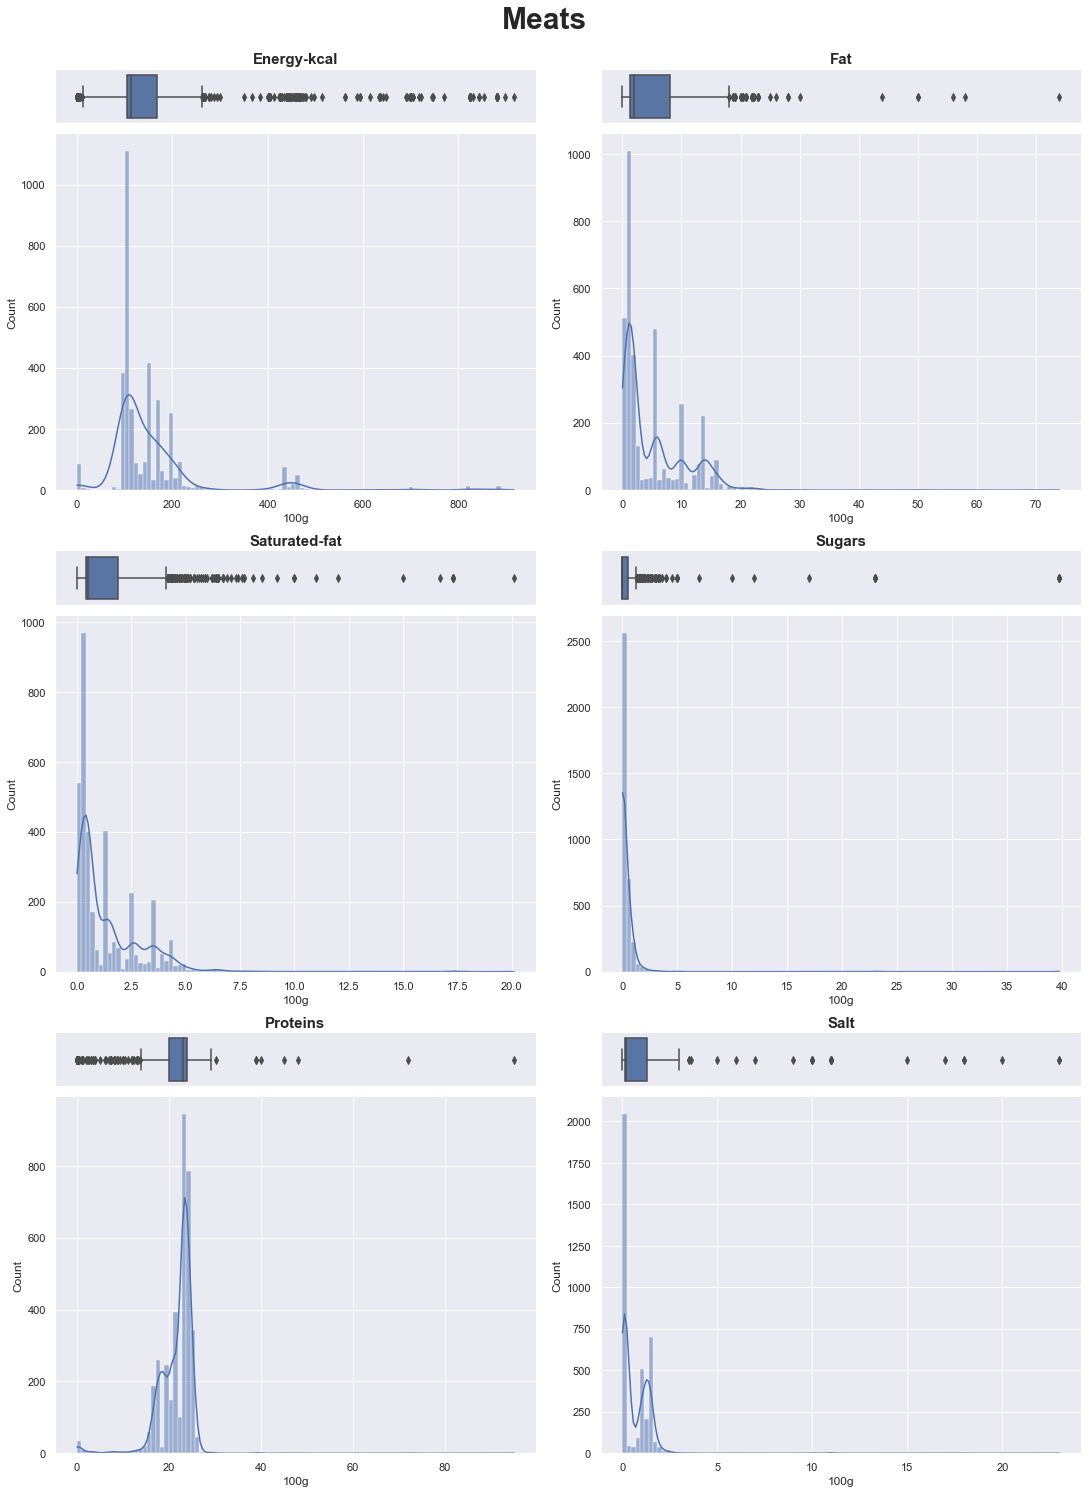

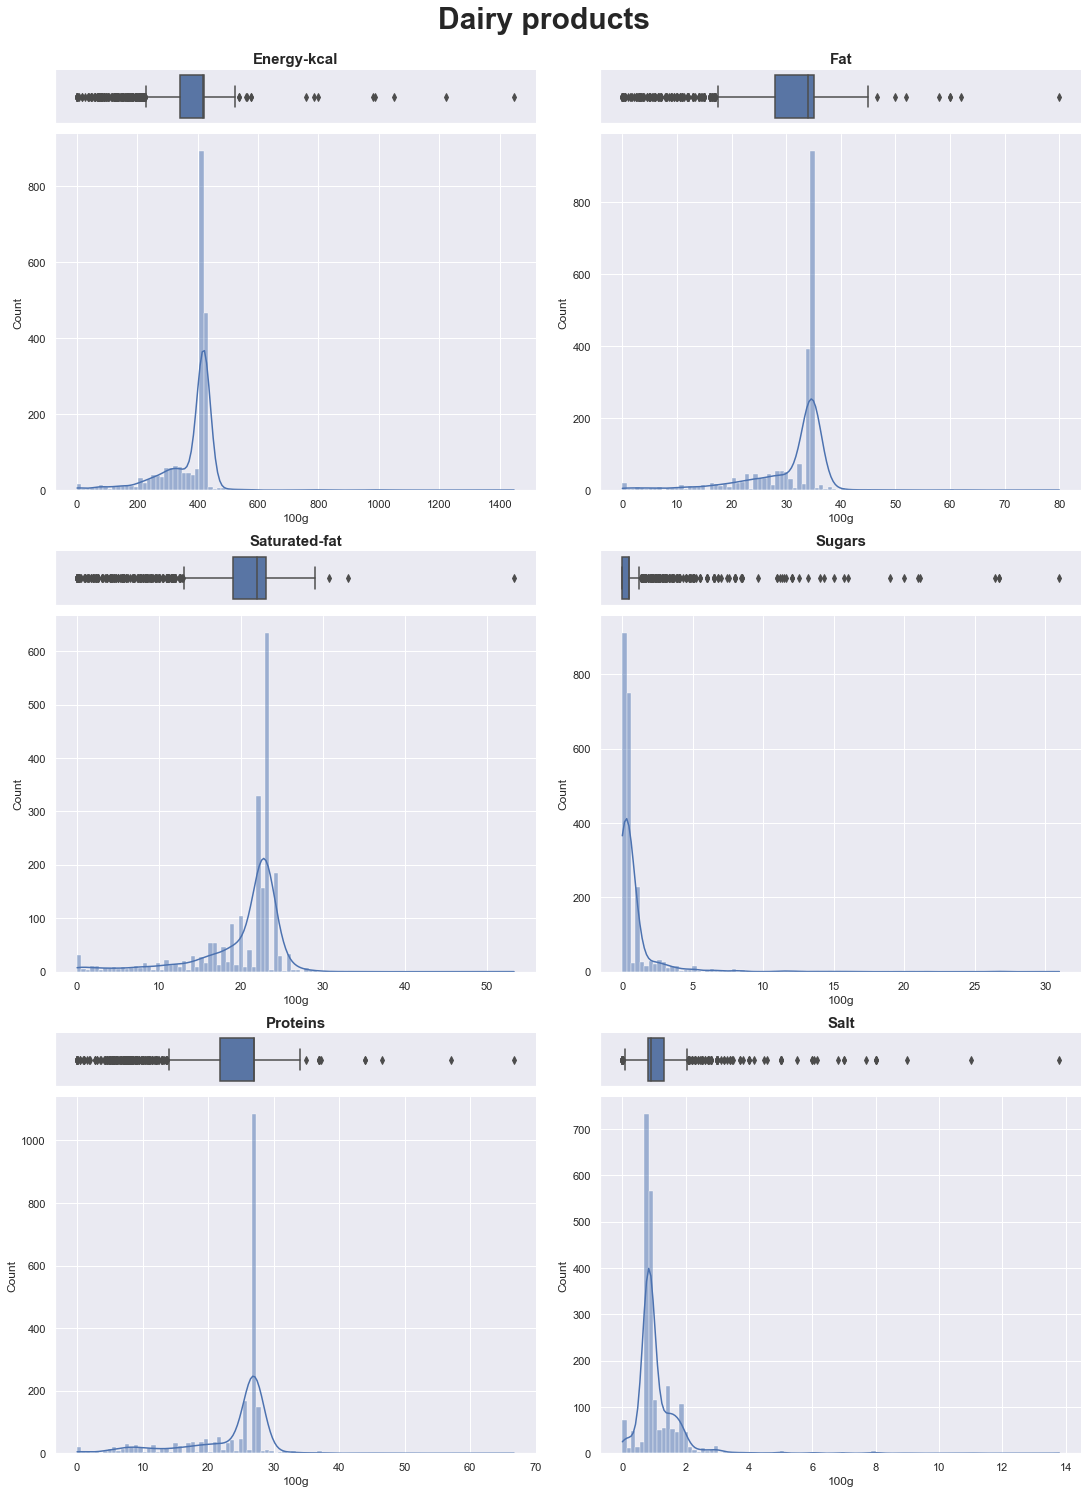

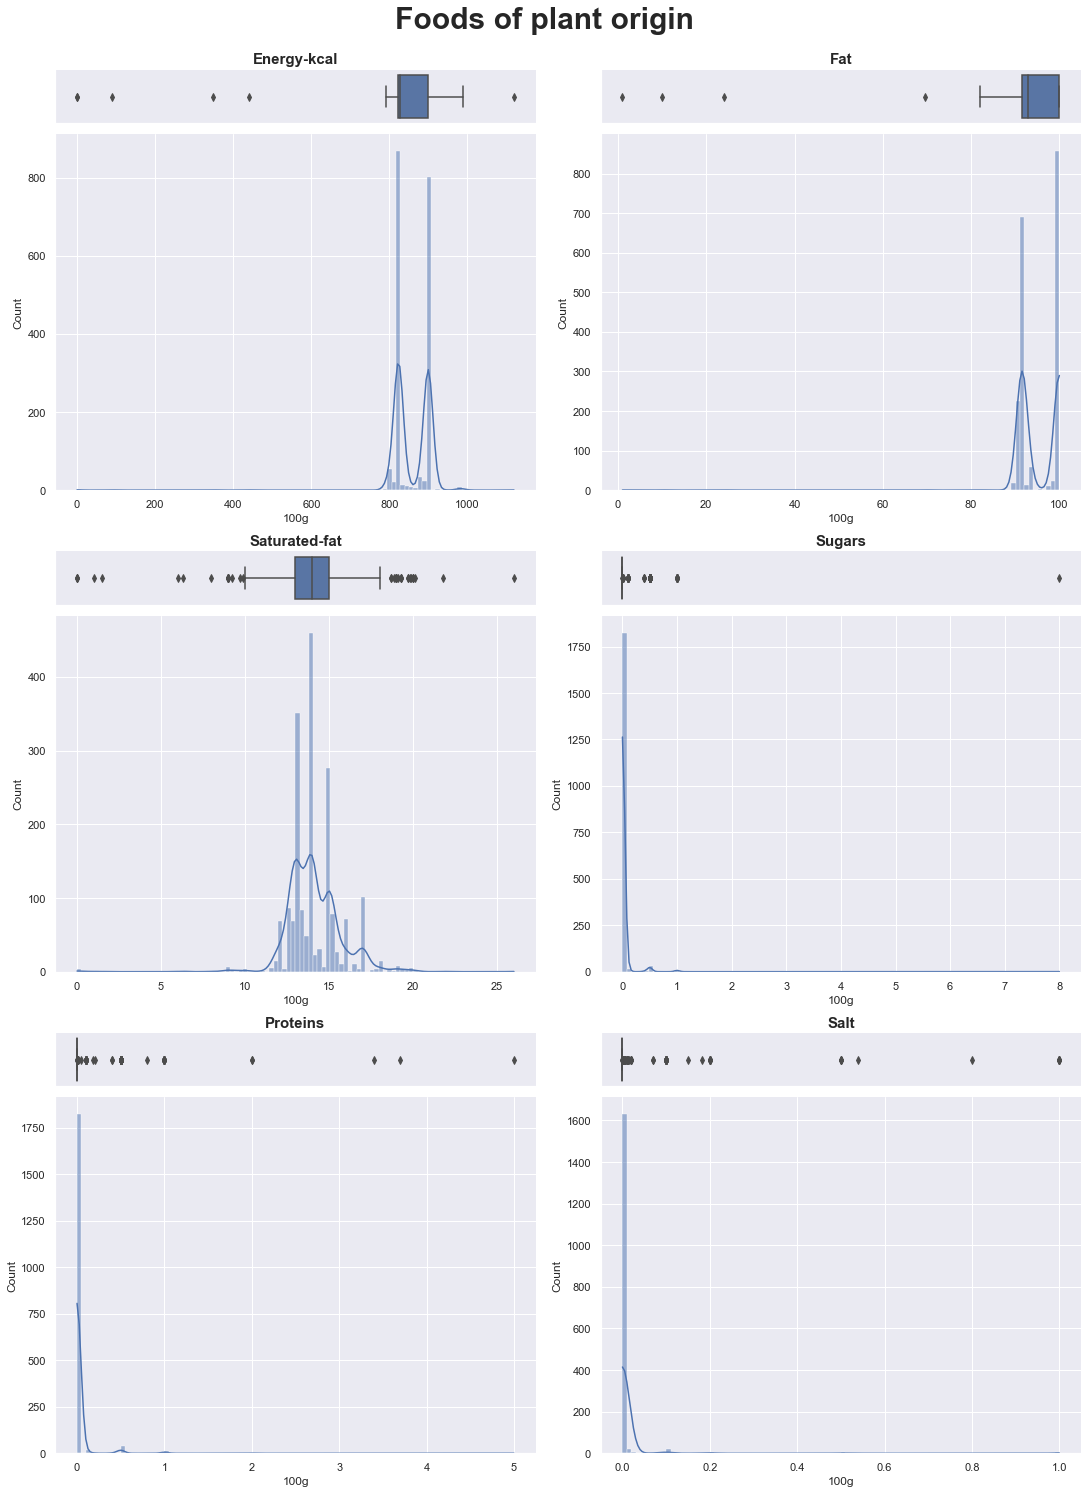

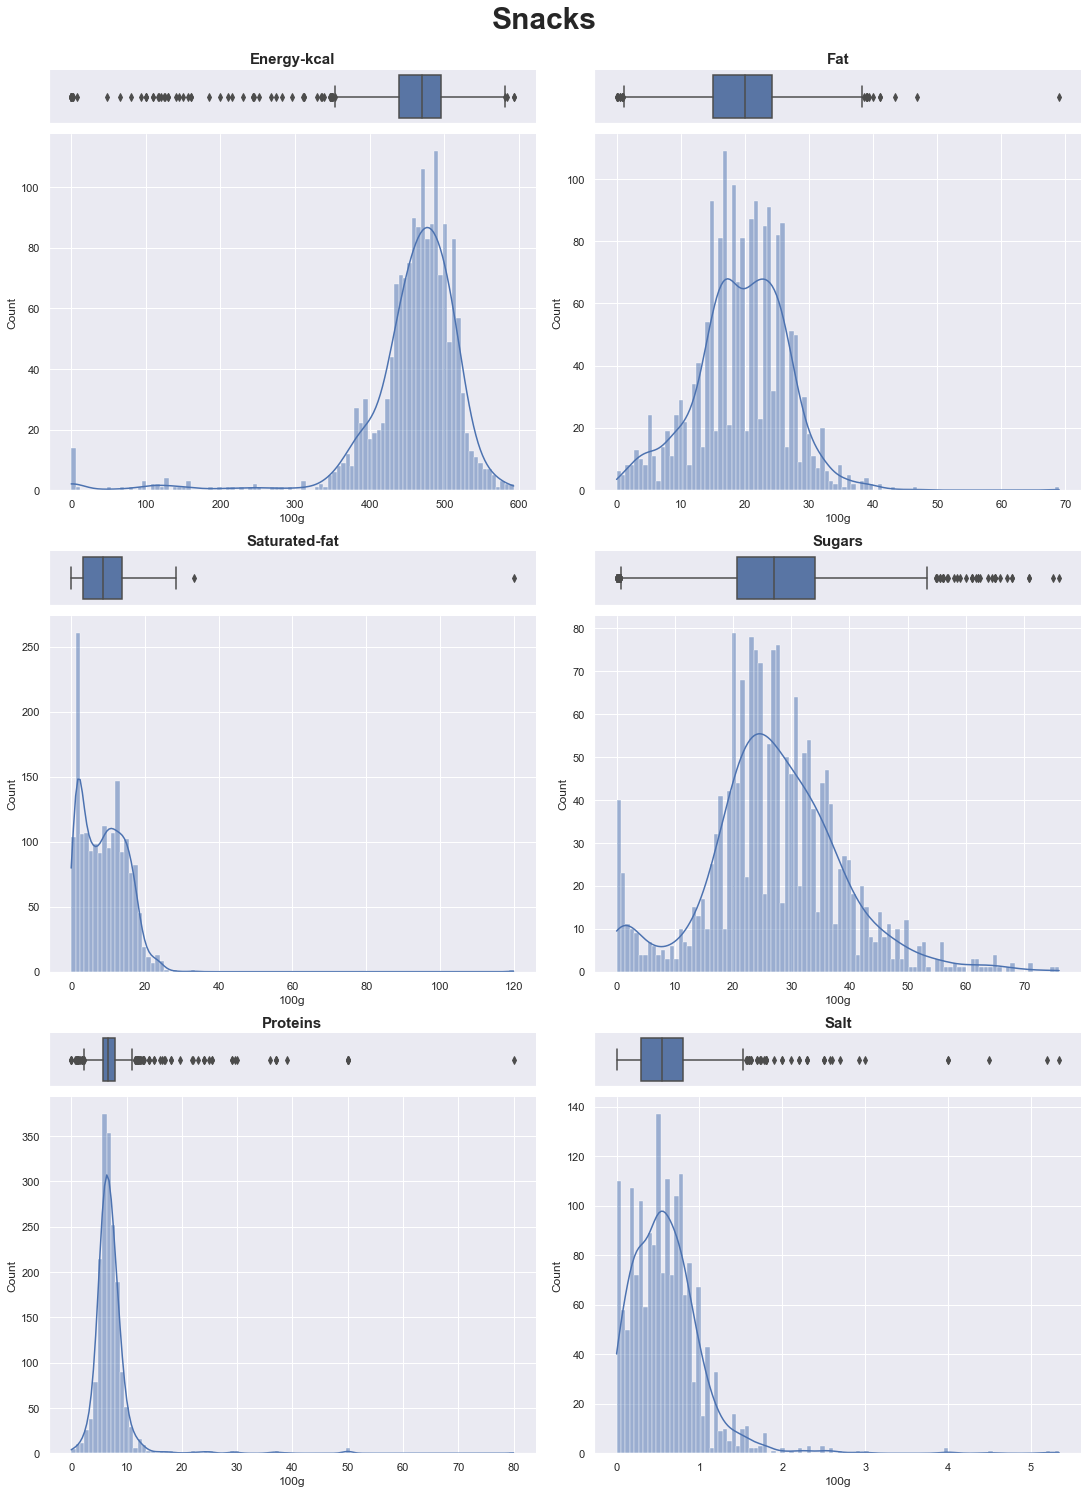

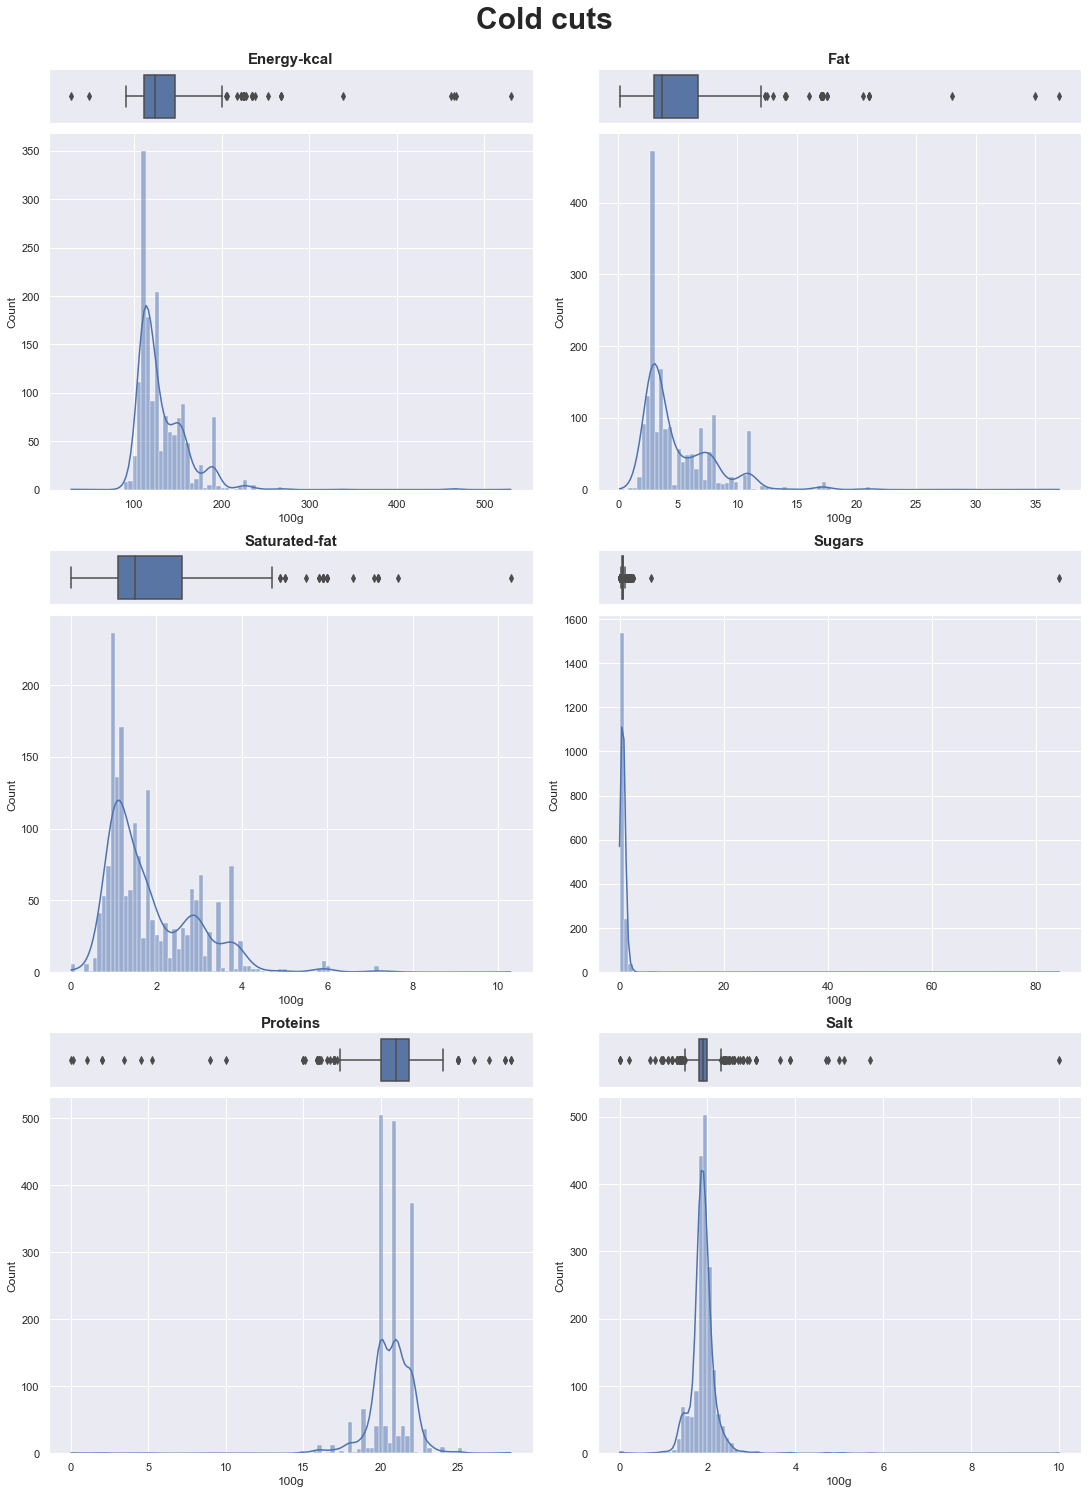

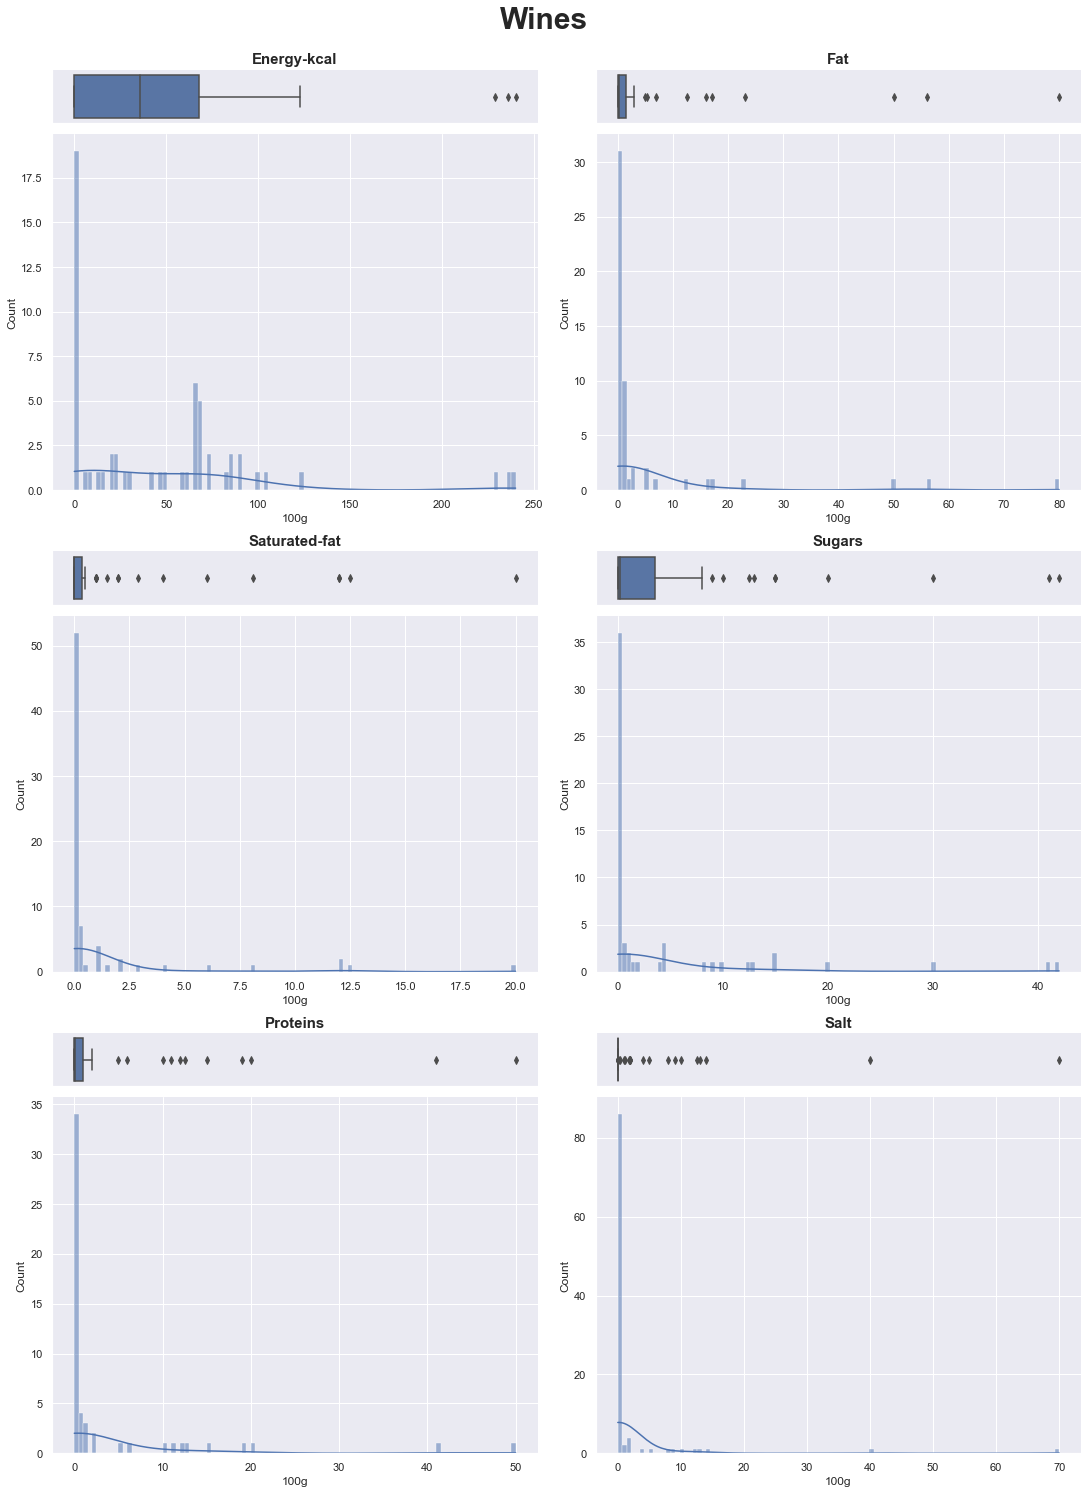

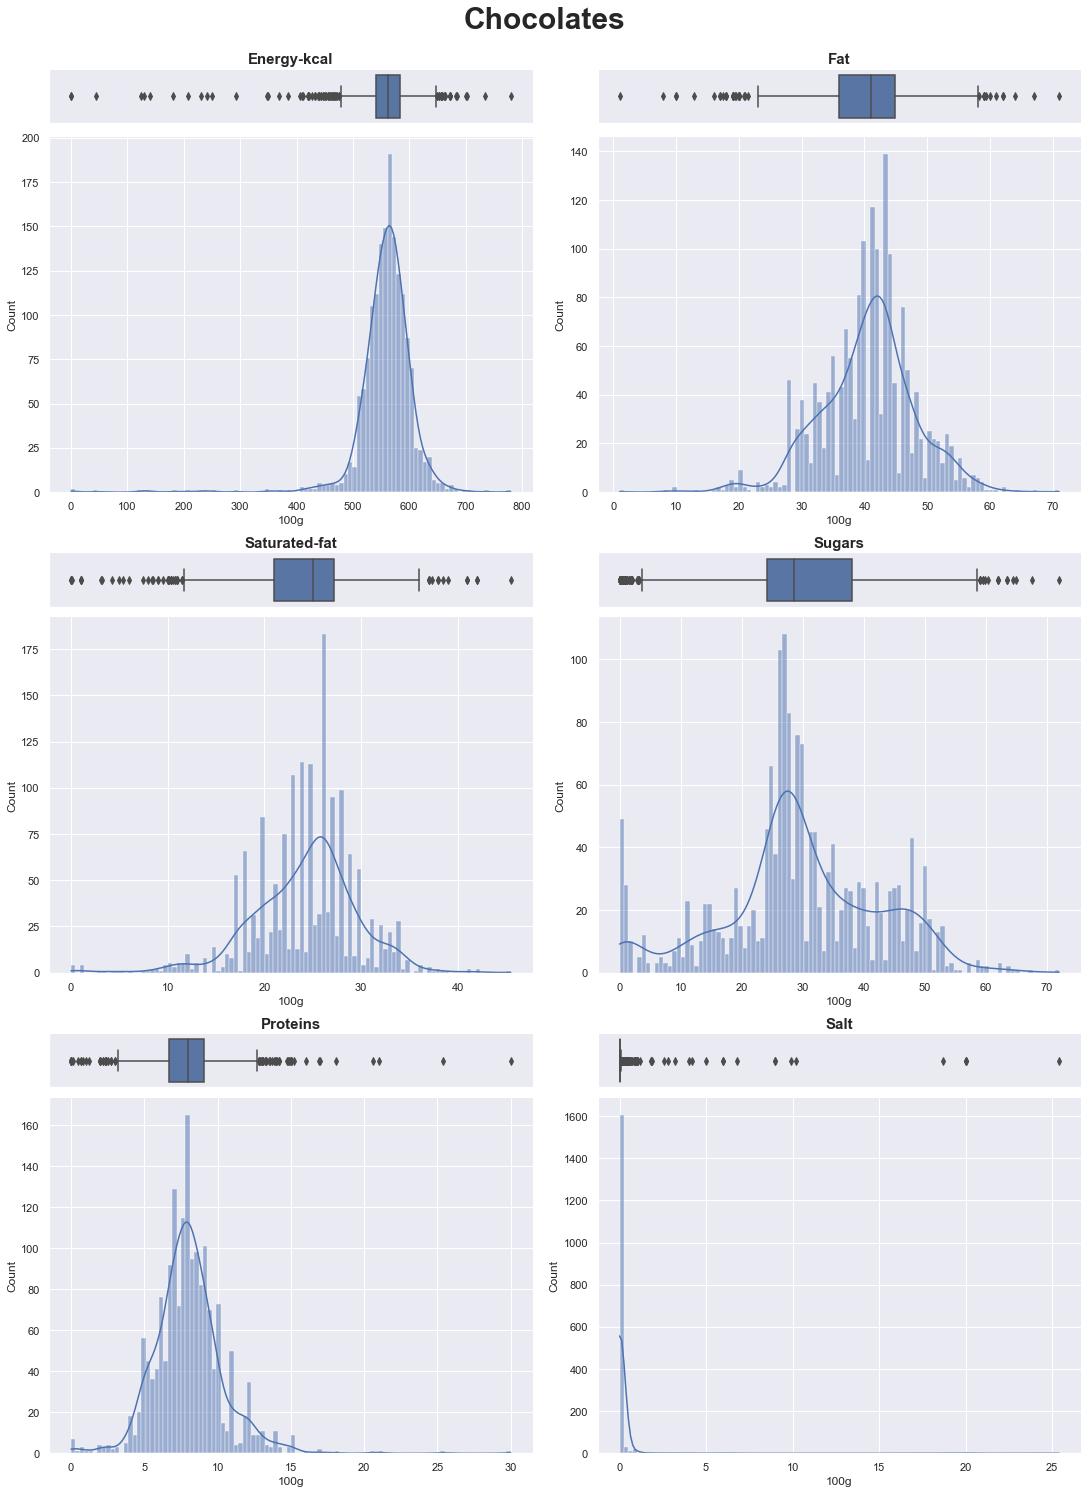

In [123]:
for category in df_with_categories["renamed_category"].unique():
    
    df_temp_by_cat = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    fig = plt.figure(constrained_layout=True, figsize=[15,20])
    fig.suptitle(category, size=30, fontweight="bold", y=1.03)
    spec = fig.add_gridspec(ncols=2, nrows=6, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(6):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(NUMERIC_COLS_APP) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=df_temp_by_cat, x=NUMERIC_COLS_APP[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(NUMERIC_COLS_APP[col_boxplot][0:-5].capitalize(), fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
                if col_histplot > len(NUMERIC_COLS_APP) - 1:
                    break
                
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=df_temp_by_cat, x=NUMERIC_COLS_APP[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel="100g")
                
                col_histplot += 1
    
    plt.savefig("img/nan-" + category + ".png", bbox_inches="tight")
    sns.despine(fig)    

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Treating Outliers with Percentile</h3>
</div>

<div class="alert alert-block alert-info">
   Most of the distribution are not normal so, due to that we are going to treat the outliers through <b>Percentile</b>
</div>

In [124]:
df_without_outliers_by_percentile = pd.DataFrame()

In [125]:
df_with_categories[df_with_categories["renamed_category"] == "Meats"].describe()

energy-kcal_100g     fat_100g  saturated-fat_100g  sugars_100g  \
count       3633.000000  3662.000000         3668.000000  3651.000000   
mean         157.914978     5.061729            1.366267     0.338549   
std          114.306641     5.549040            1.604685     1.630888   
min            0.000000     0.000000            0.000000     0.000000   
25%          105.000000     1.300000            0.400000     0.000000   
50%          114.000000     2.000000            0.515000     0.000000   
75%          168.000000     8.000000            1.900000     0.500000   
max          917.000000    74.000000           20.100000    39.799999   

       proteins_100g    salt_100g  
count    3666.000000  3810.000000  
mean       21.572388     0.708809  
std         4.161459     1.150050  
min         0.000000     0.000000  
25%        20.000000     0.110000  
50%        23.000000     0.190000  
75%        24.000000     1.300000  
max        95.000000    23.000000

<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>percentiles</b>
</div>

In [126]:
for category in df_with_categories["renamed_category"].unique():
    # for each category, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        # Defining threshold max and min by cateogy and
        min_threshold, max_threshold = df_temp_outliers[col].quantile([0.05, 0.95])
        df_temp_outliers.loc[(df_temp_outliers[col] < min_threshold) | (df_temp_outliers[col] > max_threshold), col] = np.nan
        
    df_without_outliers_by_percentile = pd.concat([df_without_outliers_by_percentile, df_temp_outliers])

In [127]:
df_without_outliers_by_percentile[df_without_outliers_by_percentile["renamed_category"] == "Meats"].describe()

energy-kcal_100g     fat_100g  saturated-fat_100g  sugars_100g  \
count       3365.000000  3359.000000         3538.000000  3470.000000   
mean         143.748856     4.542225            1.188207     0.181145   
std           61.803223     4.400768            1.203501     0.290831   
min           95.000000     0.500000            0.000000     0.000000   
25%          105.000000     1.300000            0.400000     0.000000   
50%          114.000000     2.000000            0.500000     0.000000   
75%          168.000000     6.125000            1.700000     0.400000   
max          440.000000    15.000000            4.300000     1.000000   

       proteins_100g    salt_100g  
count    3416.000000  3619.000000  
mean       22.037914     0.581497  
std         2.374524     0.559096  
min        16.799999     0.000000  
25%        20.942501     0.110000  
50%        23.000000     0.180000  
75%        24.000000     1.100000  
max        25.000000     1.530000

In [128]:
df_analysis(df_without_outliers_by_percentile, "df_without_outliers_by_percentile", "code")


Analysis of df_without_outliers_by_percentile dataset
--------------------------------------------------------------------
- Dataset shape:                  17328 rows and 13 columns
- Total of NaN values:            32089
- Percentage of NaN:              14.25 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.2+ MB )
--------------------------------------------------------------------


name            type  records  # NaN  % NaN
0                     code          object    17328      0   0.00
1   last_modified_datetime  datetime64[ns]    17328      0   0.00
3               categories        category    17328      0   0.00
4            main_category        category    17328      0   0.00
5         renamed_category          object    17328      0   0.00
2             product_name          object    17282     46   0.27
6                image_url          object    16549    779   4.50
9       saturated-fat_100g         float32    12265   5063  29.22
10             sugars_100g         float32    12259   5069  29.25
12               salt_100g         float32    12257   5071  29.26
8                 fat_100g         float32    12215   5113  29.51
11           proteins_100g         float32    12173   5155  29.75
7         energy-kcal_100g         float32    11535   5793  33.43

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Treating Outliers with Z Score</h3>
</div>

<div class="alert alert-block alert-info">
    Calculating the <b>Z Score</b> to work on outliers
</div>

In [129]:
df_without_outliers_by_zscore = pd.DataFrame()

In [130]:
df_with_categories[df_with_categories["renamed_category"] == "Dairy products"].describe()

energy-kcal_100g     fat_100g  saturated-fat_100g  sugars_100g  \
count       2145.000000  2181.000000         2179.000000  2184.000000   
mean         374.316650    30.512157           19.988377     0.851046   
std           97.758202     7.894668            5.529278     2.114449   
min            0.000000     0.000000            0.000000     0.000000   
25%          342.000000    28.000000           19.000000     0.000000   
50%          417.000000    34.000000           22.000000     0.500000   
75%          419.000000    35.000000           23.000000     0.500000   
max         1448.000000    80.000000           53.299999    31.000000   

       proteins_100g    salt_100g  
count    2189.000000  2187.000000  
mean       23.372145     1.104489  
std         6.900639     0.828836  
min         0.000000     0.000000  
25%        21.799999     0.800000  
50%        27.000000     0.900000  
75%        27.000000     1.300000  
max        66.699997    13.800000

<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>Z Score</b>
</div>

In [131]:
for category in df_with_categories["renamed_category"].unique():
    # for each category, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        # Defining the Z Score
        df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
        df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan
        del df_temp_outliers[col + "_zscore"]
        
    df_without_outliers_by_zscore = pd.concat([df_without_outliers_by_zscore, df_temp_outliers])

In [132]:
df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == "Dairy products"].describe()

energy-kcal_100g     fat_100g  saturated-fat_100g  sugars_100g  \
count       2092.000000  2116.000000         2111.000000  2147.000000   
mean         379.181763    31.220186           20.571785     0.631572   
std           74.752907     6.239563            4.397067     1.018477   
min           82.000000     6.900000            3.500000     0.000000   
25%          350.750000    29.000000           19.000000     0.000000   
50%          417.000000    34.000000           22.400000     0.500000   
75%          419.000000    35.000000           23.000000     0.500000   
max          576.000000    52.000000           33.000000     7.000000   

       proteins_100g    salt_100g  
count    2158.000000  2156.000000  
mean       23.624199     1.032058  
std         6.302427     0.503604  
min         2.700000     0.000000  
25%        22.000000     0.800000  
50%        27.000000     0.900000  
75%        27.000000     1.200000  
max        44.000000     3.500000

In [133]:
df_analysis(df_without_outliers_by_zscore, "df_without_outliers_by_zscore", "code")


Analysis of df_without_outliers_by_zscore dataset
--------------------------------------------------------------------
- Dataset shape:                  17328 rows and 13 columns
- Total of NaN values:            27592
- Percentage of NaN:              12.25 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.2+ MB )
--------------------------------------------------------------------


name            type  records  # NaN  % NaN
0                     code          object    17328      0   0.00
1   last_modified_datetime  datetime64[ns]    17328      0   0.00
3               categories        category    17328      0   0.00
4            main_category        category    17328      0   0.00
5         renamed_category          object    17328      0   0.00
2             product_name          object    17282     46   0.27
6                image_url          object    16549    779   4.50
10             sugars_100g         float32    13018   4310  24.87
8                 fat_100g         float32    12971   4357  25.14
12               salt_100g         float32    12955   4373  25.24
11           proteins_100g         float32    12948   4380  25.28
9       saturated-fat_100g         float32    12944   4384  25.30
7         energy-kcal_100g         float32    12365   4963  28.64

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Comparison of Outliers treatment</h3>
</div>

<div class="alert alert-block alert-info">
    <b>Plotting</b> the comparison between data before and after treating <b>outliers</b> with <b>percentiles</b>
</div>

C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Samir\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
<ipython-input-134-1f6a49d8c83b>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots(nrows=2, ncols=3, figsize=[18,8], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})


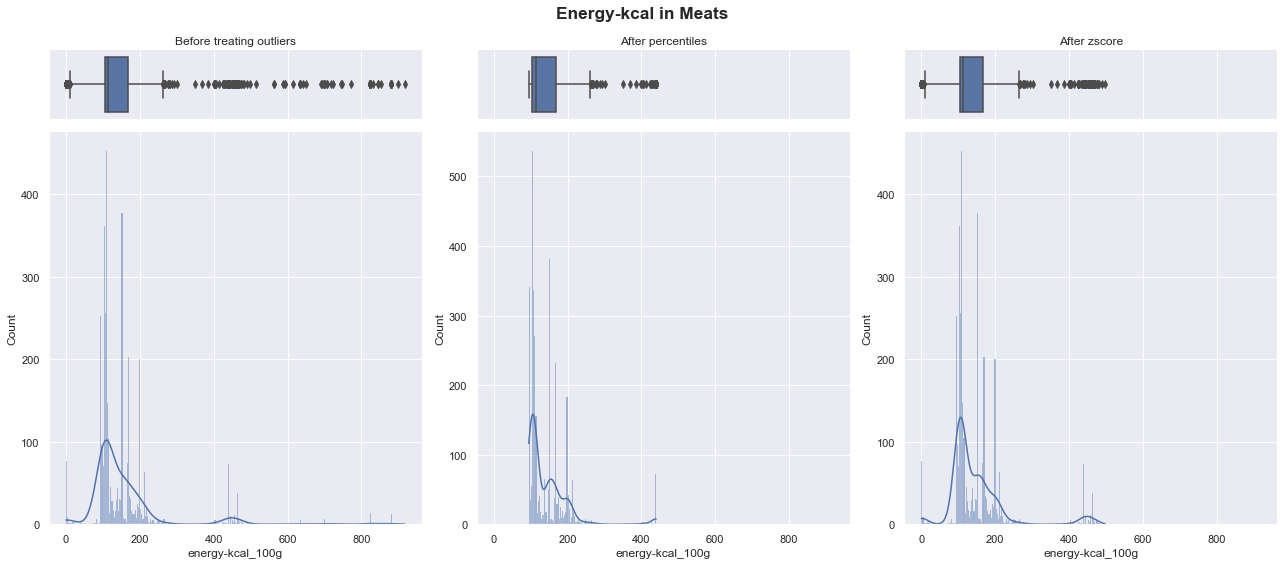

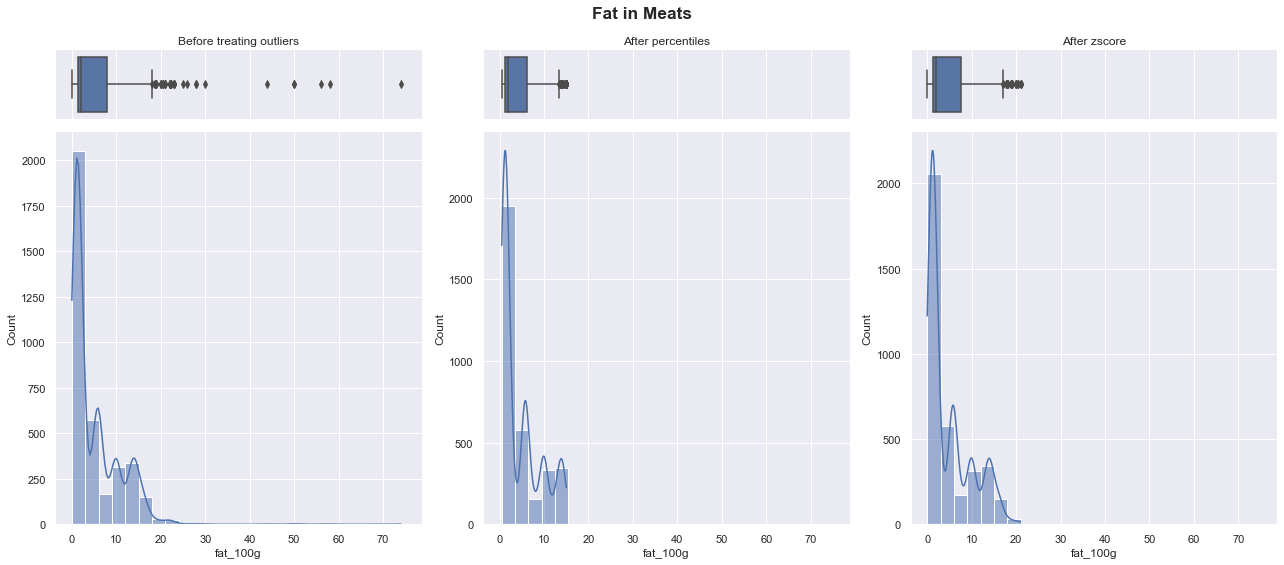

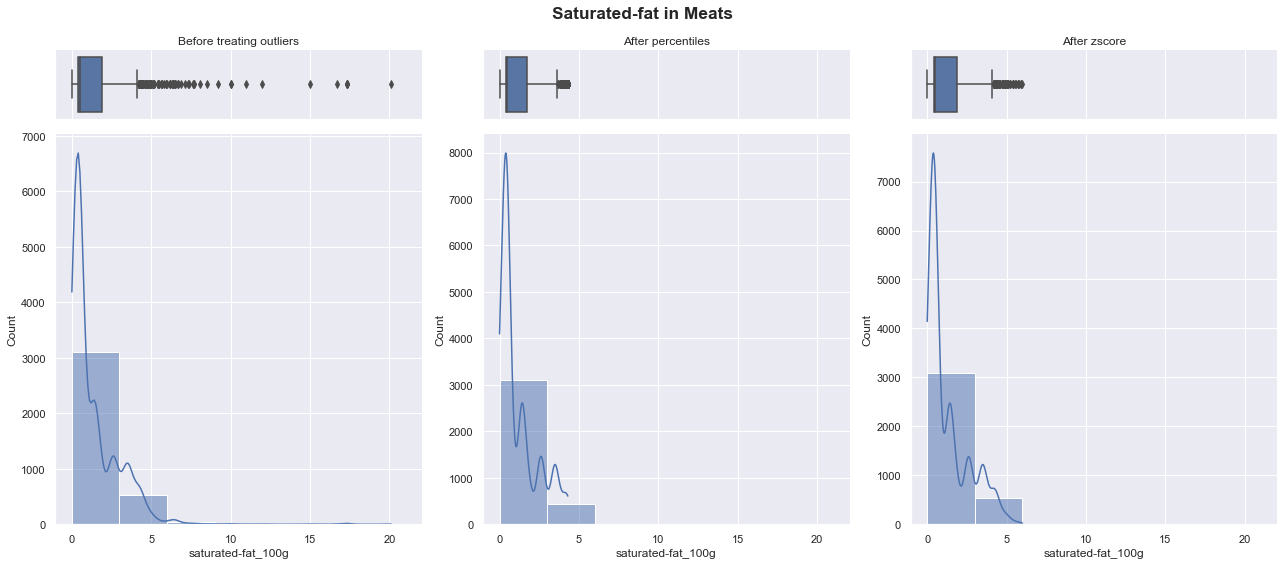

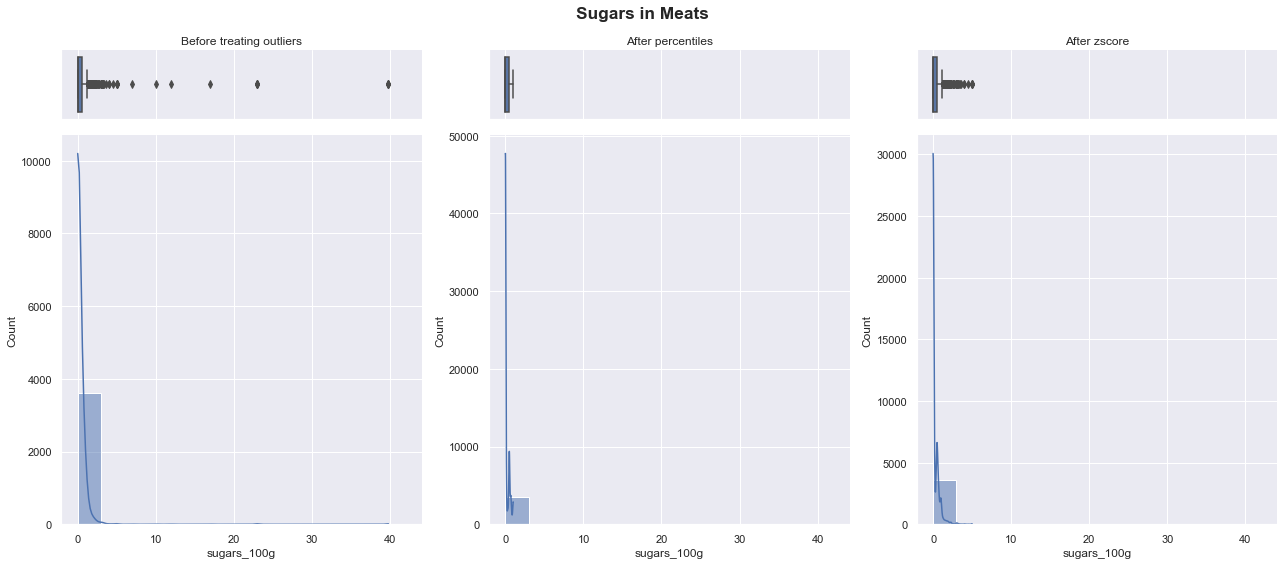

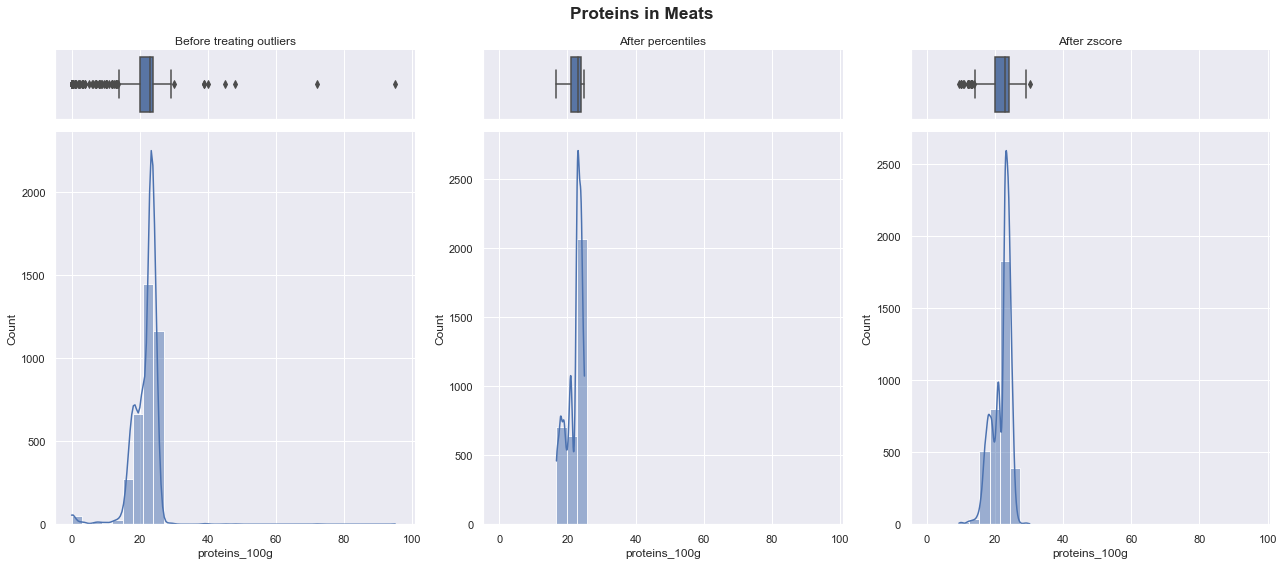

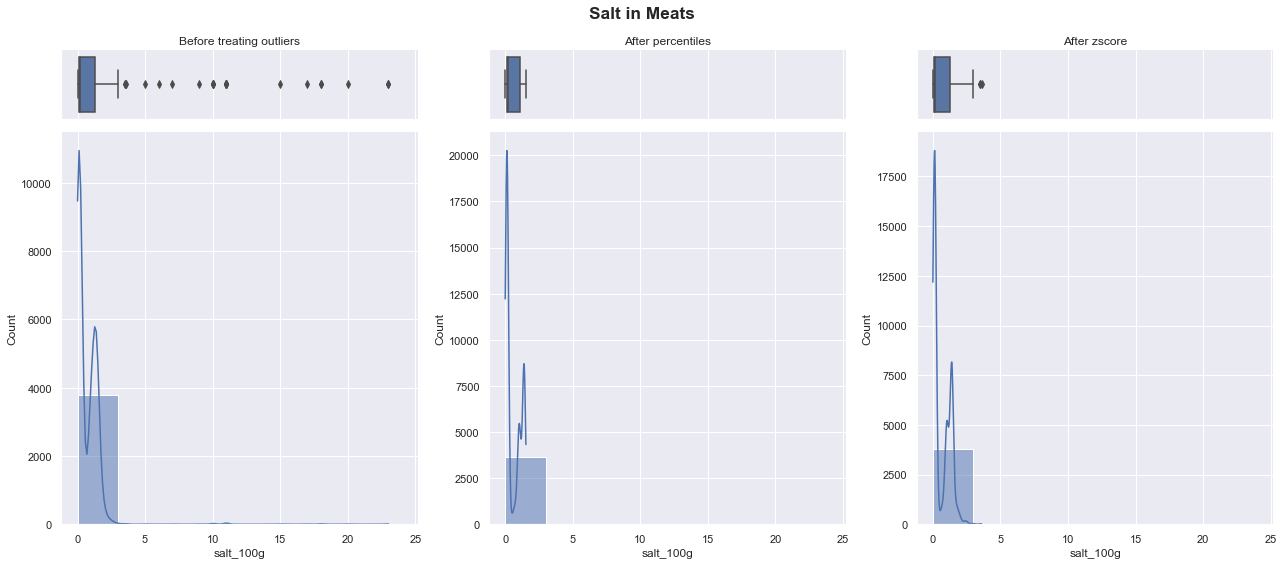

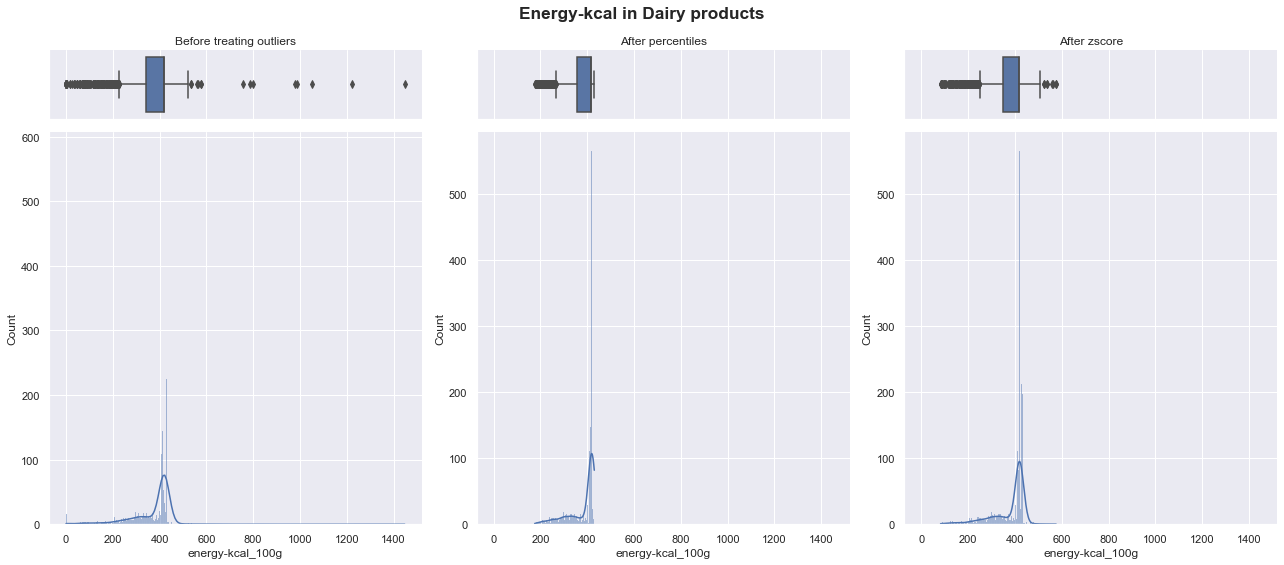

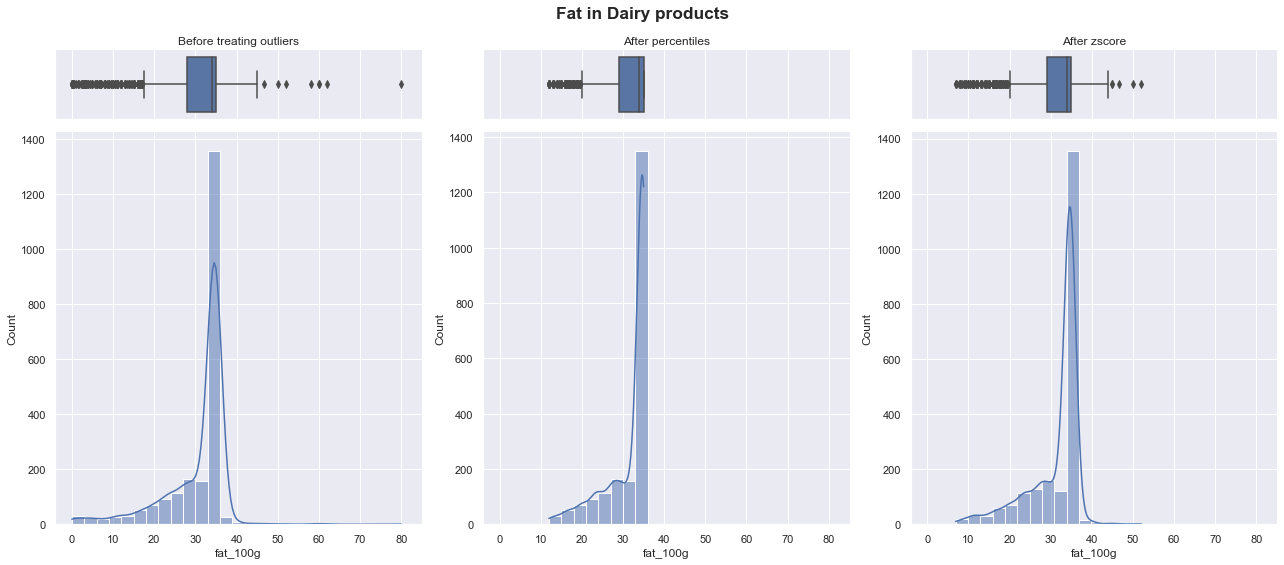

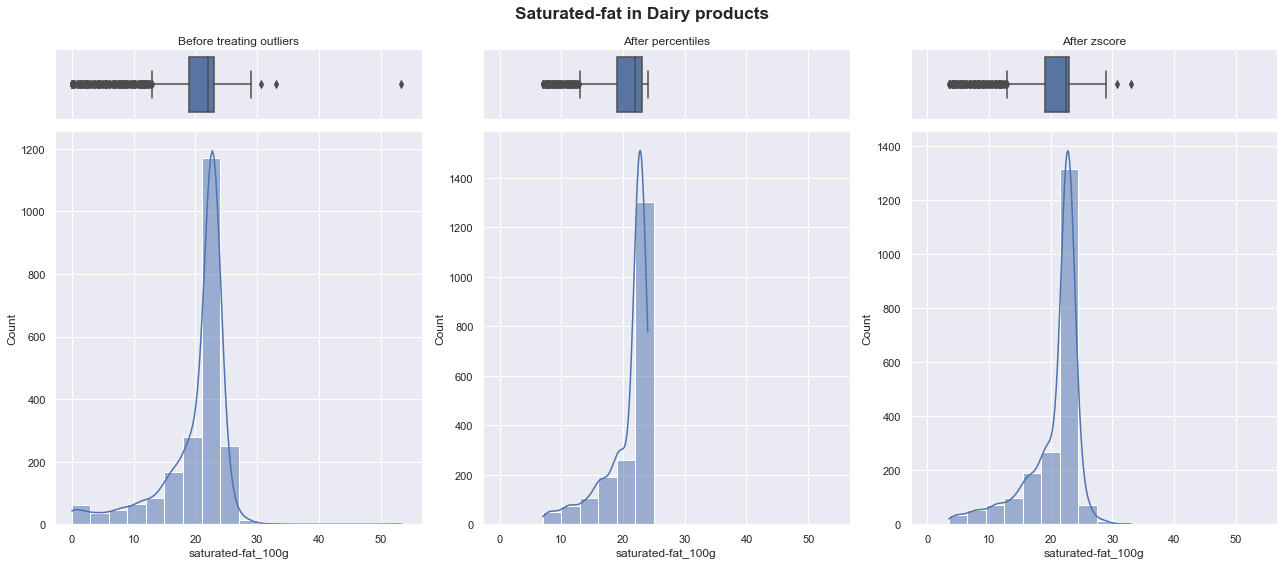

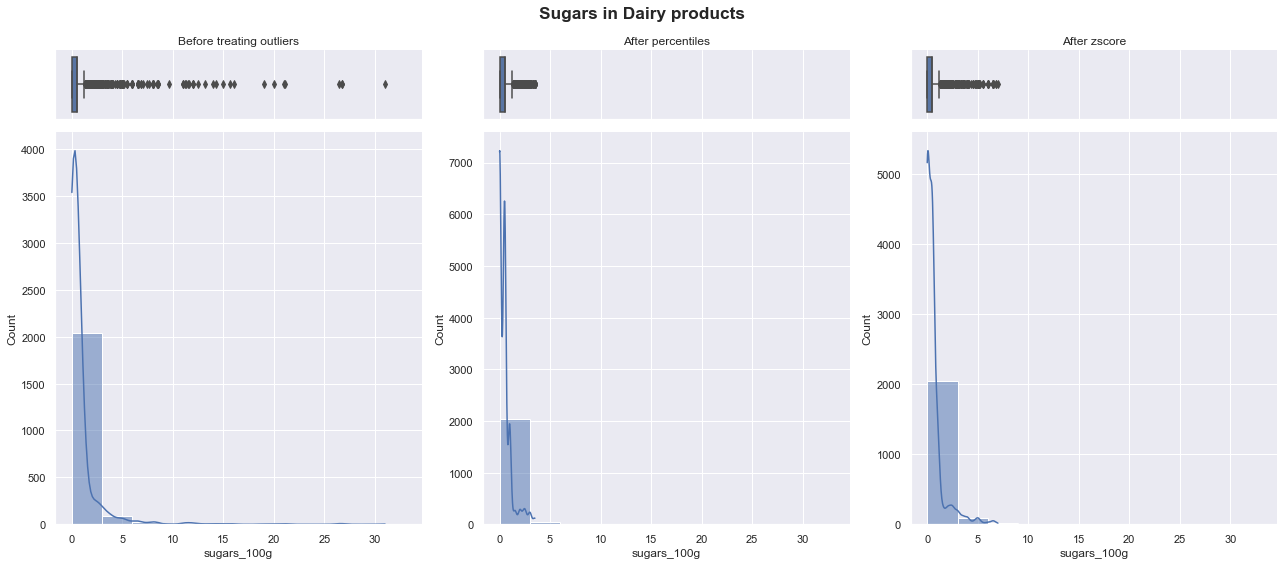

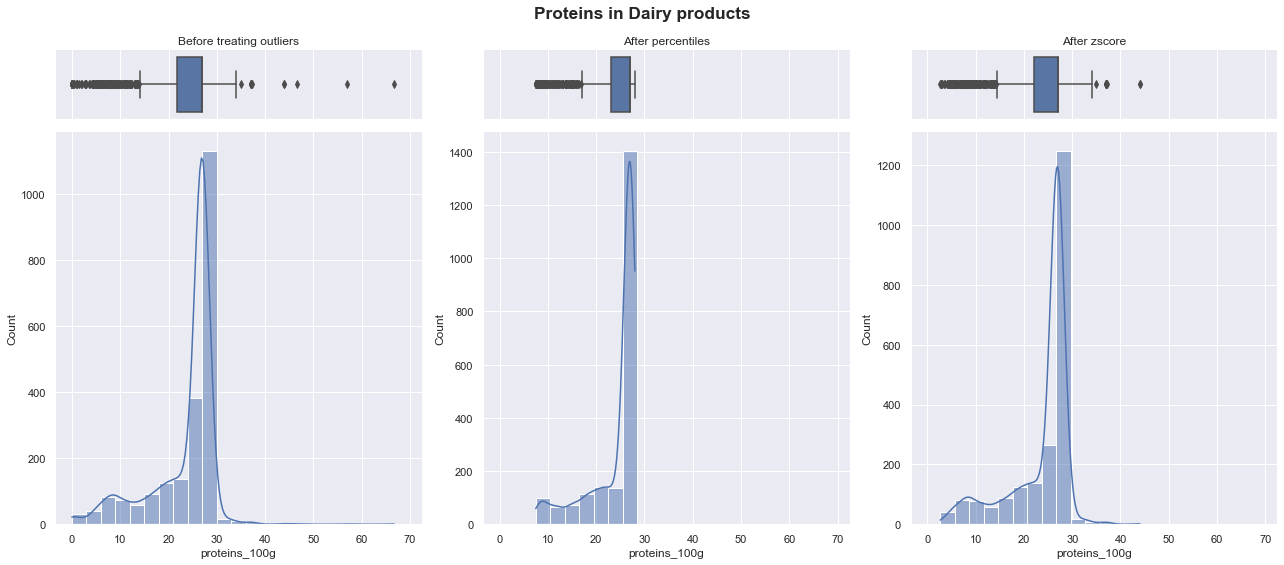

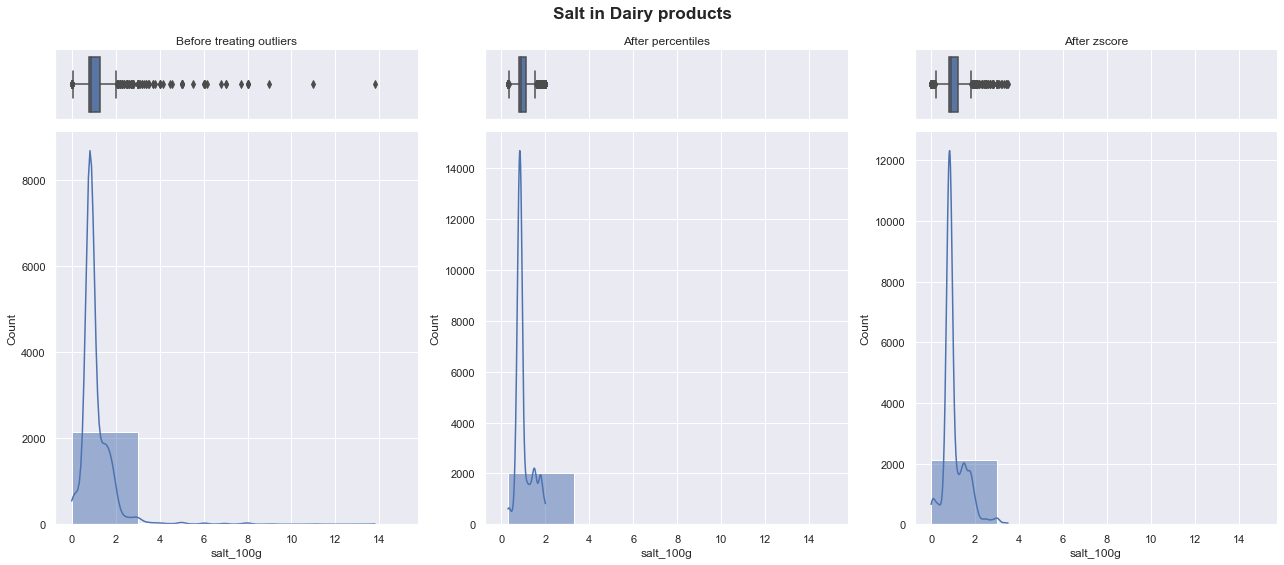

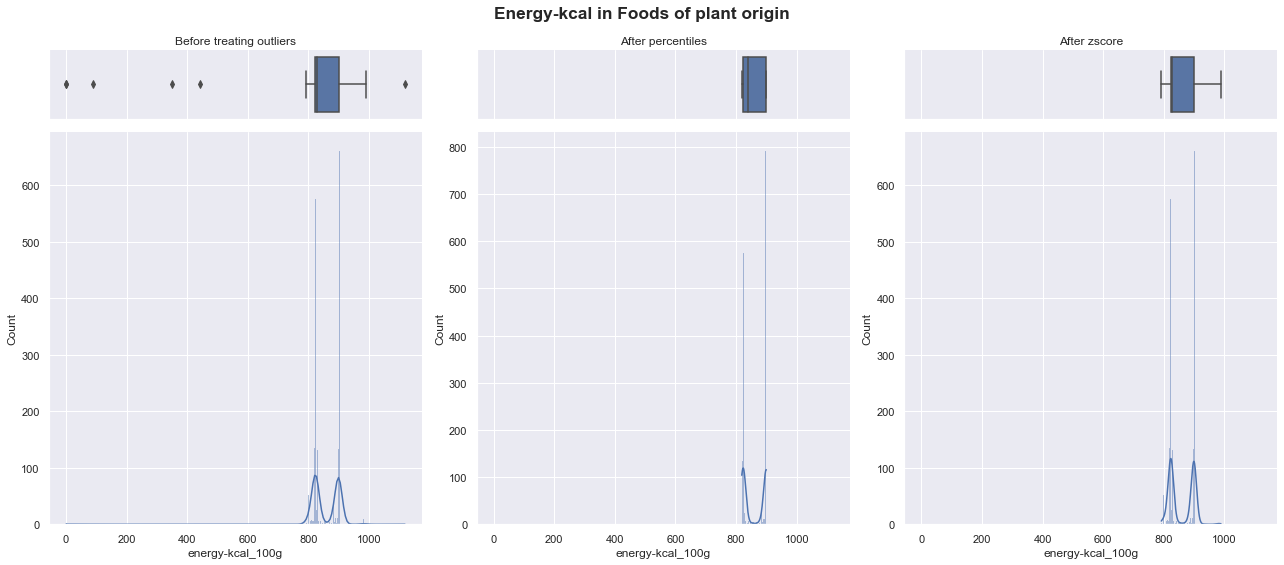

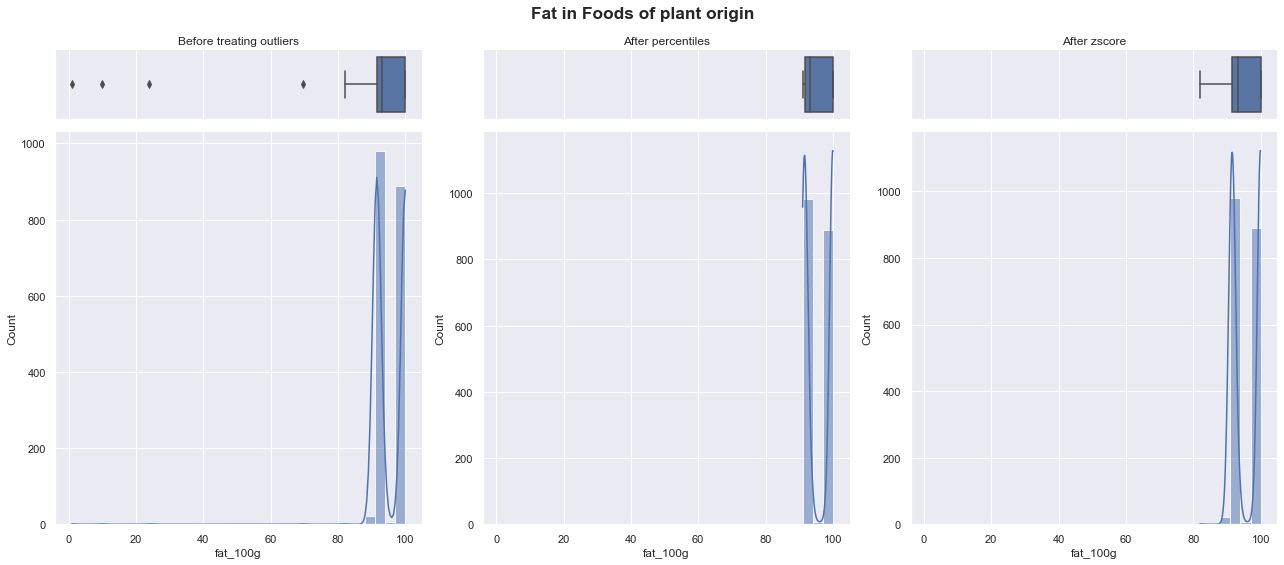

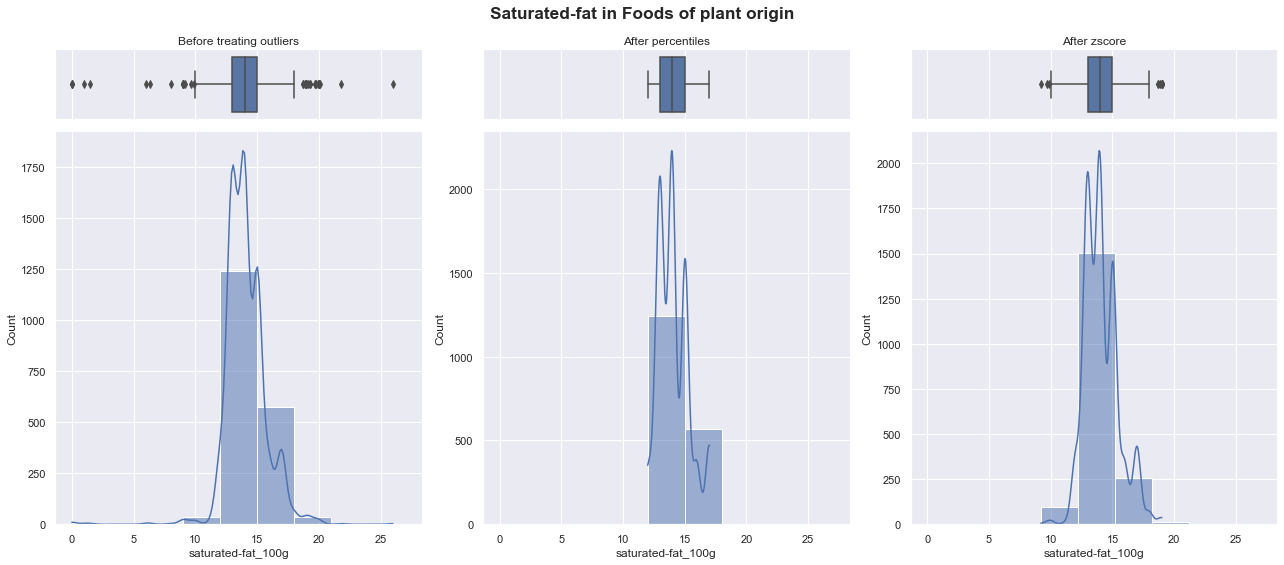

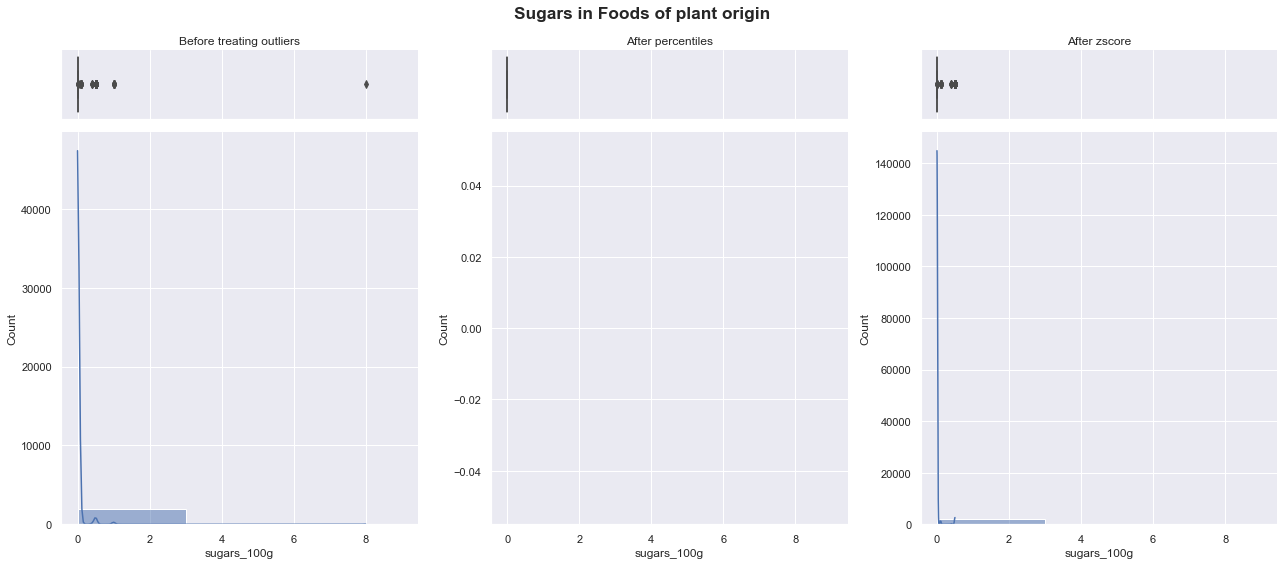

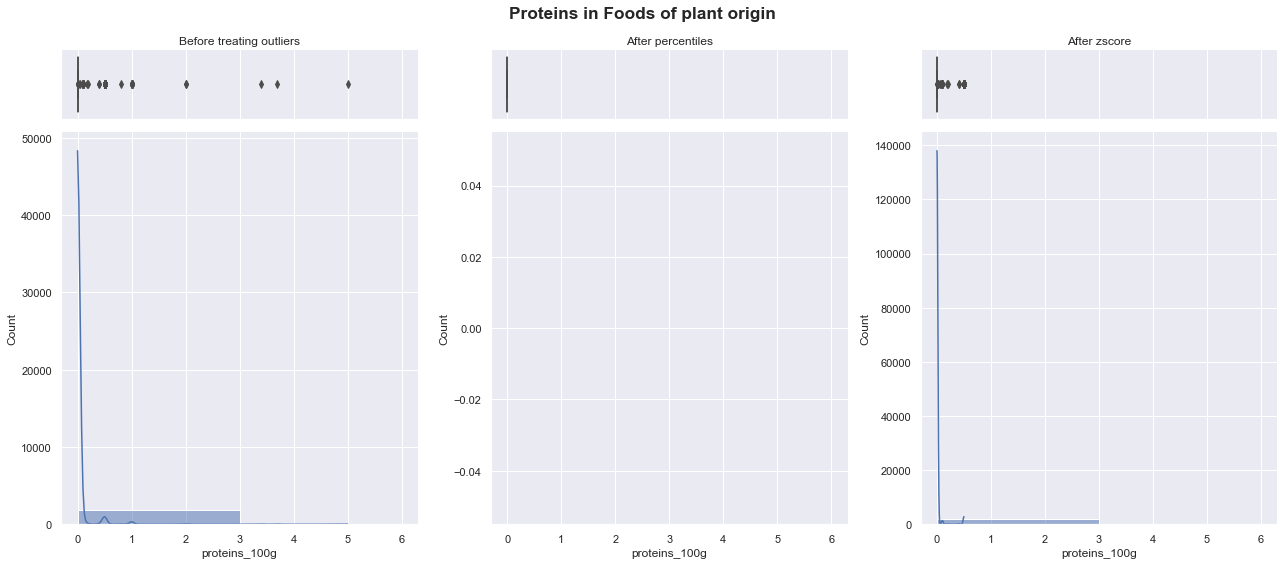

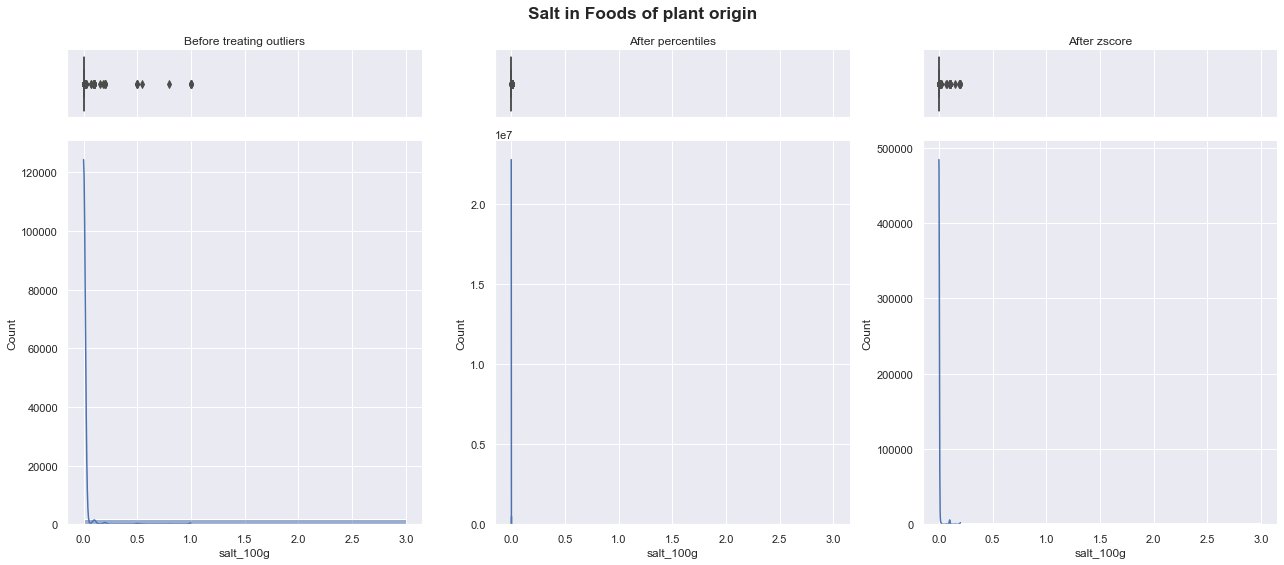

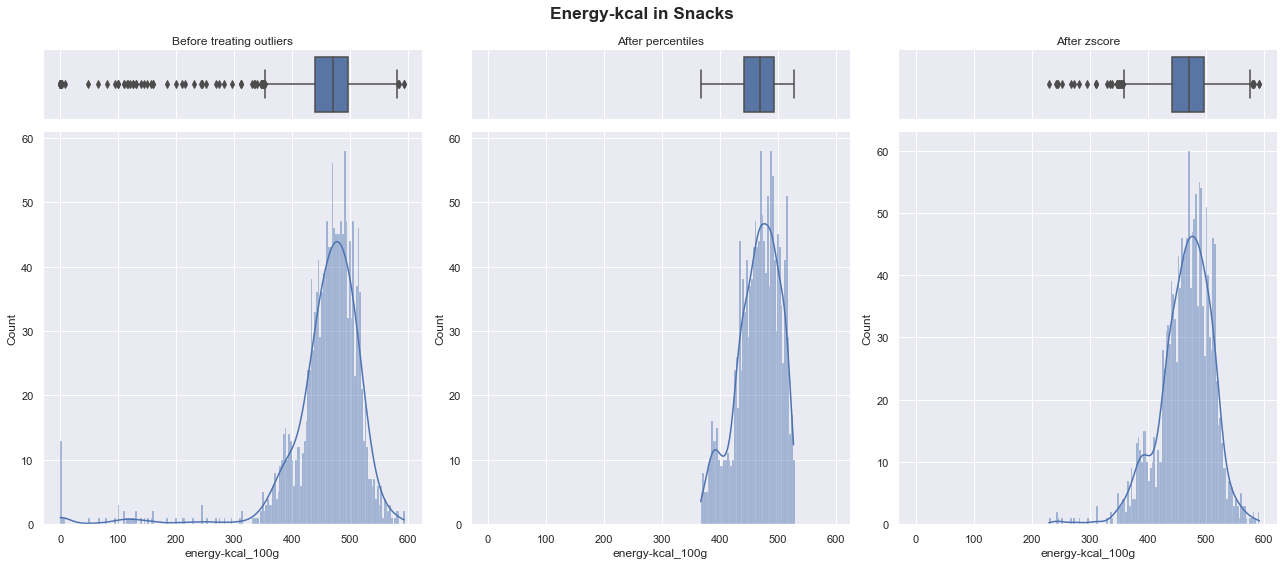

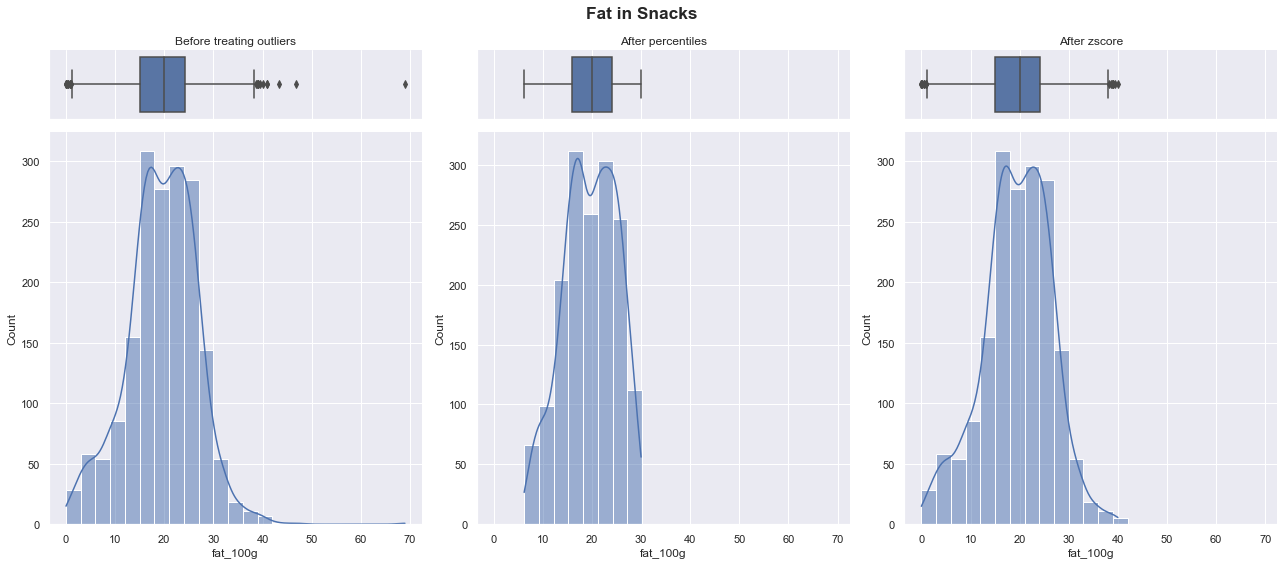

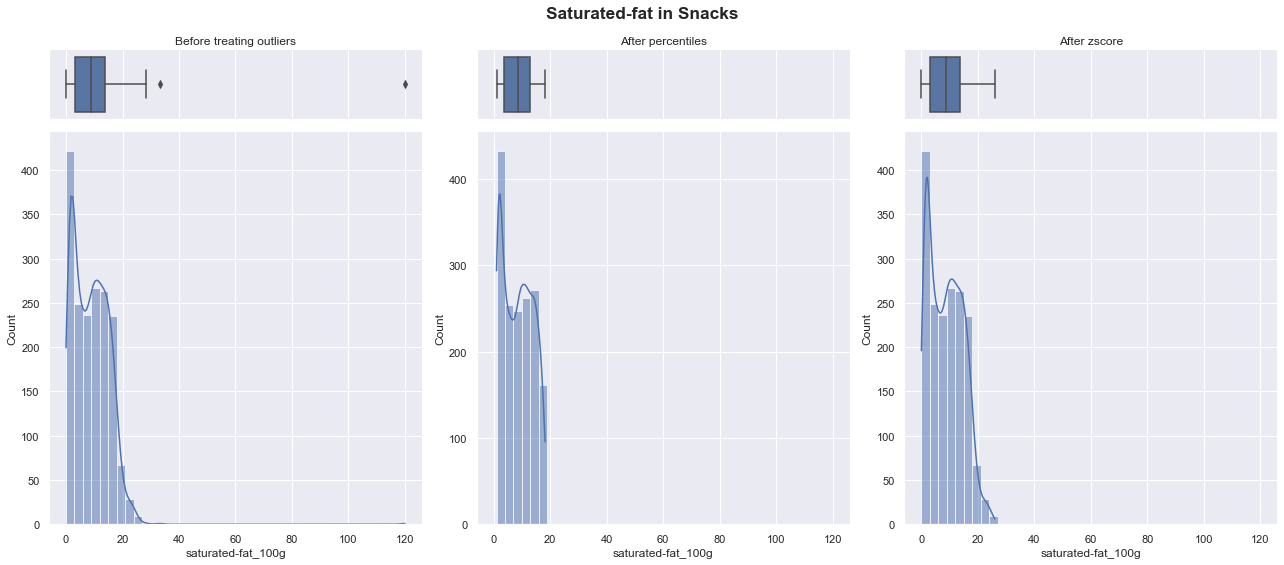

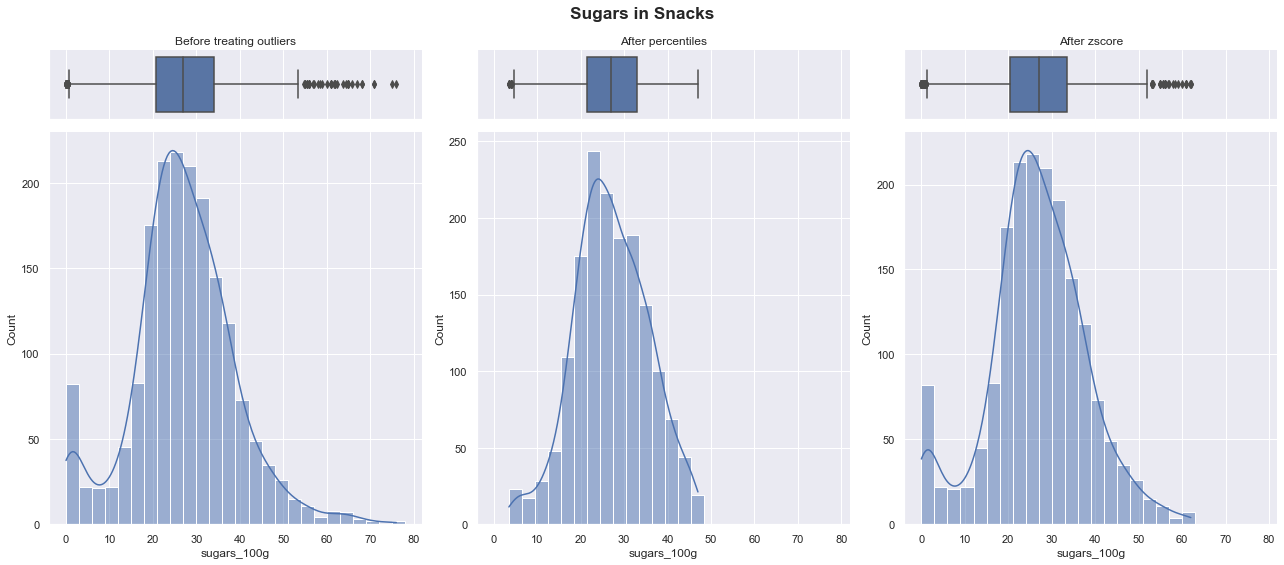

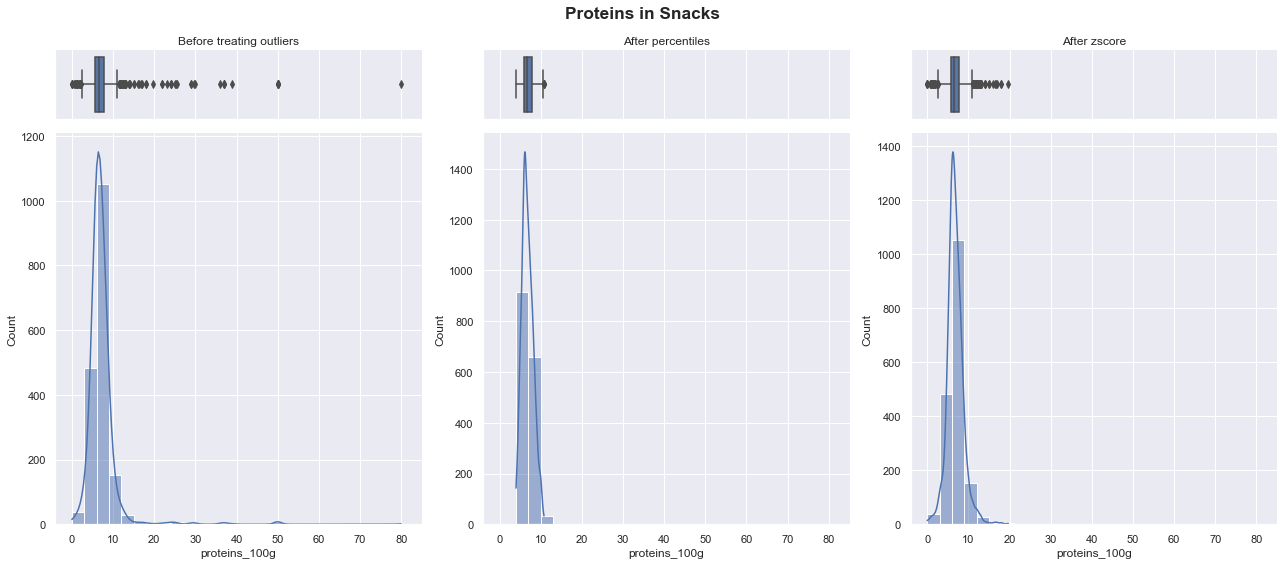

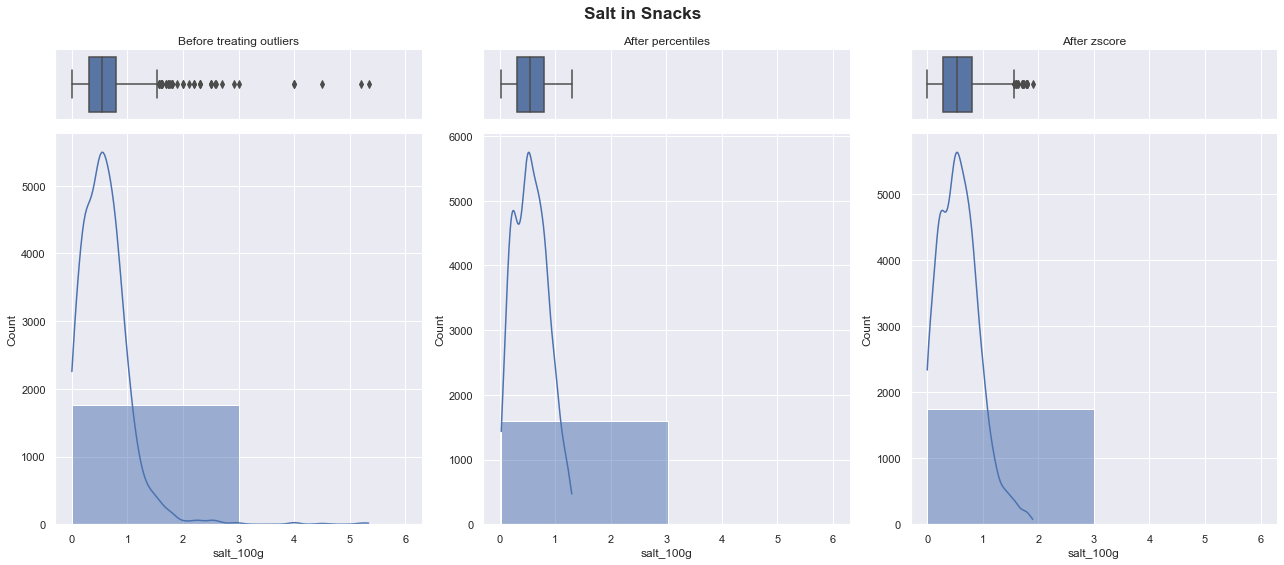

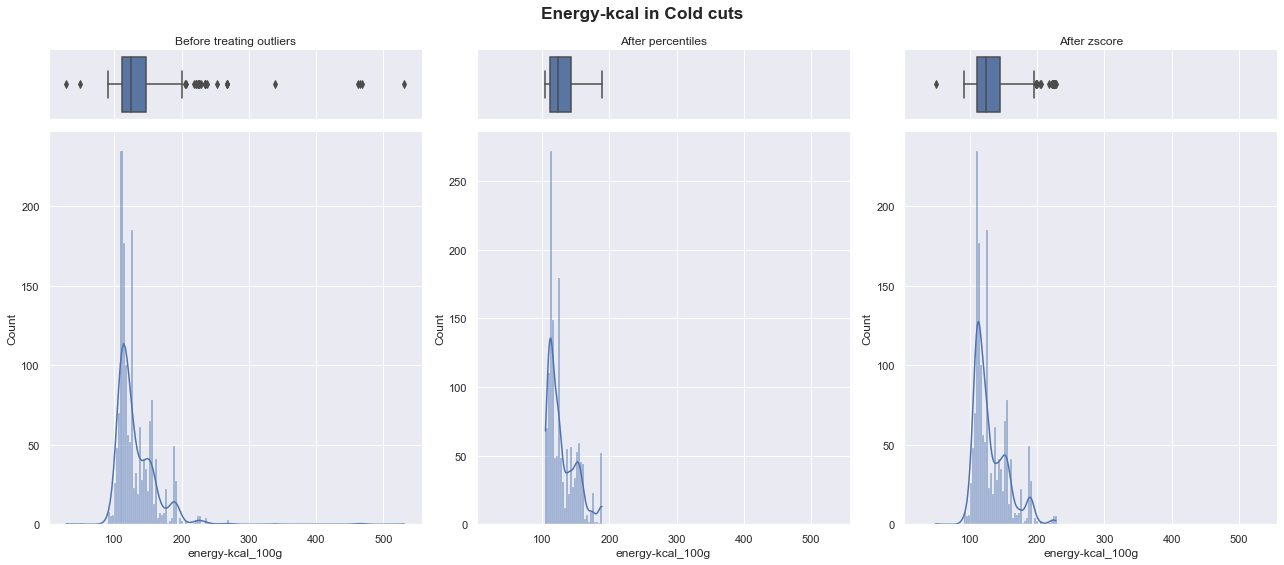

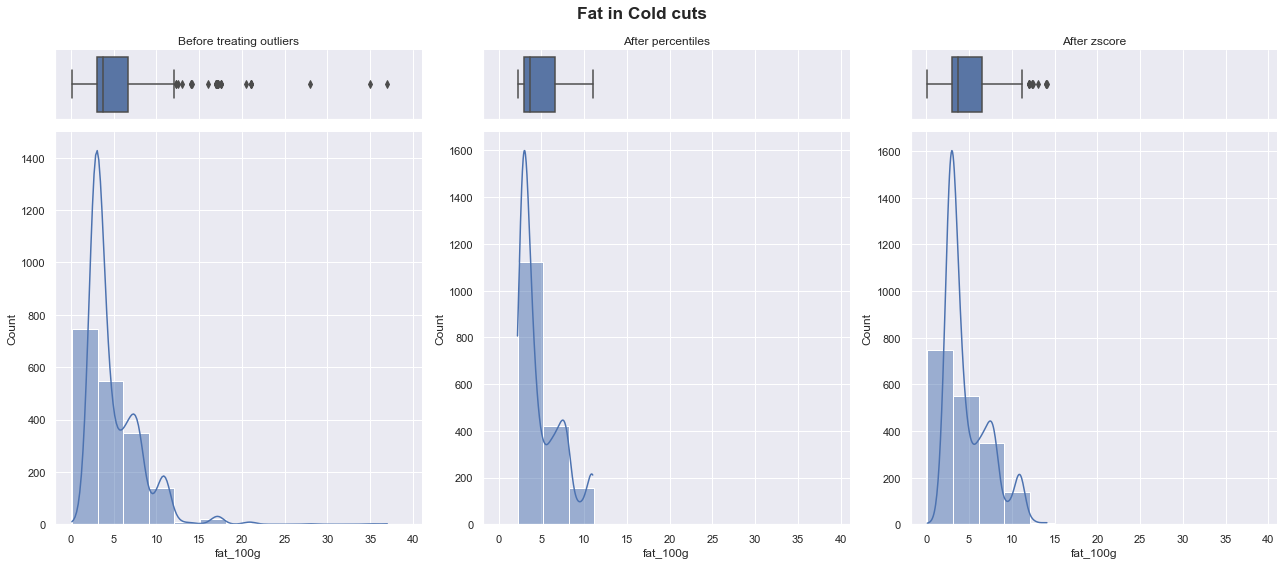

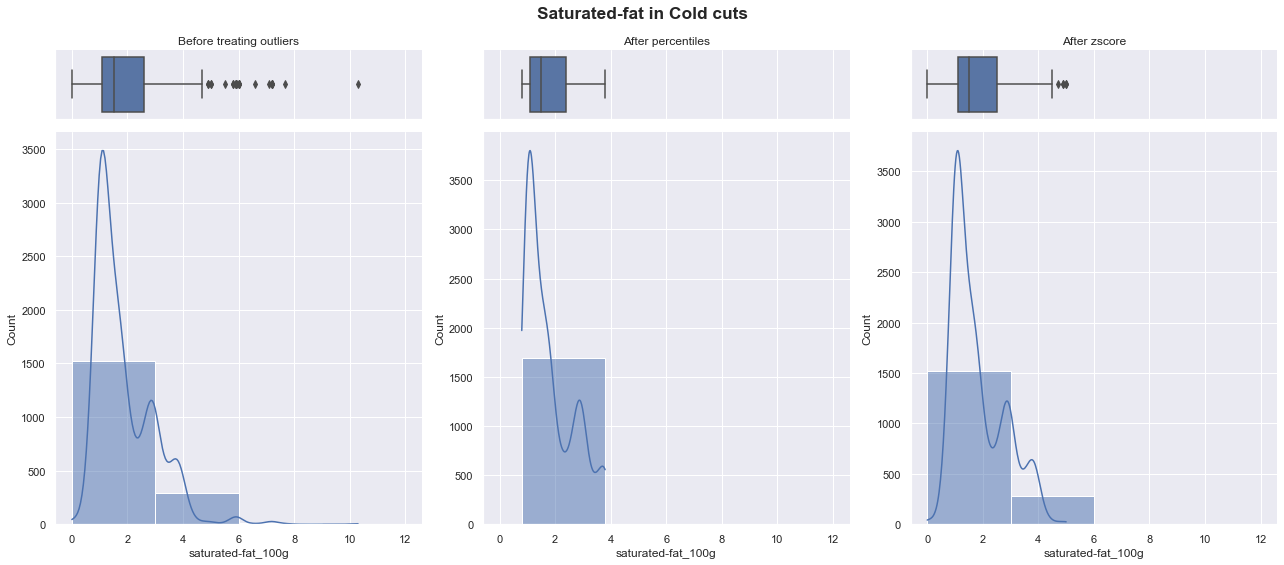

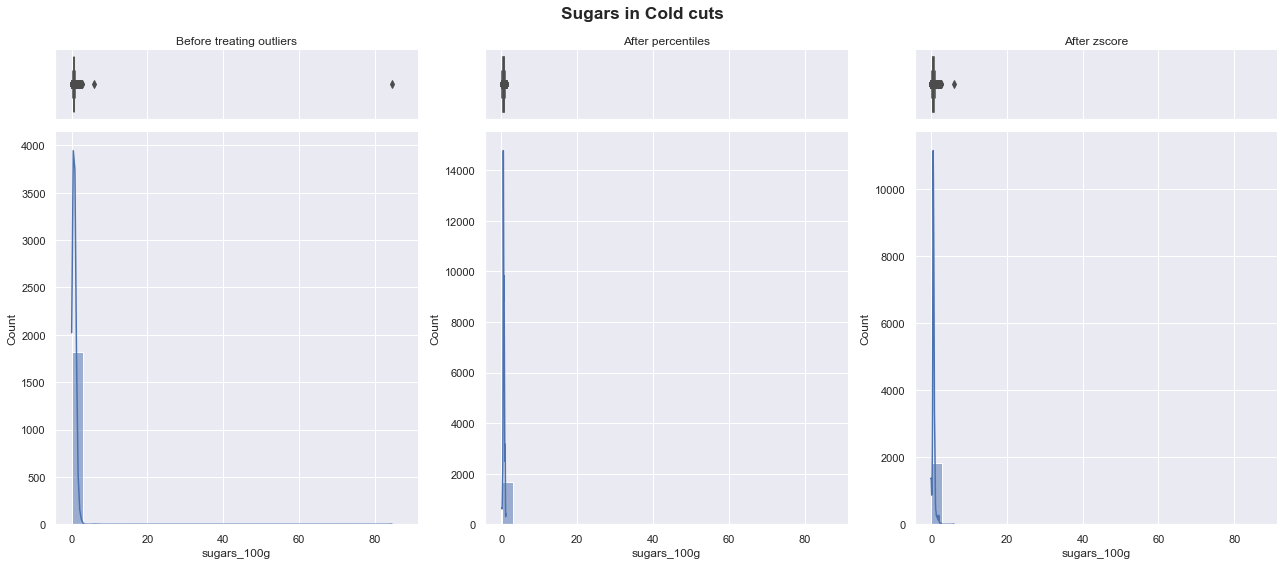

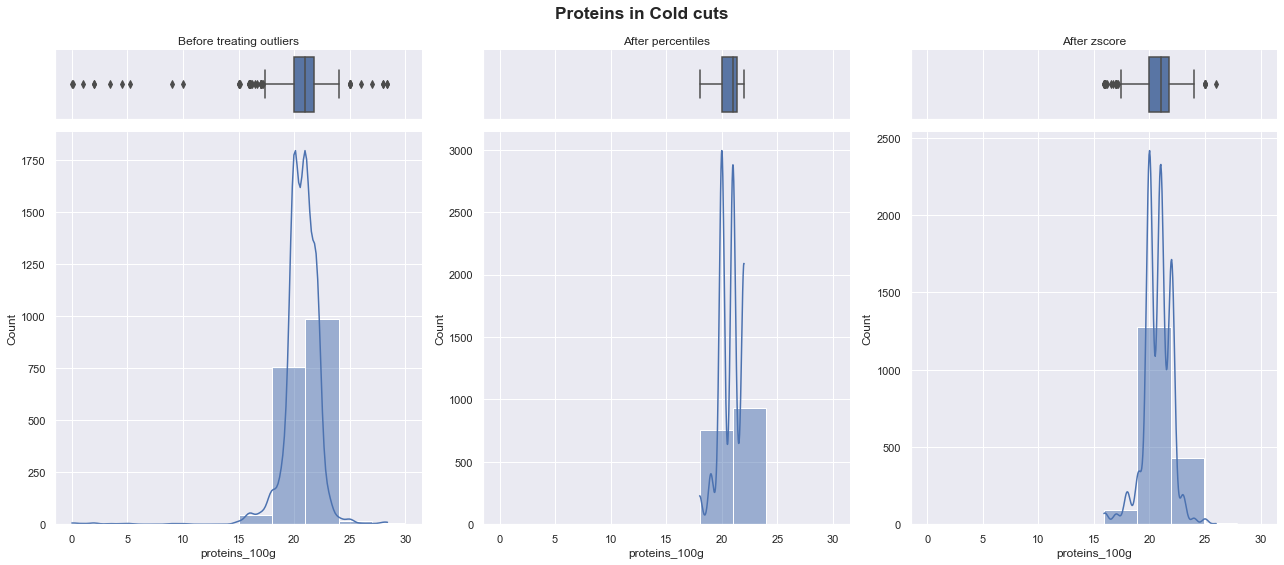

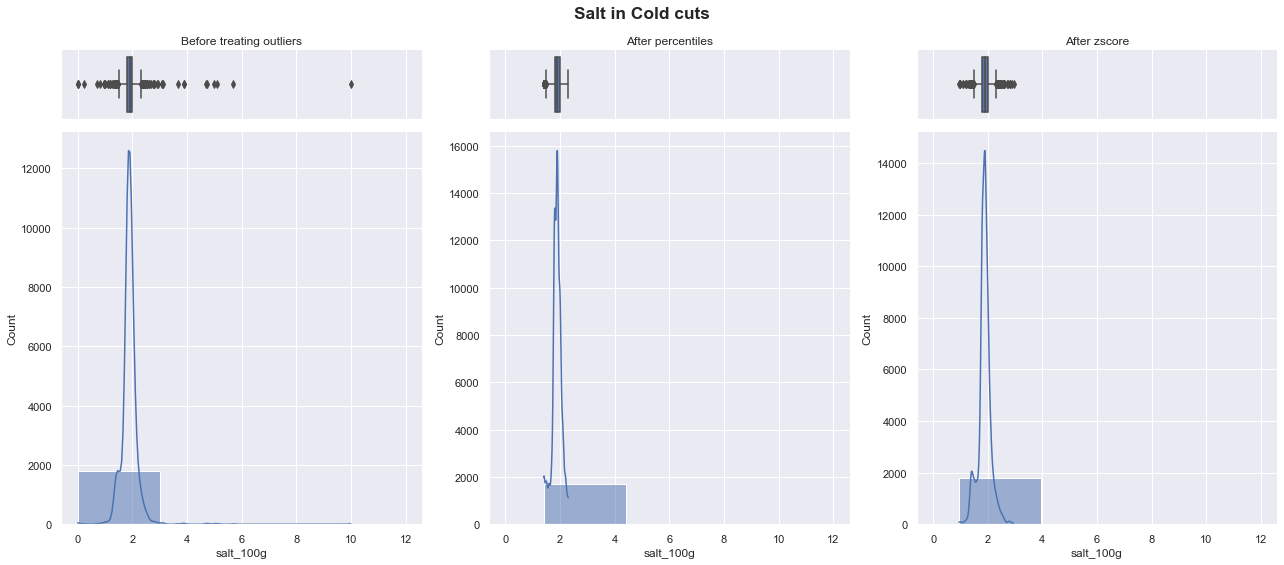

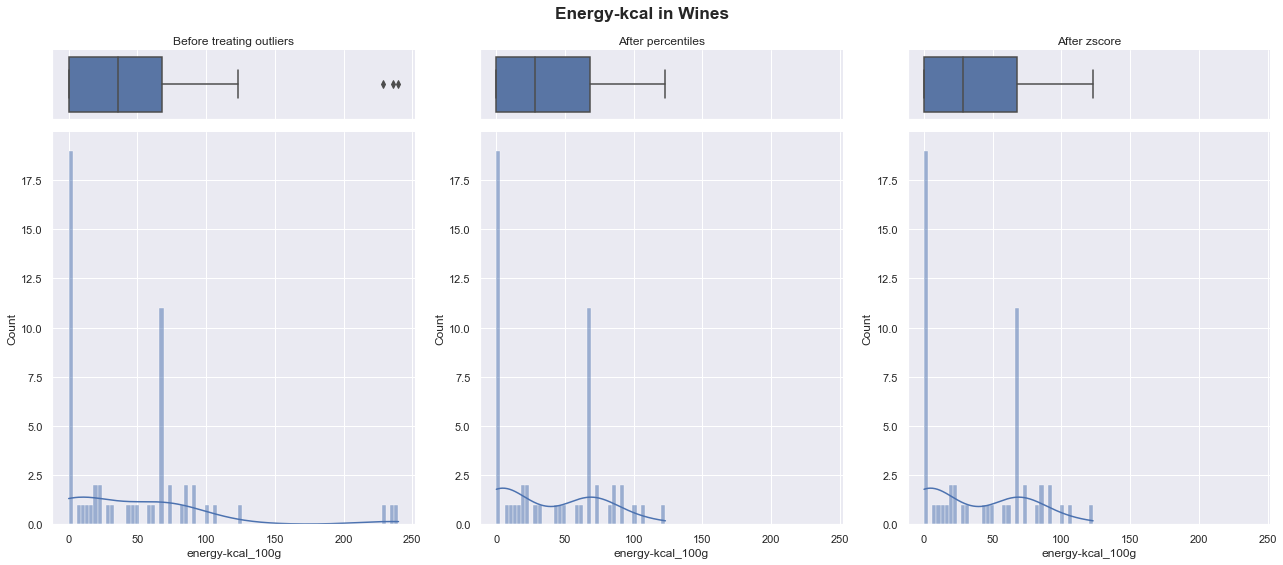

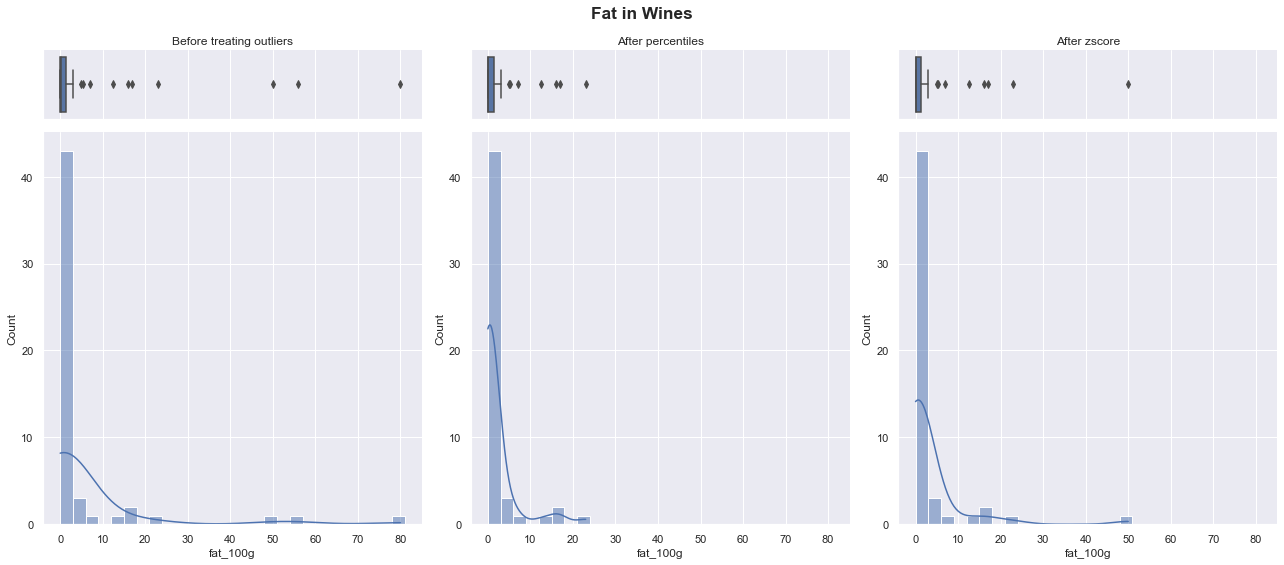

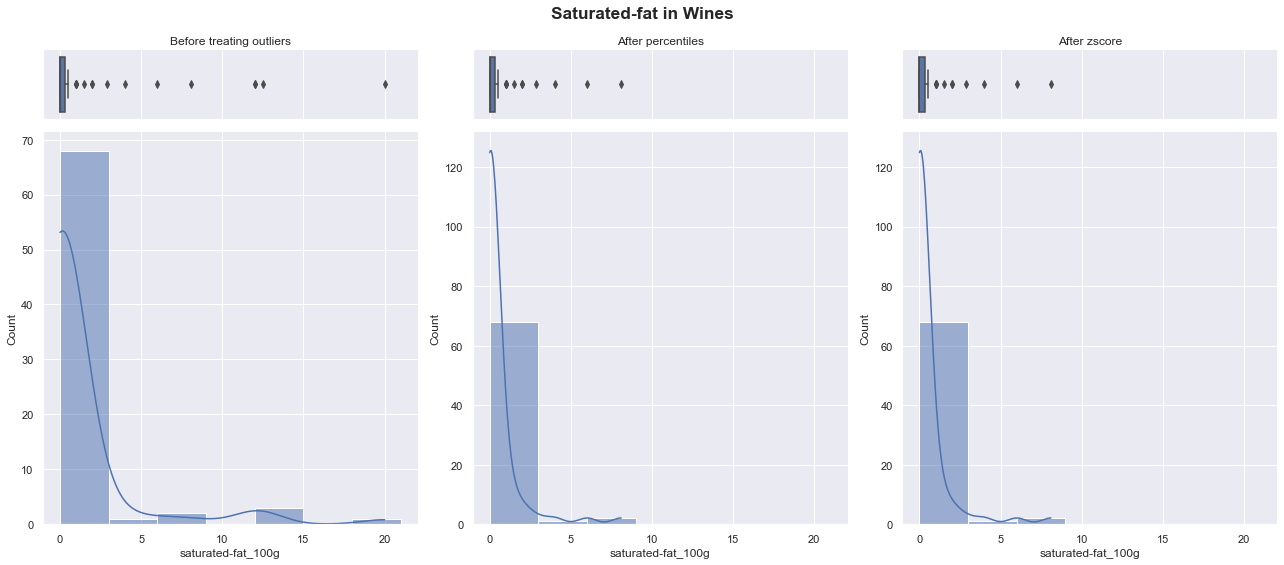

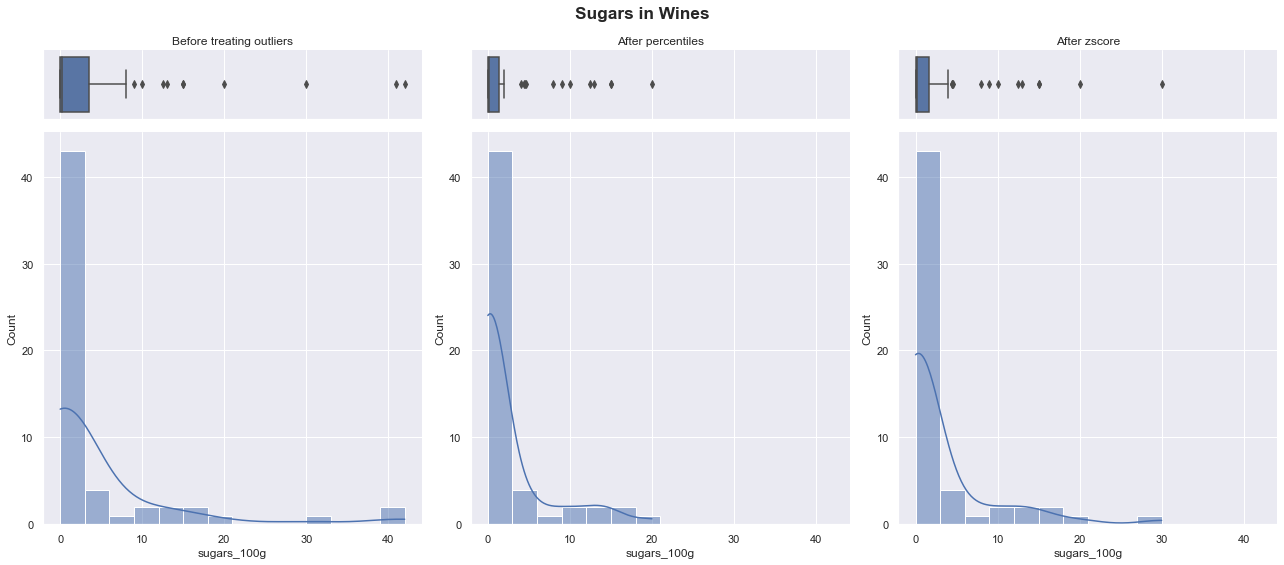

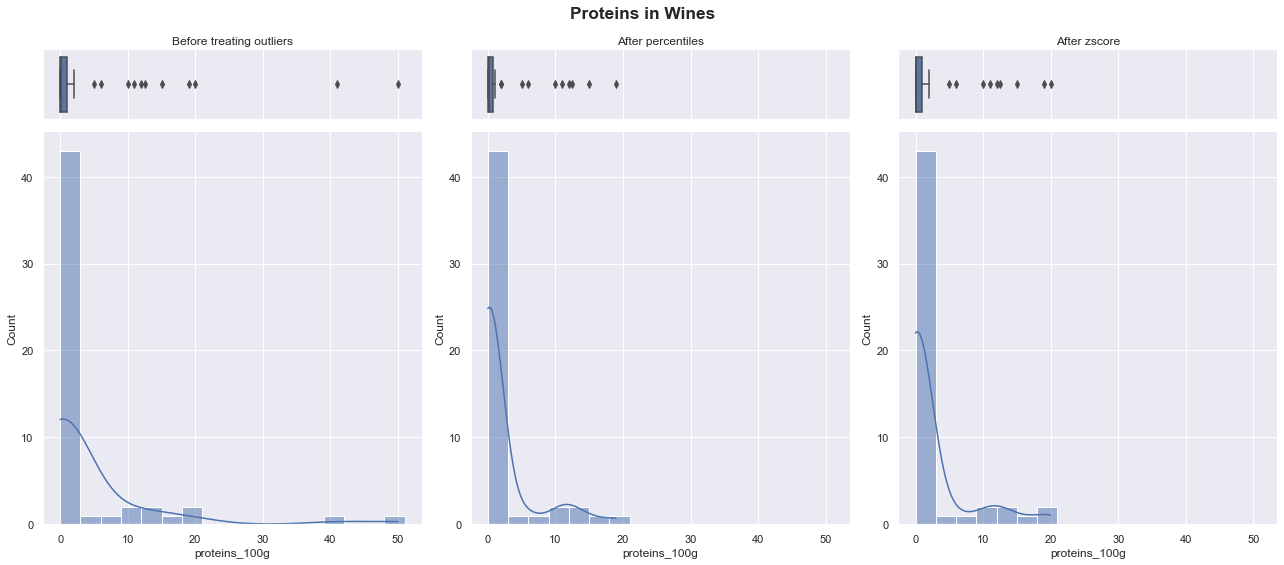

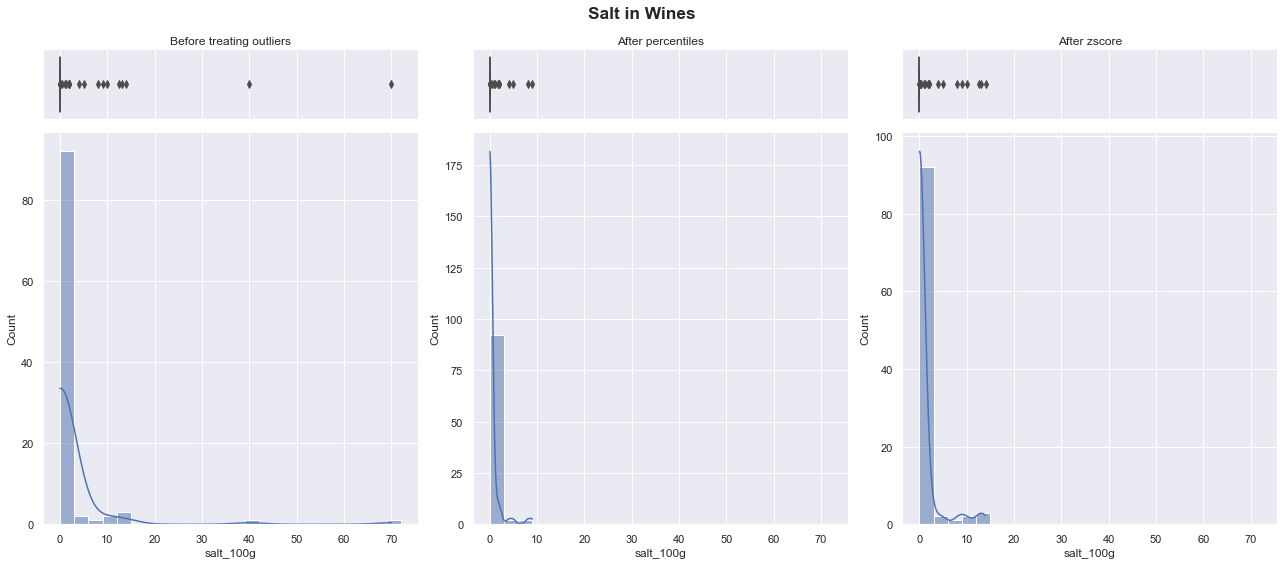

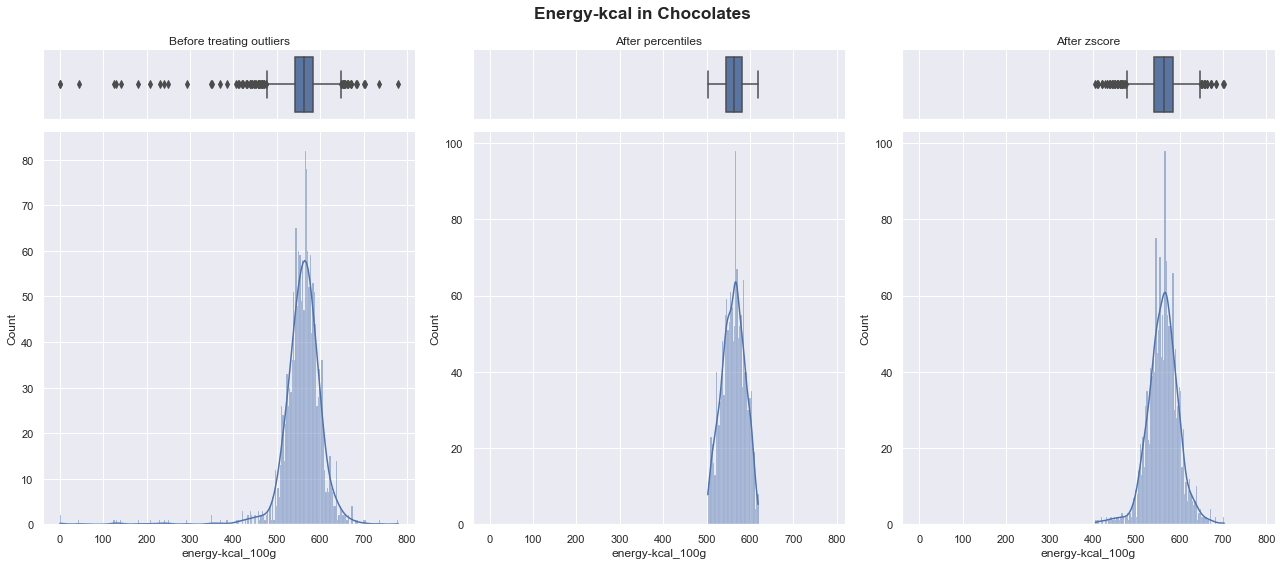

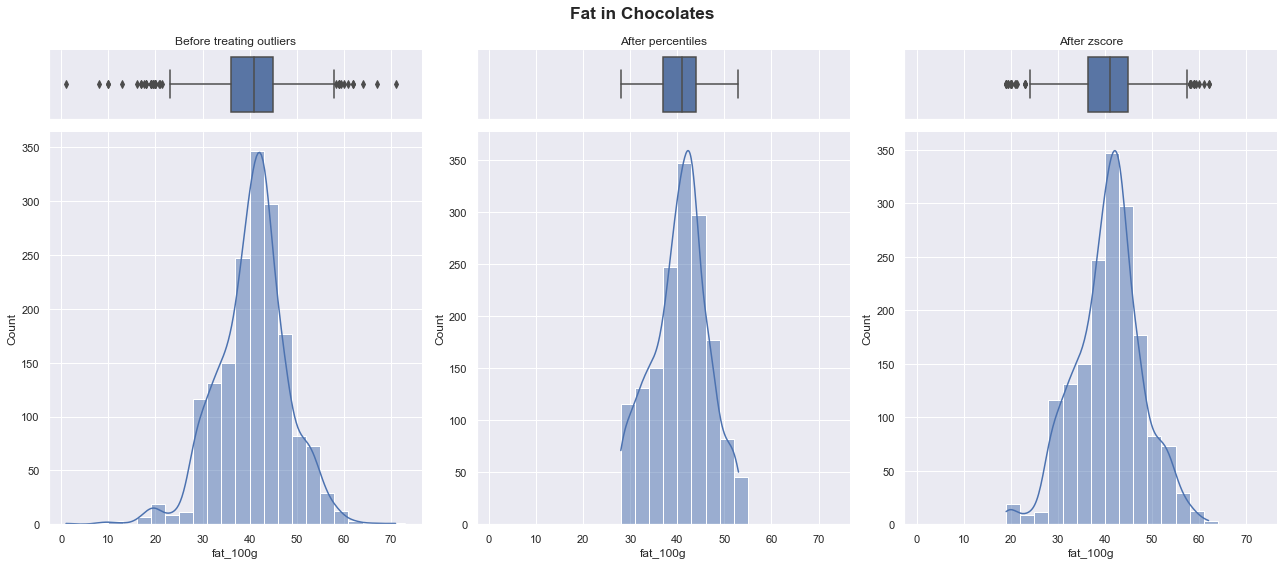

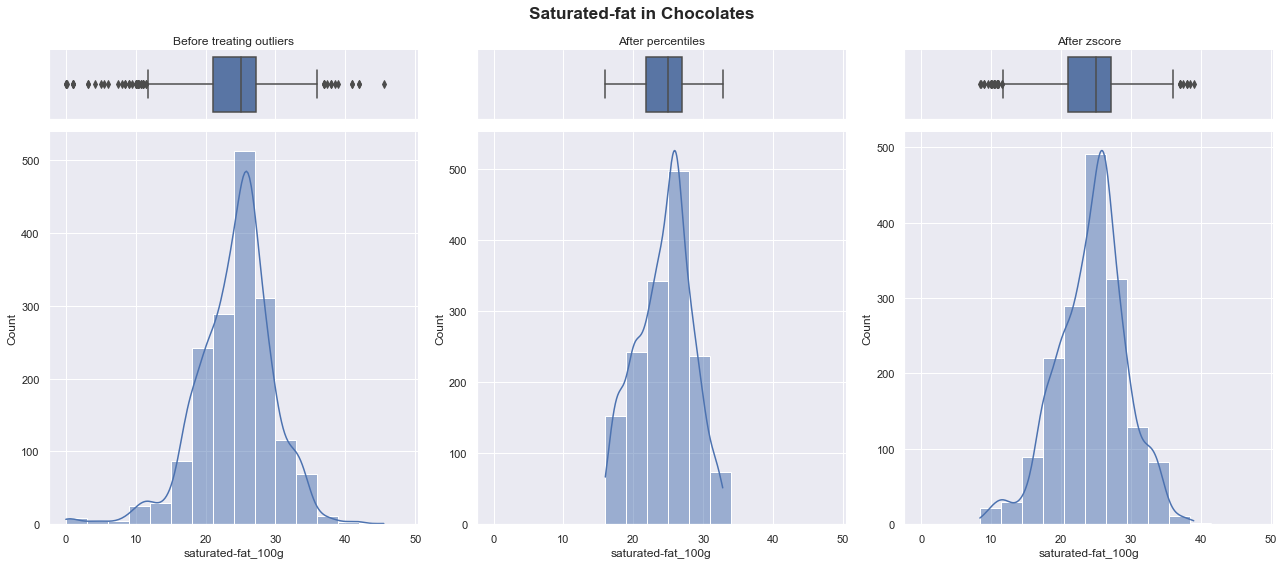

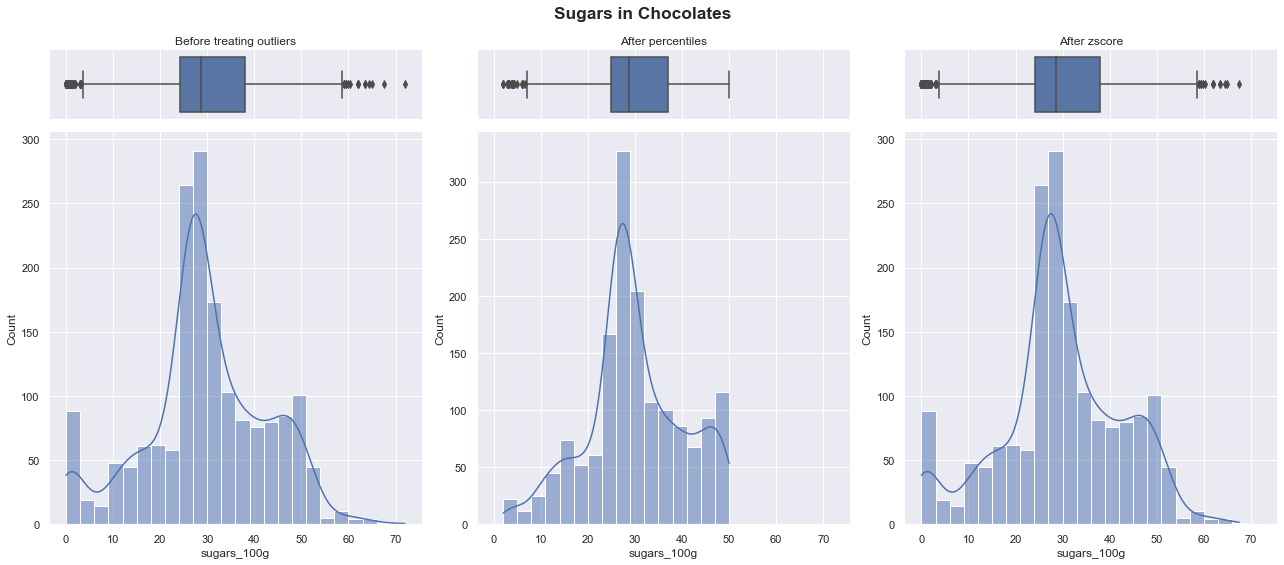

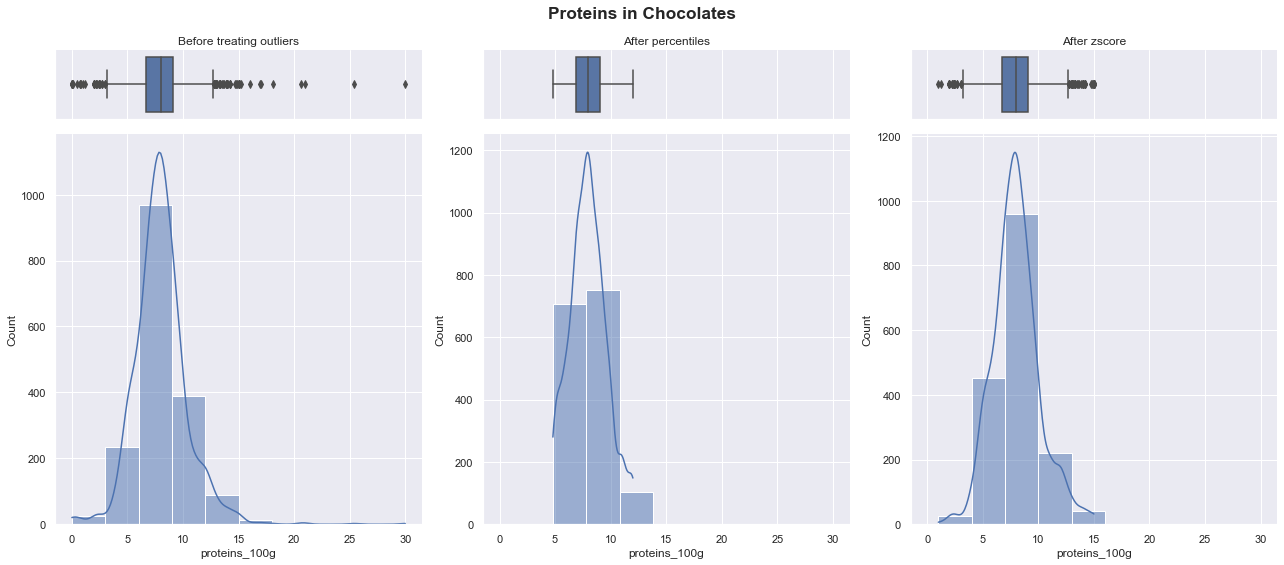

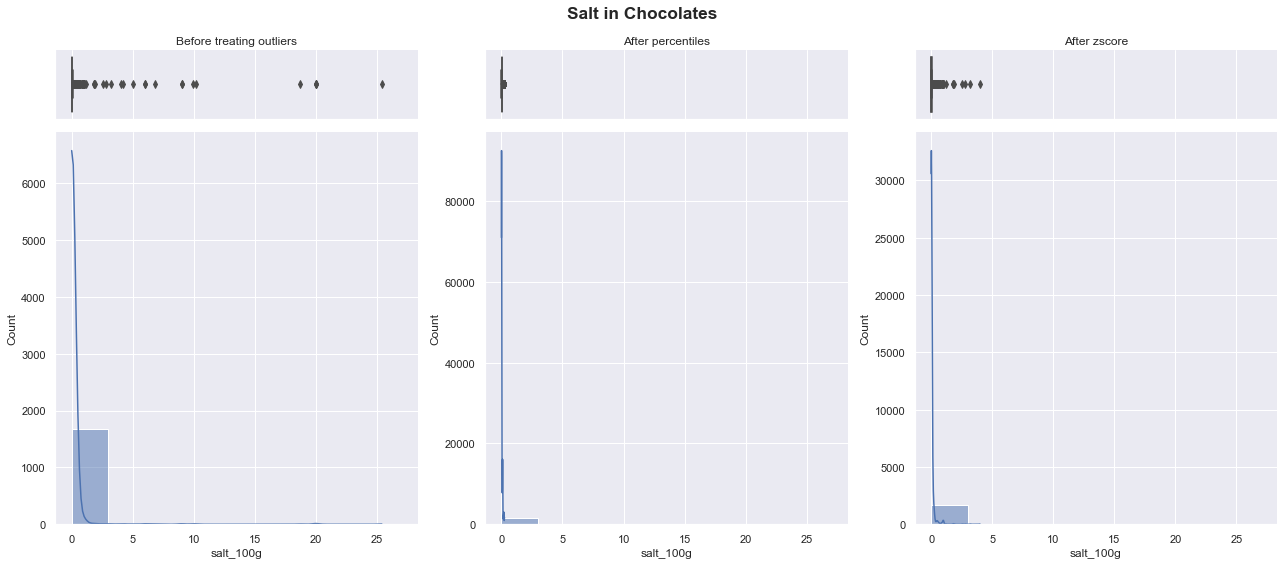

In [134]:
for category in df_with_categories["renamed_category"].unique():
    
    df_temp = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    df_temp_by_percentile = df_without_outliers_by_percentile[df_without_outliers_by_percentile["renamed_category"] == category].copy()
    df_temp_by_zscore = df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        
        # Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
        fig, ((ax_box, ax_box_percentile, ax_box_zscore), (ax_hist, ax_hist_percentile, ax_hist_zscore)) = \
                                                            plt.subplots(nrows=2, ncols=3, figsize=[18,8], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        # Title for the complete RR078466118RUfigure
        fig.suptitle((col[0:-5].capitalize() + " in " + category), fontsize="x-large", fontweight="bold")

        # Assigning a graph to each ax
        ax_box.title.set_text("Before treating outliers")
        ax_box_percentile.title.set_text("After percentiles")
        ax_box_zscore.title.set_text("After zscore")
        
        sns.boxplot(data=df_temp, x=col, ax=ax_box)
        sns.boxplot(data=df_temp_by_percentile, x=col, ax=ax_box_percentile)
        sns.boxplot(data=df_temp_by_zscore, x=col, ax=ax_box_zscore)
        
        sns.histplot(data=df_temp, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist)
        sns.histplot(data=df_temp_by_percentile, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist_percentile)
        sns.histplot(data=df_temp_by_zscore, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist_zscore)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel="")
        ax_box.set(yticks=[])
        ax_box_percentile.set(xlabel="")
        ax_box_percentile.set(yticks=[])
        ax_box_zscore.set(xlabel="")
        ax_box_zscore.set(yticks=[])

        plt.tight_layout() 
        sns.despine(fig)

<div class="alert alert-block alert-success">
    After treating <b>the Outliers</b> and analyzing the results, we have selected the dataset treated with <b>Z Score</b>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Treating missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    To select <b>the imputation way of missing-values</b>, we will go through the following steps:
    <ul style="list-style-type: square;">
        <li>Select a subset of data</li>
        <li>Split subset into Training and Testing Sets</li>
        <li>Make imputation through <b>SimpleImputer</b>, <b>CustomImputer</b>, <b>KNN Imputer</b></li>
        <li>Comparación de imputación mediante desviación estándar y RMSE</li>
    </ul>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy-kcal_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
  	<tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">main_category_en<br>categories<br>renamed_category</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Select a subset of data</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to work with the category who has more records
</div>

In [135]:
df_without_outliers_by_zscore.groupby("renamed_category")["code"].count().sort_values(ascending=False)

renamed_category
Meats                    6141
Dairy products           2469
Foods of plant origin    2125
Snacks                   1936
Cold cuts                1934
Chocolates               1811
Wines                     912
Name: code, dtype: int64

In [136]:
df_subset = df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == "Meats"].copy()

In [137]:
df_subset.shape

(6141, 13)

<div class="alert alert-block alert-info">
    Now, we are going to select only the rows without missing-values
</div>

In [138]:
df_subset = pd.DataFrame(df_subset[df_subset[NUMERIC_COLS_APP].notnull().all(axis=1)]).reset_index(drop=True)

<div class="alert alert-block alert-info">
    At this point, we have the subset of data
</div>

In [139]:
df_subset.shape

(3356, 13)

<div class="alert alert-block alert-info">
    Randomly Add NaN up to 30% of data for each column in each category present in dataset
</div>

In [140]:
df_subset_NaN = df_subset[NUMERIC_COLS_APP].mask(np.random.random(df_subset[NUMERIC_COLS_APP].shape) < 0.3)

In [141]:
df_subset_NaN = df_subset_NaN.join(df_subset[OTHER_COLS_APP])
df_subset_NaN = df_subset_NaN[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [142]:
df_subset_NaN.head()

code last_modified_datetime  \
0  0000000005166    2019-02-12 18:38:12   
1  0000069163036    2019-02-12 18:38:13   
2       00003001    2020-10-28 15:20:28   
3         650403    2020-05-04 15:38:15   
4    65137738301    2020-06-13 23:28:22   

                               product_name  \
0     cuisse de poulet direct au four curry   
1                         Cuisses de poulet   
2  Filet de poulet extra tendre thym citron   
3                      2 roast chicken legs   
4                       Tournedos de poulet   

                                       categories       main_category  \
0  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
1  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
2   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   
3  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
4   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   

  renamed_category                                          image_url  \
0            Meats  https://static.openfoodfacts.org/images/produc...   
1            Meats  https://static.openfoodfacts.org/images/produc...   
2            Meats  https://static.openfoodfacts.org/images/produc...   
3            Meats  https://static.openfoodfacts.org/images/produc...   
4            Meats  https://static.openfoodfacts.org/images/produc...   

   energy-kcal_100g  fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
0             197.0     13.00                 4.0          0.9      17.000000   
1             206.0     15.00                 NaN          1.7      16.000000   
2             108.0      1.60                 NaN          0.7      22.000000   
3               NaN     13.40                 3.4          0.3      24.400000   
4               NaN      9.73                 NaN          0.0      16.799999   

   salt_100g  
0      1.100  
1      1.100  
2      1.300  
3      0.580  
4      0.907

<div class="alert alert-block alert-info">
    Slipt the dataset into train and test
</div>

In [143]:
train, test = train_test_split(df_subset_NaN[["renamed_category"] + NUMERIC_COLS_APP], test_size=0.3)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Imputation by SimpleImputer</h3>
</div>

In [144]:
train_SimpleImputer = train[NUMERIC_COLS_APP].copy()

In [145]:
test_SimpleImputer = test[NUMERIC_COLS_APP].copy()

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [146]:
impute = SimpleImputer(missing_values=np.nan, strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [147]:
impute.fit(train_SimpleImputer)

SimpleImputer()

In [148]:
temp_imputed = impute.transform(train_SimpleImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [149]:
train_SimpleImputer = pd.DataFrame(temp_imputed, index=train_SimpleImputer.index, columns=train_SimpleImputer.columns)

In [150]:
train_SimpleImputer = train_SimpleImputer.join(df_subset[OTHER_COLS_APP])

In [151]:
train_SimpleImputer = train_SimpleImputer[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [152]:
train_SimpleImputer.head(5)

code last_modified_datetime  \
2013  2424503043100    2019-01-13 17:20:40   
1264   217885049790    2020-10-28 15:13:42   
2947  3180050136540    2020-11-14 15:42:05   
3039  3266980126377    2021-02-20 19:24:30   
2848  2851286057923    2019-07-18 07:39:15   

                                       product_name  \
2013                                Filet de poulet   
1264                                Filet de poulet   
2947  Filet de poulet mariné aux épices provençales   
3039         Cuisses de poulet s/os paprika S/AT LG   
2848                         Cuisse de poulet jaune   

                                          categories       main_category  \
2013   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   
1264   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   
2947   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   
3039  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
2848  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   

     renamed_category                                          image_url  \
2013            Meats                                                NaN   
1264            Meats  https://static.openfoodfacts.org/images/produc...   
2947            Meats  https://static.openfoodfacts.org/images/produc...   
3039            Meats                                                NaN   
2848            Meats  https://static.openfoodfacts.org/images/produc...   

      energy-kcal_100g  fat_100g  saturated-fat_100g  sugars_100g  \
2013         95.000000       0.6                 0.0     0.000000   
1264        108.000000       1.8                 0.5     0.000000   
2947        148.863647       4.3                 0.9     0.236071   
3039        148.863647      14.0                 4.2     0.236071   
2848        209.000000      16.0                 4.4     0.000000   

      proteins_100g  salt_100g  
2013      21.972364   1.000000  
1264      21.972364   0.684801  
2947      23.000000   2.000000  
3039      16.000000   1.600000  
2848      16.000000   0.684801

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [153]:
temp_imputed = impute.transform(test_SimpleImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [154]:
test_SimpleImputer = pd.DataFrame(temp_imputed, index=test_SimpleImputer.index, columns=test_SimpleImputer.columns)

In [155]:
test_SimpleImputer = test_SimpleImputer.join(df_subset[OTHER_COLS_APP])

In [156]:
test_SimpleImputer = test_SimpleImputer[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [157]:
test_SimpleImputer.head(5)

code last_modified_datetime  \
73     211792027551    2019-11-09 10:10:06   
3011  3263856631911    2020-10-23 09:28:00   
723    213402017259    2021-03-05 09:25:02   
1890  2424503027353    2019-01-13 17:20:30   
401    213323026965    2019-07-14 08:09:10   

                                      product_name  \
73                         Cuisse de poulet roties   
3011  Cuisses de poulet jaune farcies aux morilles   
723                               Cuisse de Poulet   
1890                               Filet de poulet   
401                      Hauts de cuisse de poulet   

                                          categories       main_category  \
73    Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
3011  Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
723   Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   
1890   Viandes, Volailles, Poulets, Filets de poulet  en:chicken-breasts   
401   Viandes, Volailles, Poulets, Cuisses de poulet   en:chicken-thighs   

     renamed_category                                          image_url  \
73              Meats  https://static.openfoodfacts.org/images/produc...   
3011            Meats  https://static.openfoodfacts.org/images/produc...   
723             Meats  https://static.openfoodfacts.org/images/produc...   
1890            Meats  https://static.openfoodfacts.org/images/produc...   
401             Meats  https://static.openfoodfacts.org/images/produc...   

      energy-kcal_100g   fat_100g  saturated-fat_100g  sugars_100g  \
73          148.863647   4.624862            2.600000          0.6   
3011        148.863647   4.624862            1.205472          0.0   
723         198.000000  14.000000            3.500000          0.0   
1890         95.000000   4.624862            0.000000          0.0   
401         212.000000  16.000000            4.300000          0.0   

      proteins_100g  salt_100g  
73        21.972364   1.340000  
3011      16.000000   0.550000  
723       18.000000   0.180000  
1890      21.000000   0.684801  
401       17.000000   0.684801

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [158]:
df_subset_SimpleImputer = pd.concat([train_SimpleImputer, test_SimpleImputer])

In [159]:
df_analysis(df_subset_SimpleImputer, "df_subset_SimpleImputer", "code", flag="complete")


Analysis of df_subset_SimpleImputer dataset
--------------------------------------------------------------------
- Dataset shape:                  3356 rows and 13 columns
- Total of NaN values:            160
- Percentage of NaN:              0.37 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 4.2+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  # NaN  % NaN  \
0                     code          object     3356    3356      0   0.00   
1   last_modified_datetime  datetime64[ns]     3356    1965      0   0.00   
2             product_name          object     3356     978      0   0.00   
3               categories        category     3356       3      0   0.00   
4            main_category        category     3356       3      0   0.00   
5         renamed_category          object     3356       1      0   0.00   
7         energy-kcal_100g         float32     3356     179      0   0.00   
8                 fat_100g         float32     3356     127      0   0.00   
9       saturated-fat_100g         float32     3356      84      0   0.00   
10             sugars_100g         float32     3356      48      0   0.00   
11           proteins_100g         float32     3356      77      0   0.00   
12               salt_100g         float32     3356     114      0   0.00   
6                image_url          object     3196    3196    160   4.77   

          mean  min     25%         50%         75%         max        std  
0          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
1          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
2          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
3          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
4          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
5          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
7   148.603073  0.0  109.00  148.863647  151.000000  498.000000  66.020744  
8     4.683675  0.0    1.30    4.624862    5.800000   20.000000   4.010569  
9     1.213227  0.0    0.40    1.205472    1.400000    5.900000   1.070195  
10    0.236709  0.0    0.00    0.236071    0.236071    5.000000   0.361836  
11   21.968695  9.4   21.00   21.972364   23.000000   29.200001   2.232508  
12    0.681259  0.0    0.15    0.684801    1.000000    3.600000   0.514025  
6          NaN  NaN     NaN         NaN         NaN         NaN        NaN

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Imputation by Custom Imputer</h3>
</div>

In [160]:
train_CustomImputer = train.copy()

In [161]:
test_CustomImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [162]:
encode(train_CustomImputer["renamed_category"])
encode(test_CustomImputer["renamed_category"])

C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


73      0.0
3011    0.0
723     0.0
1890    0.0
401     0.0
       ... 
1080    0.0
2222    0.0
2471    0.0
2933    0.0
2639    0.0
Name: renamed_category, Length: 1007, dtype: float64

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [163]:
scaler = MinMaxScaler()

In [164]:
scaler_features = scaler.fit_transform(train_CustomImputer)

In [165]:
train_CustomImputer = pd.DataFrame(scaler_features, index=train_CustomImputer.index, columns=train_CustomImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [166]:
impute = GroupImputer(group_cols=["renamed_category"], target=NUMERIC_COLS_APP, strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [167]:
impute.fit(train_CustomImputer)

GroupImputer(group_cols=['renamed_category'],
             target=['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
                     'sugars_100g', 'proteins_100g', 'salt_100g'])

In [168]:
temp_imputed = impute.transform(train_CustomImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [169]:
train_CustomImputer = pd.DataFrame(temp_imputed, index=train_CustomImputer.index, columns=train_CustomImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_CustomImputer = pd.DataFrame(scaler.inverse_transform(train_CustomImputer), index=train_CustomImputer.index, columns=train_CustomImputer.columns)

# Rebuilding the dataframe as the original
del train_CustomImputer["renamed_category"]
train_CustomImputer = train_CustomImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_CustomImputer = train_CustomImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [170]:
train_CustomImputer.head(5)

code last_modified_datetime  \
2013  2424503043100    2019-01-13 17:20:40   
1264   217885049790    2020-10-28 15:13:42   
2947  3180050136540    2020-11-14 15:42:05   
3039  3266980126377    2021-02-20 19:24:30   
2848  2851286057923    2019-07-18 07:39:15   

                                       product_name       main_category  \
2013                                Filet de poulet  en:chicken-breasts   
1264                                Filet de poulet  en:chicken-breasts   
2947  Filet de poulet mariné aux épices provençales  en:chicken-breasts   
3039         Cuisses de poulet s/os paprika S/AT LG   en:chicken-thighs   
2848                         Cuisse de poulet jaune   en:chicken-thighs   

                                          categories renamed_category  \
2013   Viandes, Volailles, Poulets, Filets de poulet            Meats   
1264   Viandes, Volailles, Poulets, Filets de poulet            Meats   
2947   Viandes, Volailles, Poulets, Filets de poulet            Meats   
3039  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
2848  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
2013                                                NaN         95.000000   
1264  https://static.openfoodfacts.org/images/produc...        108.000000   
2947  https://static.openfoodfacts.org/images/produc...        148.863648   
3039                                                NaN        148.863648   
2848  https://static.openfoodfacts.org/images/produc...        209.000000   

      fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
2013       0.6                 0.0     0.000000      21.972366   1.000000  
1264       1.8                 0.5     0.000000      21.972366   0.684801  
2947       4.3                 0.9     0.236071      23.000000   2.000000  
3039      14.0                 4.2     0.236071      16.000000   1.600000  
2848      16.0                 4.4     0.000000      16.000000   0.684801

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [171]:
scaler_features = scaler.fit_transform(test_CustomImputer)

In [172]:
test_CustomImputer = pd.DataFrame(scaler_features, index=test_CustomImputer.index, columns=test_CustomImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [173]:
temp_imputed = impute.transform(test_CustomImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [174]:
test_CustomImputer = pd.DataFrame(temp_imputed, index=test_CustomImputer.index, columns=test_CustomImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_CustomImputer = pd.DataFrame(scaler.inverse_transform(test_CustomImputer), index=test_CustomImputer.index, columns=test_CustomImputer.columns)

# Rebuilding the dataframe as the original
del test_CustomImputer["renamed_category"]
test_CustomImputer = test_CustomImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_CustomImputer = test_CustomImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [175]:
test_CustomImputer.head(5)

code last_modified_datetime  \
73     211792027551    2019-11-09 10:10:06   
3011  3263856631911    2020-10-23 09:28:00   
723    213402017259    2021-03-05 09:25:02   
1890  2424503027353    2019-01-13 17:20:30   
401    213323026965    2019-07-14 08:09:10   

                                      product_name       main_category  \
73                         Cuisse de poulet roties   en:chicken-thighs   
3011  Cuisses de poulet jaune farcies aux morilles   en:chicken-thighs   
723                               Cuisse de Poulet   en:chicken-thighs   
1890                               Filet de poulet  en:chicken-breasts   
401                      Hauts de cuisse de poulet   en:chicken-thighs   

                                          categories renamed_category  \
73    Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
3011  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
723   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
1890   Viandes, Volailles, Poulets, Filets de poulet            Meats   
401   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
73    https://static.openfoodfacts.org/images/produc...        139.298112   
3011  https://static.openfoodfacts.org/images/produc...        139.298112   
723   https://static.openfoodfacts.org/images/produc...        198.000000   
1890  https://static.openfoodfacts.org/images/produc...         95.000000   
401   https://static.openfoodfacts.org/images/produc...        212.000000   

       fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
73     4.624862            2.600000          0.6      19.751108   1.340000  
3011   4.624862            1.164608          0.0      16.000000   0.550000  
723   14.000000            3.500000          0.0      18.000000   0.180000  
1890   4.624862            0.000000          0.0      21.000000   0.494579  
401   16.000000            4.300000          0.0      17.000000   0.494579

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [176]:
df_subset_CustomImputer = pd.concat([train_CustomImputer, test_CustomImputer])

In [177]:
df_analysis(df_subset_CustomImputer, "df_subset_CustomImputer", "code", flag="complete")


Analysis of df_subset_CustomImputer dataset
--------------------------------------------------------------------
- Dataset shape:                  3356 rows and 13 columns
- Total of NaN values:            160
- Percentage of NaN:              0.37 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 4.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  # NaN  % NaN  \
0                     code          object     3356    3356      0   0.00   
1   last_modified_datetime  datetime64[ns]     3356    1965      0   0.00   
2             product_name          object     3356     978      0   0.00   
3            main_category        category     3356       3      0   0.00   
4               categories        category     3356       3      0   0.00   
5         renamed_category          object     3356       1      0   0.00   
7         energy-kcal_100g         float64     3356     183      0   0.00   
8                 fat_100g         float64     3356     127      0   0.00   
9       saturated-fat_100g         float64     3356     100      0   0.00   
10             sugars_100g         float64     3356      52      0   0.00   
11           proteins_100g         float64     3356      86      0   0.00   
12               salt_100g         float64     3356     121      0   0.00   
6                image_url          object     3196    3196    160   4.77   

          mean  min     25%         50%         75%         max        std  
0          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
1          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
2          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
3          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
4          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
5          NaN  NaN     NaN         NaN         NaN         NaN        NaN  
7   147.776508  0.0  109.00  148.863648  151.000000  498.000000  66.072184  
8     4.683675  0.0    1.30    4.624862    5.800000   20.000000   4.010569  
9     1.209903  0.0    0.40    1.164608    1.400000    5.900000   1.070277  
10    0.226580  0.0    0.00    0.122757    0.236071    5.000000   0.363296  
11   21.779396  9.4   20.00   21.972366   23.000000   29.200001   2.316778  
12    0.663915  0.0    0.15    0.684801    1.000000    3.600000   0.516815  
6          NaN  NaN     NaN         NaN         NaN         NaN        NaN

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.4. Imputation by KNN Imputer</h3>
</div>

In [178]:
train_KNNImputer = train.copy()

In [179]:
test_KNNImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [180]:
encode(train_KNNImputer["renamed_category"])
encode(test_KNNImputer["renamed_category"])

C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


73      0.0
3011    0.0
723     0.0
1890    0.0
401     0.0
       ... 
1080    0.0
2222    0.0
2471    0.0
2933    0.0
2639    0.0
Name: renamed_category, Length: 1007, dtype: float64

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [181]:
scaler_features = scaler.fit_transform(train_KNNImputer)

In [182]:
train_KNNImputer = pd.DataFrame(scaler_features, index=train_KNNImputer.index, columns=train_KNNImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [183]:
impute = KNNImputer()

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [184]:
impute.fit(train_KNNImputer)

KNNImputer()

In [185]:
temp_imputed = impute.transform(train_KNNImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [186]:
train_KNNImputer = pd.DataFrame(temp_imputed, index=train_KNNImputer.index, columns=train_KNNImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_KNNImputer = pd.DataFrame(scaler.inverse_transform(train_KNNImputer), index=train_KNNImputer.index, columns=train_KNNImputer.columns)

# Rebuilding the dataframe as the original
del train_KNNImputer["renamed_category"]
train_KNNImputer = train_KNNImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_KNNImputer = train_KNNImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [187]:
train_KNNImputer.head(5)

code last_modified_datetime  \
2013  2424503043100    2019-01-13 17:20:40   
1264   217885049790    2020-10-28 15:13:42   
2947  3180050136540    2020-11-14 15:42:05   
3039  3266980126377    2021-02-20 19:24:30   
2848  2851286057923    2019-07-18 07:39:15   

                                       product_name       main_category  \
2013                                Filet de poulet  en:chicken-breasts   
1264                                Filet de poulet  en:chicken-breasts   
2947  Filet de poulet mariné aux épices provençales  en:chicken-breasts   
3039         Cuisses de poulet s/os paprika S/AT LG   en:chicken-thighs   
2848                         Cuisse de poulet jaune   en:chicken-thighs   

                                          categories renamed_category  \
2013   Viandes, Volailles, Poulets, Filets de poulet            Meats   
1264   Viandes, Volailles, Poulets, Filets de poulet            Meats   
2947   Viandes, Volailles, Poulets, Filets de poulet            Meats   
3039  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
2848  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
2013                                                NaN              95.0   
1264  https://static.openfoodfacts.org/images/produc...             108.0   
2947  https://static.openfoodfacts.org/images/produc...             316.2   
3039                                                NaN             180.6   
2848  https://static.openfoodfacts.org/images/produc...             209.0   

      fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
2013       0.6                 0.0         0.00          22.00      1.000  
1264       1.8                 0.5         0.00          22.42      0.484  
2947       4.3                 0.9         0.00          23.00      2.000  
3039      14.0                 4.2         0.46          16.00      1.600  
2848      16.0                 4.4         0.00          16.00      0.460

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [188]:
scaler_features = scaler.fit_transform(test_KNNImputer)

In [189]:
test_KNNImputer = pd.DataFrame(scaler_features, index=test_KNNImputer.index, columns=test_KNNImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [190]:
temp_imputed = impute.transform(test_KNNImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [191]:
test_KNNImputer = pd.DataFrame(temp_imputed, index=test_KNNImputer.index, columns=test_KNNImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_KNNImputer = pd.DataFrame(scaler.inverse_transform(test_KNNImputer), index=test_KNNImputer.index, columns=test_KNNImputer.columns)

# Rebuilding the dataframe as the original
del test_KNNImputer["renamed_category"]
test_KNNImputer = test_KNNImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_KNNImputer = test_KNNImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [192]:
test_KNNImputer.head(5)

code last_modified_datetime  \
73     211792027551    2019-11-09 10:10:06   
3011  3263856631911    2020-10-23 09:28:00   
723    213402017259    2021-03-05 09:25:02   
1890  2424503027353    2019-01-13 17:20:30   
401    213323026965    2019-07-14 08:09:10   

                                      product_name       main_category  \
73                         Cuisse de poulet roties   en:chicken-thighs   
3011  Cuisses de poulet jaune farcies aux morilles   en:chicken-thighs   
723                               Cuisse de Poulet   en:chicken-thighs   
1890                               Filet de poulet  en:chicken-breasts   
401                      Hauts de cuisse de poulet   en:chicken-thighs   

                                          categories renamed_category  \
73    Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
3011  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
723   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
1890   Viandes, Volailles, Poulets, Filets de poulet            Meats   
401   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
73    https://static.openfoodfacts.org/images/produc...        142.607229   
3011  https://static.openfoodfacts.org/images/produc...        113.786345   
723   https://static.openfoodfacts.org/images/produc...        198.000000   
1890  https://static.openfoodfacts.org/images/produc...         95.000000   
401   https://static.openfoodfacts.org/images/produc...        212.000000   

      fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
73        7.62            2.600000          0.6      18.391666   1.340000  
3011      6.30            2.067458          0.0      16.000000   0.550000  
723      14.00            3.500000          0.0      18.000000   0.180000  
1890      3.12            0.000000          0.0      21.000000   0.491111  
401      16.00            4.300000          0.0      17.000000   0.332222

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [193]:
df_subset_KNNImputer = pd.concat([train_KNNImputer, test_KNNImputer])

In [194]:
df_analysis(df_subset_KNNImputer, "df_subset_KNNImputer", "code", flag="complete")


Analysis of df_subset_KNNImputer dataset
--------------------------------------------------------------------
- Dataset shape:                  3356 rows and 13 columns
- Total of NaN values:            160
- Percentage of NaN:              0.37 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 4.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  # NaN  % NaN  \
0                     code          object     3356    3356      0   0.00   
1   last_modified_datetime  datetime64[ns]     3356    1965      0   0.00   
2             product_name          object     3356     978      0   0.00   
3            main_category        category     3356       3      0   0.00   
4               categories        category     3356       3      0   0.00   
5         renamed_category          object     3356       1      0   0.00   
7         energy-kcal_100g         float64     3356     752      0   0.00   
8                 fat_100g         float64     3356     791      0   0.00   
9       saturated-fat_100g         float64     3356     726      0   0.00   
10             sugars_100g         float64     3356     293      0   0.00   
11           proteins_100g         float64     3356     291      0   0.00   
12               salt_100g         float64     3356     756      0   0.00   
6                image_url          object     3196    3196    160   4.77   

          mean  min         25%        50%         75%         max        std  
0          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
1          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
2          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
3          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
4          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
5          NaN  NaN         NaN        NaN         NaN         NaN        NaN  
7   151.626598  0.0  107.000000  137.08996  173.705422  498.000000  70.322228  
8     5.059343  0.0    1.300000    4.36500    7.545000   20.000000   4.295560  
9     1.232428  0.0    0.400000    0.74000    1.700000    5.900000   1.145415  
10    0.216070  0.0    0.000000    0.01832    0.300000    5.000000   0.377491  
11   21.847485  9.4   20.138125   23.00000   24.000000   29.200001   2.419144  
12    0.666262  0.0    0.130000    0.55400    1.100000    3.600000   0.547866  
6          NaN  NaN         NaN        NaN         NaN         NaN        NaN

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.5. Imputation by Iterative Imputer</h3>
</div>

In [195]:
train_IterativeImputer = train.copy()

In [196]:
test_IterativeImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [197]:
encode(train_IterativeImputer["renamed_category"])
encode(test_IterativeImputer["renamed_category"])

C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Samir\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


73      0.0
3011    0.0
723     0.0
1890    0.0
401     0.0
       ... 
1080    0.0
2222    0.0
2471    0.0
2933    0.0
2639    0.0
Name: renamed_category, Length: 1007, dtype: float64

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [198]:
scaler_features = scaler.fit_transform(train_IterativeImputer)

In [199]:
train_IterativeImputer = pd.DataFrame(scaler_features, index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [200]:
impute = IterativeImputer(estimator=BayesianRidge(), imputation_order="ascending", initial_strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [201]:
impute.fit(train_IterativeImputer)

C:\Users\Samir\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


IterativeImputer(estimator=BayesianRidge())

In [202]:
temp_imputed = impute.transform(train_IterativeImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [203]:
train_IterativeImputer = pd.DataFrame(temp_imputed, index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_IterativeImputer = pd.DataFrame(scaler.inverse_transform(train_IterativeImputer), index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)

# Rebuilding the dataframe as the original
del train_IterativeImputer["renamed_category"]
train_IterativeImputer = train_IterativeImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_IterativeImputer = train_IterativeImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [204]:
train_IterativeImputer.head(5)

code last_modified_datetime  \
2013  2424503043100    2019-01-13 17:20:40   
1264   217885049790    2020-10-28 15:13:42   
2947  3180050136540    2020-11-14 15:42:05   
3039  3266980126377    2021-02-20 19:24:30   
2848  2851286057923    2019-07-18 07:39:15   

                                       product_name       main_category  \
2013                                Filet de poulet  en:chicken-breasts   
1264                                Filet de poulet  en:chicken-breasts   
2947  Filet de poulet mariné aux épices provençales  en:chicken-breasts   
3039         Cuisses de poulet s/os paprika S/AT LG   en:chicken-thighs   
2848                         Cuisse de poulet jaune   en:chicken-thighs   

                                          categories renamed_category  \
2013   Viandes, Volailles, Poulets, Filets de poulet            Meats   
1264   Viandes, Volailles, Poulets, Filets de poulet            Meats   
2947   Viandes, Volailles, Poulets, Filets de poulet            Meats   
3039  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
2848  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
2013                                                NaN         95.000000   
1264  https://static.openfoodfacts.org/images/produc...        108.000000   
2947  https://static.openfoodfacts.org/images/produc...        119.118358   
3039                                                NaN        154.066893   
2848  https://static.openfoodfacts.org/images/produc...        209.000000   

      fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
2013       0.6                 0.0     0.000000      24.286180   1.000000  
1264       1.8                 0.5     0.000000      23.283913   0.479774  
2947       4.3                 0.9     0.590898      23.000000   2.000000  
3039      14.0                 4.2     0.723878      16.000000   1.600000  
2848      16.0                 4.4     0.000000      16.000000   0.637557

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [205]:
scaler_features = scaler.fit_transform(test_IterativeImputer)

In [206]:
test_IterativeImputer = pd.DataFrame(scaler_features, index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [207]:
temp_imputed = impute.transform(test_IterativeImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [208]:
test_IterativeImputer = pd.DataFrame(temp_imputed, index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_IterativeImputer = pd.DataFrame(scaler.inverse_transform(test_IterativeImputer), index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)

# Rebuilding the dataframe as the original
del test_IterativeImputer["renamed_category"]
test_IterativeImputer = test_IterativeImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_IterativeImputer = test_IterativeImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [209]:
test_IterativeImputer.head(5)

code last_modified_datetime  \
73     211792027551    2019-11-09 10:10:06   
3011  3263856631911    2020-10-23 09:28:00   
723    213402017259    2021-03-05 09:25:02   
1890  2424503027353    2019-01-13 17:20:30   
401    213323026965    2019-07-14 08:09:10   

                                      product_name       main_category  \
73                         Cuisse de poulet roties   en:chicken-thighs   
3011  Cuisses de poulet jaune farcies aux morilles   en:chicken-thighs   
723                               Cuisse de Poulet   en:chicken-thighs   
1890                               Filet de poulet  en:chicken-breasts   
401                      Hauts de cuisse de poulet   en:chicken-thighs   

                                          categories renamed_category  \
73    Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
3011  Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
723   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   
1890   Viandes, Volailles, Poulets, Filets de poulet            Meats   
401   Viandes, Volailles, Poulets, Cuisses de poulet            Meats   

                                              image_url  energy-kcal_100g  \
73    https://static.openfoodfacts.org/images/produc...        160.908282   
3011  https://static.openfoodfacts.org/images/produc...        132.848310   
723   https://static.openfoodfacts.org/images/produc...        198.000000   
1890  https://static.openfoodfacts.org/images/produc...         95.000000   
401   https://static.openfoodfacts.org/images/produc...        212.000000   

       fat_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  
73     9.883726            2.600000          0.6      17.015531   1.340000  
3011  10.305966            2.592107          0.0      16.000000   0.550000  
723   14.000000            3.500000          0.0      18.000000   0.180000  
1890   0.280877            0.000000          0.0      21.000000   0.302769  
401   16.000000            4.300000          0.0      17.000000   0.582084

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [210]:
df_subset_IterativeImputer = pd.concat([train_IterativeImputer, test_IterativeImputer])

In [211]:
df_analysis(df_subset_IterativeImputer, "df_subset_IterativeImputer", "code", flag="complete")


Analysis of df_subset_IterativeImputer dataset
--------------------------------------------------------------------
- Dataset shape:                  3356 rows and 13 columns
- Total of NaN values:            160
- Percentage of NaN:              0.37 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 4.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------


name            type  records  unique  # NaN  % NaN  \
0                     code          object     3356    3356      0   0.00   
1   last_modified_datetime  datetime64[ns]     3356    1965      0   0.00   
2             product_name          object     3356     978      0   0.00   
3            main_category        category     3356       3      0   0.00   
4               categories        category     3356       3      0   0.00   
5         renamed_category          object     3356       1      0   0.00   
7         energy-kcal_100g         float64     3356     944      0   0.00   
8                 fat_100g         float64     3356     929      0   0.00   
9       saturated-fat_100g         float64     3356     885      0   0.00   
10             sugars_100g         float64     3356     817      0   0.00   
11           proteins_100g         float64     3356     857      0   0.00   
12               salt_100g         float64     3356     902      0   0.00   
6                image_url          object     3196    3196    160   4.77   

          mean        min     25%         50%         75%         max  \
0          NaN        NaN     NaN         NaN         NaN         NaN   
1          NaN        NaN     NaN         NaN         NaN         NaN   
2          NaN        NaN     NaN         NaN         NaN         NaN   
3          NaN        NaN     NaN         NaN         NaN         NaN   
4          NaN        NaN     NaN         NaN         NaN         NaN   
5          NaN        NaN     NaN         NaN         NaN         NaN   
7   149.882906 -35.022640  107.00  138.676003  168.000000  498.000000   
8     4.661844  -5.234912    1.30    2.168923    6.502562   21.719104   
9     1.223138  -1.127705    0.40    0.600000    1.700000    5.900000   
10    0.223919  -0.605537    0.00    0.019104    0.400000    5.000000   
11   21.752826   9.400000   20.00   23.000000   24.000000   29.200001   
12    0.673821  -0.611580    0.15    0.574585    1.100000    3.600000   
6          NaN        NaN     NaN         NaN         NaN         NaN   

          std  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
7   69.840714  
8    4.679197  
9    1.236663  
10   0.382269  
11   2.554616  
12   0.555403  
6         NaN

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.5. Comparison of imputations</h3>
</div>

<div class="alert alert-block alert-info">
    Concatenating the dataframes to make a comparison
</div>

In [212]:
df_subset["data"] = "Original"
df_subset_SimpleImputer["data"] = "Simple Imputer"
df_subset_CustomImputer["data"] = "Custom Imputer"
df_subset_KNNImputer["data"] = "KNN Imputer"
df_subset_IterativeImputer["data"] = "Iterative Imputer"

In [213]:
df_comparision = pd.concat([df_subset, df_subset_SimpleImputer, df_subset_CustomImputer, df_subset_KNNImputer, df_subset_IterativeImputer])

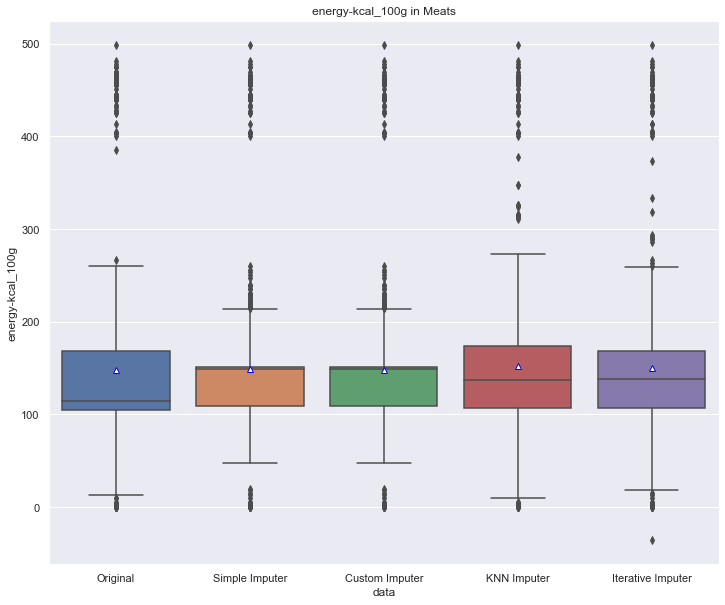

In [214]:
plt.figure(figsize=[12,10])
sns.boxplot(x=df_comparision["data"], y=df_comparision["energy-kcal_100g"], showmeans=True, 
            meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"}).title.set_text("energy-kcal_100g" + " in " + "Meats")
plt.show()

<div class="alert alert-block alert-info">
    Calculating Root Mean Square Error for each imputation
</div>

In [215]:
rmse_dict = {}
for data in df_comparision["data"].unique():
    if data != "Original":
        MSE = mean_squared_error(df_subset["energy-kcal_100g"], (df_comparision.loc[df_comparision["data"] == data, "energy-kcal_100g"]))
        RMSE = math.sqrt(MSE)
        rmse_dict[data] = RMSE
        print("Root Mean Square Error by", data, "is :", RMSE)
        
rmse_df = pd.DataFrame

Root Mean Square Error by Simple Imputer is : 101.76841954902171
Root Mean Square Error by Custom Imputer is : 101.77952517302384
Root Mean Square Error by KNN Imputer is : 104.41075093540992
Root Mean Square Error by Iterative Imputer is : 104.10378833416667


In [223]:
rmse_df = pd.DataFrame(rmse_dict.items(), columns=["Method", "RMSE"])
rmse_df

Method        RMSE
0     Simple Imputer  101.768420
1     Custom Imputer  101.779525
2        KNN Imputer  104.410751
3  Iterative Imputer  104.103788

Text(0.5, 1.0, 'Root Mean Square Error of mmputations to energy-kcal_100g')

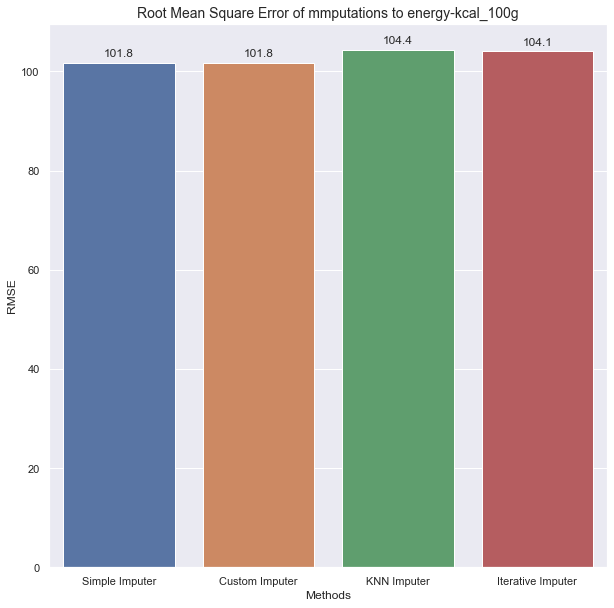

In [224]:
fig = plt.subplots(figsize=(10, 10))
plot = sns.barplot(x="Method", y="RMSE", data=rmse_df)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Methods", size=12)
plt.title("Root Mean Square Error of mmputations to energy-kcal_100g", size=14)

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
</div>